# Which customers are likely to not show up for their medical appointment?

## Project purpose - learn to deal with heavy class imbalance

1. <b>Project completed by:</b> Arseniy Barmin
2. <b>Project duration:</b> March 2020 - April 2020

In this project, I will create a machine learning model to predict which patients are likely to not show up for their scheduled medical appointment. 

This is a binary classification problem, meaning that a variety of classification algorithms can be analyzed. The challenge of this dataset lies in its skewness; the number of no-show customers is far less than the number of customers who show up for their scheduled appointments. This means that many algorithms are likely to achieve high accuracy, but will be poor at predicting the under-represented class - no-show customers. Therefore, this specific dataset presents a number of challenges that need to be addressed to deliver a well-performing machine learning model.

____

### The business question

Which customers are likely to not show up for their medical appointment?

___

## Importing libraries

I will be populating this code block with all libraries I will use in this project. By default, I always import pandas, matplotlib, and seaborn.

In [28]:
# data science essentials
import pandas as pd 

# data science essentials
import numpy as np

# data visualization essentials
import matplotlib.pyplot as plt

# enhanced data vizualization tools
import seaborn as sns 

# importing train_test_split
from sklearn.model_selection import train_test_split  

# importing statsmodels
import statsmodels.formula.api as smf                  

# importing Logistic Regression
from sklearn.linear_model import LogisticRegression 

# importing F1-score metric
from sklearn.metrics import f1_score                 

# importing confusion matrix
from sklearn.metrics import confusion_matrix

# importing roc_auc_score metric
from sklearn.metrics import roc_auc_score

# Importing GridSearchCV for hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

# Importing customizable scorer
from sklearn.metrics import make_scorer

# Importing StandardScaler()
from sklearn.preprocessing import StandardScaler

# Importing the kNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Importing Classification trees
from sklearn.tree import DecisionTreeClassifier

# Importing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Importing XGBoost
from xgboost import XGBClassifier

___

## Initial data analysis

In the next code block, I will upload my dataset to Jupyter Notebook, specify pandas print options, and then view the first 5 rows of each variable.

In [29]:
# Uploading the dataset
file = 'appointment_project.csv'
my_df = pd.read_csv(file, parse_dates = ['ScheduledDay','AppointmentDay'])

# Specifying pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Printing the first 5 rows of my dataset
my_df.head(n = 5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,8.679510e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
1,9.598510e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No
2,8.457440e+13,5633121,M,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,NOVA PALESTINA,0,0,0,0,0,0,No
3,7.184430e+13,5638545,F,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,CONQUISTA,0,0,0,0,0,0,No
4,9.912880e+13,5597673,M,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,MARIA ORTIZ,0,0,0,0,0,1,Yes


I always want to start my analysis by investigating possible missing values in the dataset. Therefore, the next code block explores possible missing values.

In [30]:
# Exploring missing values per column
my_df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

Surprisingly, my dataset doesn't contain any missing values.

I notice that values I will later be trying to predict are located in the column "No-show". Currently, this column contains values "Yes" and "No". Machine learning algorithms are not capable of processing categorical variables. In the next code block, I will:

- Create a new column "Outcome", because I don't like having special characters in my column headings
- Populate "Outcome" column values with 0s (for "No" values in "No-show" column) and with 1s (for "Yes" values in "No-show" column) 
- Drop the "No-show" column once "Outcome" column with appropriate values is created
- Print the first 5 rows of my data to ensure everything has been done correctly

In [31]:
# Creating a new "Outcome" column and determining values 
# of new "Outcome" column based on "No-show" column values
my_df['Outcome'] = (my_df['No-show'] == 'Yes').astype(int)

# Dropping the "No-show" column since I now have "Outcome" column
my_df = my_df.drop(["No-show"], axis =1)

# Pring the first 5 rows of my data to ensure solution worked
my_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome
0,8.679510e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
1,9.598510e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,0
2,8.457440e+13,5633121,M,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,NOVA PALESTINA,0,0,0,0,0,0,0
3,7.184430e+13,5638545,F,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,CONQUISTA,0,0,0,0,0,0,0
4,9.912880e+13,5597673,M,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,MARIA ORTIZ,0,0,0,0,0,1,1


___

## Feature Engineering

Next, I notice that I have a categorical "Gender" column. To prepare this column for machine learning, I will next one-hot encode this column.

In [32]:
# One-hot encoding "Gender" variable
one_hot_gender = pd.get_dummies(my_df["Gender"])

# Dropping original "Gender" categorical variable
my_df = my_df.drop(["Gender"], axis = 1)

# Joining my_df and one_hot_gender together
my_df = my_df.join([one_hot_gender])

# Printing my_df to ensure the code worked
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M
0,8.679510e+11,5642828,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,1,0
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,0,1,0
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,NOVA PALESTINA,0,0,0,0,0,0,0,0,1
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,CONQUISTA,0,0,0,0,0,0,0,1,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,MARIA ORTIZ,0,0,0,0,0,1,1,0,1


The original "Gender" column has been dropped, and in place I have "M" and "F" columns that are suitable to be processed my machine learning algorithms.

___

#### Outlier analysis

Next, I notice I have "Neighbourhood" column, which can prove important to in predicting which people may not show up for their appointment. First, I will analyze value counts for each neighbourhood.

In [33]:
# Analyzing count of customers calling from different neighborhoods
my_df['Neighbourhood'].value_counts()

JARDIM CAMBURI         697
MARIA ORTIZ            519
RESISTÊNCIA            402
JARDIM DA PENHA        323
CENTRO                 308
ITARARÉ                306
TABUAZEIRO             299
BONFIM                 278
JESUS DE NAZARETH      267
SANTA MARTHA           266
SANTO ANTÔNIO          260
JABOUR                 243
DA PENHA               240
CARATOÍRA              236
SÃO PEDRO              228
SANTO ANDRÉ            222
ILHA DO PRÍNCIPE       213
SÃO JOSÉ               198
ANDORINHAS             198
NOVA PALESTINA         198
ROMÃO                  188
SÃO CRISTÓVÃO          188
GURIGICA               179
ILHA DE SANTA MARIA    176
FORTE SÃO JOÃO         175
BELA VISTA             154
REDENÇÃO               149
MARUÍPE                148
SÃO BENEDITO           136
JOANA D´ARC            132
CRUZAMENTO             127
SANTA TEREZA           125
SANTOS DUMONT          121
CONSOLAÇÃO             112
GRANDE VITÓRIA         107
PRAIA DO SUÁ           106
ILHA DAS CAIEIRAS       87
G

My dataset has 10,000 observations, and there are many different neighborhoods where people who schedule an appointment live. Value counts for each neighborhood range between 1 and 697. Using common sense, some neighborhoods are very uncommon for people to call from to schedule an appointment, which is why some neighborhoods appear in the dataset many times less than others. Because value counts for such neighborhoods is low, it will also be hard for machine learning algorithms to properly analyze that data. Therefore, I will next drop neighborhoods from my data that appear less than 50 times.

In [34]:
# Determining insignificant count threshold
insignificant_counts = my_df['Neighbourhood'].value_counts()

# Removing rows from the dataset 
# which match neighbourhoods with count of less than 50
my_df = my_df.loc[my_df['Neighbourhood'].isin(insignificant_counts.index[insignificant_counts > 50])]

# Ensuring that only neighbourhoods with significant counts remain
my_df["Neighbourhood"].value_counts()

JARDIM CAMBURI         697
MARIA ORTIZ            519
RESISTÊNCIA            402
JARDIM DA PENHA        323
CENTRO                 308
ITARARÉ                306
TABUAZEIRO             299
BONFIM                 278
JESUS DE NAZARETH      267
SANTA MARTHA           266
SANTO ANTÔNIO          260
JABOUR                 243
DA PENHA               240
CARATOÍRA              236
SÃO PEDRO              228
SANTO ANDRÉ            222
ILHA DO PRÍNCIPE       213
NOVA PALESTINA         198
ANDORINHAS             198
SÃO JOSÉ               198
SÃO CRISTÓVÃO          188
ROMÃO                  188
GURIGICA               179
ILHA DE SANTA MARIA    176
FORTE SÃO JOÃO         175
BELA VISTA             154
REDENÇÃO               149
MARUÍPE                148
SÃO BENEDITO           136
JOANA D´ARC            132
CRUZAMENTO             127
SANTA TEREZA           125
SANTOS DUMONT          121
CONSOLAÇÃO             112
GRANDE VITÓRIA         107
PRAIA DO SUÁ           106
ILHA DAS CAIEIRAS       87
G

Now that my dataset contains neighborhoods that appear more than 50 times in the dataset, I am ready to one-hot encode this column in order to make it acceptable for processing by machine learning algorithms. Once one-hot encoding is complete, I will drop the original "Neighbourhood" variable.

In [35]:
# One-hot encoding the "Neighbourhood" column
one_hot_neighborhood = pd.get_dummies(my_df["Neighbourhood"])

# Dropping the original "Neighbourhood" column
my_df = my_df.drop(["Neighbourhood"], axis = 1)

# Joining my_df and "one_hot_neighborhood" together
my_df = my_df.join([one_hot_neighborhood])

# Printing my_df to make sure the code worked
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Every neighborhood name is its own column now, which machine learning algorithms can now interpret for their possible significance in predicting which customers are likely to not show up for their scheduled appointment. Next, let's explore the "Age" column by first analyzing its values and their frequencies.

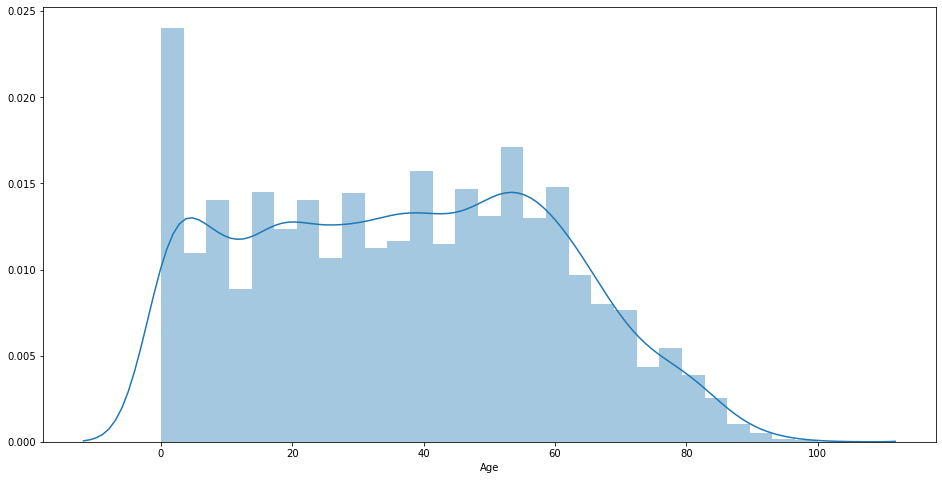

In [36]:
# Evaluating the value distributions in the "Age" column
plt.figure(figsize = (16, 8))
sns.distplot(my_df["Age"])
plt.show()

From the plot above, I notice 2 points of outliers. 

- The first outlier is at 0; there is an unusual amount of children who have an appointment scheduled at age 0, so I realize the "Age" column is 0-inflated. Potentially, this dataset has been taken from a hospital that specialized in newborn child care. 
- The second outlier is at around 70 years of age. In other words, there are way less appointments booked for people of age 70 or older.

Given the above insights, in the next code block I will set my outlier thresholds.

In [37]:
# Determining outlier threshold for 0-inflated values
age_change_at = 0

# Determining outlier threshold for people 70 years of age or older
age_high = 70

Now that outlier thresholds are set, I will next create 2 new column, each containing its value for outliers I identified. That way, my machine learning algorithms will later be able to evaluate if outliers in the "Age" column are significant in predicting whether a person will show up for their scheduled appointment.

In [38]:
# Creating a new column to store 0-inflated values
my_df["Age_change_at"] = 0

# Storing 0-inflated values in "Age_change_at" column
condition = my_df.loc[0: , "Age_change_at"][my_df["Age"] == age_change_at]
my_df["Age_change_at"].replace(to_replace = condition, 
                               value = 1, 
                               inplace = True)

# Creating a new column to store values of 70 years old patients and higher
my_df["Age_high"] = 0

# Storing values for patients aged 70 and higher in a new "Age_high" column
condition_high = my_df.loc[0: , "Age_high"][my_df["Age"] >= age_high]
my_df["Age_high"].replace(to_replace = condition_high,
                          value = 1,
                          inplace = True)

# Checking if the code above worked
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now, I have 2 new column that flag my outliers for the "Age" columns. This will allow for a more detailed evaluation of my data to see which factors exactly help predict which people are likely to not show up for their scheduled appointment.

___

#### Working with dates

Next, I will work with my 2 columns that contain information about the day an appointment was scheduled and the day of the appointment. Before I jump into my analysis, I first have to make sure that "ScheduledDay" and "AppointmentDay" variables are in 'datetime' format.

In [39]:
# Evaluating the type of each variable
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9144 entries, 1 to 9999
Data columns (total 64 columns):
PatientId              9144 non-null float64
AppointmentID          9144 non-null int64
ScheduledDay           9144 non-null datetime64[ns, UTC]
AppointmentDay         9144 non-null datetime64[ns, UTC]
Age                    9144 non-null int64
Scholarship            9144 non-null int64
Hipertension           9144 non-null int64
Diabetes               9144 non-null int64
Alcoholism             9144 non-null int64
Handcap                9144 non-null int64
SMS_received           9144 non-null int64
Outcome                9144 non-null int64
F                      9144 non-null uint8
M                      9144 non-null uint8
ANDORINHAS             9144 non-null uint8
BELA VISTA             9144 non-null uint8
BENTO FERREIRA         9144 non-null uint8
BONFIM                 9144 non-null uint8
CARATOÍRA              9144 non-null uint8
CENTRO                 9144 non-null uint8
CON

The "ScheduledDay" and "AppointmentDay" variables are of 'datetime' format, which will allow me to do some math with them. In addition, I notice that both columns are set to the UTC time, which is good for the purpose of my analysis. I don't know from which region this dataset has been collected, so I cannot set it to a specific timezone.

In the next code block, I will create a column that calculates the duration between the day patients schedule their appointment and the day their appointment is set for.

In [40]:
# Creating a new column 
# to calculate wait time between 'AppointmentDay' and 'ScheduledDay'
my_df['WaitTime'] = my_df['AppointmentDay'] - my_df['ScheduledDay']

# What is the average wait time between scheduled day and appointment day?
my_df['WaitTime'].mean()

Timedelta('9 days 12:20:42.511264')

The average time between appointment day and scheduled day is appoximately 9.5 days.

Machine learning algorithms do not accept variables of type 'datetime'. Therefore, to include the values of 'WaitTime' column as a possible predictor to evaluate which customers are likely to not show up for their appointment, I will create a new column - 'DurationDays' - which will contain the same information as "WaitTime", but in a format acceptable by Machine learning algorithms (float64)

In [41]:
# Calculating duration in days between scheduled day and appointment day
my_df['DurationDays'] = my_df['WaitTime'].dt.total_seconds()/60/60/24

# checking the format of the new "DurationDays" column
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9144 entries, 1 to 9999
Data columns (total 66 columns):
PatientId              9144 non-null float64
AppointmentID          9144 non-null int64
ScheduledDay           9144 non-null datetime64[ns, UTC]
AppointmentDay         9144 non-null datetime64[ns, UTC]
Age                    9144 non-null int64
Scholarship            9144 non-null int64
Hipertension           9144 non-null int64
Diabetes               9144 non-null int64
Alcoholism             9144 non-null int64
Handcap                9144 non-null int64
SMS_received           9144 non-null int64
Outcome                9144 non-null int64
F                      9144 non-null uint8
M                      9144 non-null uint8
ANDORINHAS             9144 non-null uint8
BELA VISTA             9144 non-null uint8
BENTO FERREIRA         9144 non-null uint8
BONFIM                 9144 non-null uint8
CARATOÍRA              9144 non-null uint8
CENTRO                 9144 non-null uint8
CON

The new "DurationDays" column is of type 'float64'. Now that I have this column, I can drop the original "WaitTime" column, as it is no longer necessary nor useful.

In [42]:
# Dropping the "WaitTime" column
my_df.drop(['WaitTime'], axis = 1, inplace = True)

# Checking to make sure the "WaitTime" column was dropped
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778


The column was dropped successfully. In the next code block, let's evaluate the distribution of variables in the "DurationDays" column to insect for potential outliers.

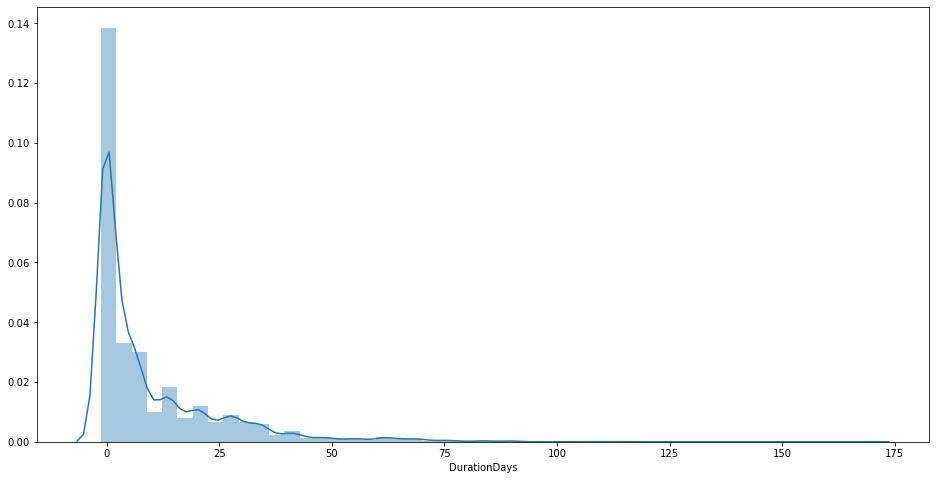

In [43]:
# Distribution of values based on how many days elapsed between
# the day the appointment was scheduled and the day of the appointment
plt.figure(figsize = (16, 8))
sns.distplot(my_df["DurationDays"])
plt.show()

Interestingly, the majority of appointments are booked within short time span from the actual appointment day. In addition, I know that the average wait time between the day an appointment is scheduled and the day of the appointment is 9.5 days. 

Since there is no perfect way to identify threshold for outliers, in the next code I will set outlier threshold at 14 days and create a new column to store outlier values.

In [44]:
# Setting outlier threshold
duration_days_high = 14

# Creating a new column to store outlier values
my_df["out_DurationDays"] = 0

# Storing outlier values in the new column
condition = my_df.loc[0: , "out_DurationDays"][my_df["DurationDays"] >= duration_days_high]
my_df["out_DurationDays"].replace(to_replace = condition, 
                               value = 1, 
                               inplace = True)

# Making sure the new column was created
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0


New column was created, and more insights will be processed later to analyze which variables are significant in predicting which customers are likely to not show up for appointment.

##### Analysing "ScheduledDay" column

This dataset contains 10,000 observations, which makes me assume that I have data available for multiple months. Therefore, in the next code block I will analyze how "ScheduledDay" values are distributed by month.

In [45]:
# How many appointments were requested to be scheduled by month?
my_df.resample('M', on = 'ScheduledDay').size()

ScheduledDay
2015-12-31 00:00:00+00:00       1
2016-01-31 00:00:00+00:00       4
2016-02-29 00:00:00+00:00      25
2016-03-31 00:00:00+00:00     300
2016-04-30 00:00:00+00:00    2056
2016-05-31 00:00:00+00:00    5595
2016-06-30 00:00:00+00:00    1163
Freq: M, dtype: int64

By far, I notice that May was the most popular month for people to call in and schedule an appointment. Across all months in the dataset, the values are reasonably distributed. My common sense tells me that this is a valuable information to capture. Potentially, this may help us predict which customers are likely to schedule and not show up for their appointment.

In the next code block, I will create a new column that will capture the name of the month for each corresponding date on which an appointment was scheduled.

In [46]:
# Creating a column 'ScheduledMonth' to store month of scheduled appointments
my_df['ScheduledMonth'] = my_df["ScheduledDay"].dt.month_name()

# Making sure the code above worked properly
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledMonth
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,April
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,April
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,April
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,April
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,April


The code above worked, and I now have more information to rely on to see what information will prove to be significant in predicting which customers are likely to not show up for their scheduled appointment.

Machine Learning algorithms can only process numeric variables. Therefore, in the next code block I will one-hot encode my new "ScheduledMonth" to capture information of each month in its separate column.

In [47]:
# One-hot encoding the "ScheduledMonth" column
one_hot_scheduledmonth = pd.get_dummies(my_df["ScheduledMonth"])

# Dropping the original "ScheduledMonth" column
my_df = my_df.drop(["ScheduledMonth"], axis = 1)

# Joining my_df and "one_hot_scheduledmonth" together
my_df = my_df.join([one_hot_scheduledmonth])

# Printing my_df to make sure the code worked
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,April,December,February,January,June,March,May
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0


The code worked as intentioned. Next, I will re-name newly created columns to communicate infomration on columns' values more explicitly.

In [48]:
# Renaming new column for easy recognition of their meaning
my_df.rename(columns = {"April"       :  "ScheduledInApril",
                        "December"    :  "ScheduledInDecember",
                        "February"    :  "ScheduledInFebruary",
                        "January"     :  "ScheduledInJanuary",
                        "June"        :  "ScheduledInJune",
                        "March"       :  "ScheduledInMarch",
                        "May"         : "ScheduledInMay"}, 
                        inplace = True)

# Ensuring the columns are renamed
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0


The code wokred well. Now, I will also be able to analyze if a specific month is a significant in predicting which customers are likely to not show up for their appointments.

To further my analysis, in the next code I will create a new column - 'ScheduledDayWeekday' - that will contain days of the week each appointment was scheduled.

In [49]:
# Creating new column to store days of  week each appointment was booked on
my_df['ScheduledDayWeekday'] = my_df["ScheduledDay"].dt.weekday_name

# How many appointments were scheduled on each day?
my_df['ScheduledDayWeekday'].value_counts()

Tuesday      2133
Wednesday    2049
Monday       1897
Friday       1610
Thursday     1454
Saturday        1
Name: ScheduledDayWeekday, dtype: int64

No appointments were scheduled on the Sunday, and only 1 on Saturday. This communicates that this business is likely open only Monday to Friday. From Monday to Friday, appointments are roughly equally distributed. I want to include this information to evaluate its importance in predicting which customers are likely to not show up for appointment. Therefore, I will next create a new column for each day of the week in a format that Machine Learning algorithms are able to process.

In [50]:
# One-hot encoding the "ScheduledDayWeekday" column
one_hot_scheduleddayweekday = pd.get_dummies(my_df["ScheduledDayWeekday"])

# Dropping the original "ScheduledDayWeekday" column
my_df = my_df.drop(["ScheduledDayWeekday"], axis = 1)

# Joining my_df and "one_hot_scheduledayweekday" together
my_df = my_df.join([one_hot_scheduleddayweekday])

# Printing my_df to make sure the code worked
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0


New columns have been created, each with the name of its weekday. Later, I will work "AppointmentDay" column in similar fashion. Therefore, I will rename the new columns to make it clear what they communicate

In [51]:
# Renaming new column for easy recognition of their meaning
my_df.rename(columns = {"Friday"    :  "ScheduledOnFriday",
                        "Monday"    :  "ScheduledOnMonday",
                        "Saturday"  :  "ScheduledOnSaturday",
                        "Thursday"  :  "ScheduledOnThursday",
                        "Tuesday"   :  "ScheduledOnTuesday",
                        "Wednesday" :  "ScheduledOnWednesday"}, 
                        inplace = True)

# Ensuring the columns are renamed
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0


The columns were renamed successfully. People scheduled appointments for different times of day. Specifically, some scheduled their appointment in the morning (AM time), and in the afternoon (PM). Potentially, this can be a significant predictor to who is likely to not show up for their scheduled appointment. 

In the next code block I will create a new column that will identify whether an appointment was scheduled in the 'AM' or 'PM' time, based on values stored in the 'SCheduledDay' column. Here is how I identify AM and PM times:
- AM corresponds to times before 12:00
- PM corresponds to times from 12:00 onwards

In [52]:
# Creating a new 'ScheduledDayTimeOfDay' column with AM and PM values
# based on a specified condition
my_df['ScheduledDayTimeOfDay'] = np.where(my_df.ScheduledDay.dt.hour < 12, 'AM','PM')

# Counting values, also making sure the column was created successfully
my_df['ScheduledDayTimeOfDay'].value_counts()

AM    5682
PM    3462
Name: ScheduledDayTimeOfDay, dtype: int64

Significantly more times people called in to schedule an appointment in the morning rather than in the afternoon. This can be a valuable predictor later to see which customers are likely to not show up for their appointment. Therefore, I need to prepare this information in a format that can be processed by machine learning algorithms. 

In the next code block, I will one-hot encode this column and concatenate the one-hot encoded objects with my main data frame. 

In [53]:
# One-hot encoding the "ScheduledDayTimeOfDay" column
one_hot_scheduleddaytimeofday = pd.get_dummies(my_df["ScheduledDayTimeOfDay"])

# Dropping the original "ScheduledDayTimeOfDay" column
my_df = my_df.drop(["ScheduledDayTimeOfDay"], axis = 1)

# Joining my_df and "one_hot_scheduleddaytimeofday" together
my_df = my_df.join([one_hot_scheduleddaytimeofday])

# Printing my_df to make sure the code worked
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,AM,PM
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


New column have been created. For better clarity, I will next rename these 2 new column to be more explicit.

In [54]:
# Renaming new columns for easy recognition of their meaning
my_df.rename(columns = {"AM"    :  "ScheduledOnAM",
                        "PM"    :  "ScheduledOnPM"}, 
                        inplace = True)

# Ensuring the columns are renamed
my_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM
1,9.598510e+13,5626772,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,8.457440e+13,5633121,2016-04-28 08:51:47+00:00,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,7.184430e+13,5638545,2016-04-29 08:08:43+00:00,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,9.912880e+13,5597673,2016-04-18 17:53:25+00:00,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5,1.486710e+12,5597685,2016-04-18 18:03:12+00:00,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


This concludes my work with the 'ScheduledDay' column. Here is a brief summary of information I extracted from this column to later process for significance in predicting which customers are likely to not show up for their scheduled appointments:

<b>Step 1 | </b> Extracting the <b>month</b> from each date that an appointment was scheduled on
- Created a new column to store the name of the month for each date
- One-hot encoded new column to store dates when appointments were scheduled in their separate columns by month
- Dropped the original column created in the first bullet point of this step after that column has been one-hot encoded
- Re-named column headings to make them self-explanatory

<b>Step 2 | </b> Extracting the <b>day of the week</b> from each date that an appointment was scheduled on
- Created a new column to store the day of the week for each date
- One-hot encoded new column to store days of the week when appointments were scheduled in their separate columns
- Dropped the original column created in the first bullet point of this step after that column has been one-hot encoded
- Re-named column headings to make them self-explanatory

<b>Step 3 | </b> Extracting the <b>time of the day</b> from each date that an appointment was scheduled on
- Created a new column to store the time of the day for each date (AM if before 12:00, PM otherwise)
- One-hot encoded new column to store the time of the day when appointments were scheduled in their separate columns
- Dropped the original column created in the first bullet point of this step after that column has been one-hot encoded
- Re-named column headings to make them self-explanatory

Now that I extracted all important information from "ScheduledDay" column, I will drop it in the next code block as it is no longer necessary nor useful.

In [55]:
# Dropping the "ScheduledDay" column
my_df.drop(['ScheduledDay'], axis = 1, inplace = True)

# Making sure that "ScheduledDay" column was dropped successfully
my_df.head()

,PatientId,AppointmentID,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM
1,9.598510e+13,5626772,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,8.457440e+13,5633121,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,7.184430e+13,5638545,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,9.912880e+13,5597673,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5,1.486710e+12,5597685,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


The column was dropped successfully. Next, I will repeat Step 1 and Step 2 of the summary above on the "AppointmentDay" column. I cannot use Step 3 on this column, because all times are set to 00:00:00. 

##### Analysing "AppointmentDay" column

"AppointmentDay" column communicates the date for which an appointment was scheduled. In the next code block, I will analyze how "AppointmentDay" values are distributed by month.

In [56]:
# How are appointment days distributed in my dataset by month?
my_df.resample('M', on = 'AppointmentDay').size()

AppointmentDay
2016-04-30 00:00:00+00:00     302
2016-05-31 00:00:00+00:00    6608
2016-06-30 00:00:00+00:00    2234
Freq: M, dtype: int64

Interestingly, appointments we only booked for April, May and June, where is the days appointments were scheduled on are distributed from December 2105 through June 2016. In addition, I notice that by far most of the appointments were scheduled for May. 

To capture this information, in the next code block I will create a new column that will capture the month for each appointment day that was scheduled for this business. 

In [57]:
# Creating new column to store month name for each appointment day
my_df['AppointmentMonth'] = my_df['AppointmentDay'].dt.month_name()

# Checking to see if the solution worked
my_df.head()

,PatientId,AppointmentID,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentMonth
1,9.598510e+13,5626772,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,April
2,8.457440e+13,5633121,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,April
3,7.184430e+13,5638545,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,April
4,9.912880e+13,5597673,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,April
5,1.486710e+12,5597685,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,April


Since machine learning algorithms only process numeric variables, in the next code I will one-hot encode 'AppointmentMonth' column to store values for each month in their own columns in a numeric form.

In [58]:
# Creating a data frame to store one-hot encoded columns
one_hot_appointmentmonth = pd.get_dummies(my_df['AppointmentMonth'])

# Dropping the original 'AppointmentMonth' column as it is no longer needed
my_df.drop(['AppointmentMonth'], axis = 1, inplace = True)

# Joining codings together
my_df = my_df.join([one_hot_appointmentmonth])

# Checking to see that the code above worked
my_df.head()

,PatientId,AppointmentID,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,April,June,May
1,9.598510e+13,5626772,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0
2,8.457440e+13,5633121,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,7.184430e+13,5638545,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,9.912880e+13,5597673,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
5,1.486710e+12,5597685,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0


New columns were created successfully. Next, I will re-name them to make them more self-explanatory and explicit about the information they contain.

In [59]:
# Renaming column headings to make them more self-explanatory
my_df.rename(columns = {"April": "AppointmentDayinApril",
                        "June": "AppointmentDayinJune",
                        "May": "AppointmentDayinMay"}, 
                        inplace = True)

# Checking to see if the code above worked
my_df.head()

,PatientId,AppointmentID,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentDayinApril,AppointmentDayinJune,AppointmentDayinMay
1,9.598510e+13,5626772,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0
2,8.457440e+13,5633121,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,7.184430e+13,5638545,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,9.912880e+13,5597673,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
5,1.486710e+12,5597685,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0


The columns were renamed successfully. Now that I have information on the months stored, I will next work to extract the days of the week for each appointment day.

In [60]:
# How are appointment days distributed by days of the week?
my_df['AppointmentDay'].dt.weekday_name.value_counts()

Wednesday    2152
Tuesday      2139
Monday       1829
Friday       1572
Thursday     1449
Saturday        3
Name: AppointmentDay, dtype: int64

Interestingly, I notice that all appointments but 3 were scheduled for the business day. This solidifies my assumption that this business is open Monday to Friday, with rare exceptions for Saturday appointments.

In the next code block, I will create a new column to store information of the day of the week for which each appointment was scheduled.

In [61]:
# Creating a new column to store the day of the week for each appointment
my_df['AppointmentWeekDay'] = my_df['AppointmentDay'].dt.weekday_name

# Checking to see if the solution worked
my_df.head()

,PatientId,AppointmentID,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentDayinApril,AppointmentDayinJune,AppointmentDayinMay,AppointmentWeekDay
1,9.598510e+13,5626772,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,Friday
2,8.457440e+13,5633121,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,Friday
3,7.184430e+13,5638545,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,Friday
4,9.912880e+13,5597673,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,Friday
5,1.486710e+12,5597685,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,Friday


Now that I have a column storing the days of the week for which appointments were scheduled, I will next one-hot encode this column to prepare my data for machine learning processing.

In [62]:
# One-hot encoding "AppointmentWeekDay"
one_hot_appointmentweekday = pd.get_dummies(my_df['AppointmentWeekDay'])

# Dropping the "AppointmentWeekDay" column as it is no longer necessary
my_df.drop(['AppointmentWeekDay'], axis = 1, inplace = True)

# Joining codings together
my_df = my_df.join([one_hot_appointmentweekday])

# Checking to make sure the code worked
my_df.head()

,PatientId,AppointmentID,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentDayinApril,AppointmentDayinJune,AppointmentDayinMay,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
1,9.598510e+13,5626772,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0
2,8.457440e+13,5633121,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
3,7.184430e+13,5638545,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
4,9.912880e+13,5597673,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
5,1.486710e+12,5597685,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


New columns were created successfully. Now, I will rename them, so the column headings communicate their values more explicitly and clearly.

In [63]:
# Renaming columns
my_df.rename(columns = {"Friday"    : "AppointmentDayOnFriday",
                        "Monday"    : "AppointmentDayOnMonday",
                        "Saturday"  : "AppointmentDayOnSaturday",
                        "Thursday"  : "AppointmentDayOnThursday",
                        "Tuesday"   : "AppointmentDayOnTuesday",
                        "Wednesday" : "AppointmentDayOnWednesday"},
                        inplace = True)

# Checking to make sure the columns are re-named
my_df.head()

,PatientId,AppointmentID,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentDayinApril,AppointmentDayinJune,AppointmentDayinMay,AppointmentDayOnFriday,AppointmentDayOnMonday,AppointmentDayOnSaturday,AppointmentDayOnThursday,AppointmentDayOnTuesday,AppointmentDayOnWednesday
1,9.598510e+13,5626772,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0
2,8.457440e+13,5633121,2016-04-29 00:00:00+00:00,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
3,7.184430e+13,5638545,2016-04-29 00:00:00+00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
4,9.912880e+13,5597673,2016-04-29 00:00:00+00:00,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
5,1.486710e+12,5597685,2016-04-29 00:00:00+00:00,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


The columns were renamed successfully. This concludes my analysis of the "AppointmentDay" column. Therefore, I will next drop this column, as it no longer needed, nor it is necessary

In [64]:
# Dropping "AppointmentDay" column
my_df.drop(['AppointmentDay'], axis = 1, inplace = True)

# Checking to see if the column was dropped successfully
my_df.head()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentDayinApril,AppointmentDayinJune,AppointmentDayinMay,AppointmentDayOnFriday,AppointmentDayOnMonday,AppointmentDayOnSaturday,AppointmentDayOnThursday,AppointmentDayOnTuesday,AppointmentDayOnWednesday
1,9.598510e+13,5626772,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0
2,8.457440e+13,5633121,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
3,7.184430e+13,5638545,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
4,9.912880e+13,5597673,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
5,1.486710e+12,5597685,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


The business question I am answering is to see which customers are likely to not show up for their appointments. Using common sense, "PatientID" and "AppointmentID" columns cannot possibly help predict my class of interest. Therefore, in the next code block I will drop these columns. 

In [65]:
# Dropping "PatientId" and "AppointmentID" columns
my_df.drop(["PatientId", "AppointmentID"], axis = 1, inplace = True)

# Checking to make sure these columns were dropped
my_df.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Outcome,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentDayinApril,AppointmentDayinJune,AppointmentDayinMay,AppointmentDayOnFriday,AppointmentDayOnMonday,AppointmentDayOnSaturday,AppointmentDayOnThursday,AppointmentDayOnTuesday,AppointmentDayOnWednesday
1,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.641076,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0
2,50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.630706,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.339387,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
4,67,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.254572,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
5,68,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.247778,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


___

## Building predictive models

Before building predictive models, I will separate my response variable - Outcome - and my explanatory variables.

In [66]:
# Determining response variable
my_df_target = my_df.loc[ :, 'Outcome']

# Determining explanatory variables
my_df_data = my_df.drop('Outcome', axis = 1)

Now that my data is separated in 2 different data frames, I will stratify my response variable. This will ensure that the proportion of class 0 and class 1 will be balanced between the training and testing sets. 

In [67]:
# The below library has been imported in the first code block of this project
    # from sklearn.model_selection import train_test_split

# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

# Merging training data for statsmodels
my_df_train = pd.concat([X_train, y_train], axis = 1)

Now that my data is stratified and prepared properly, I will next create a for loop that will make it easy for me to copy/paste information later to analyze statistical significance of my features.

In [68]:
# Creating a for loop
for val in my_df_data:
    print(f"{val} +")

Age +
Scholarship +
Hipertension +
Diabetes +
Alcoholism +
Handcap +
SMS_received +
F +
M +
ANDORINHAS +
BELA VISTA +
BENTO FERREIRA +
BONFIM +
CARATOÍRA +
CENTRO +
CONQUISTA +
CONSOLAÇÃO +
CRUZAMENTO +
DA PENHA +
DO QUADRO +
FONTE GRANDE +
FORTE SÃO JOÃO +
GOIABEIRAS +
GRANDE VITÓRIA +
GURIGICA +
ILHA DAS CAIEIRAS +
ILHA DE SANTA MARIA +
ILHA DO PRÍNCIPE +
INHANGUETÁ +
ITARARÉ +
JABOUR +
JARDIM CAMBURI +
JARDIM DA PENHA +
JESUS DE NAZARETH +
JOANA D´ARC +
MARIA ORTIZ +
MARUÍPE +
MONTE BELO +
NOVA PALESTINA +
PARQUE MOSCOSO +
PRAIA DO CANTO +
PRAIA DO SUÁ +
REDENÇÃO +
REPÚBLICA +
RESISTÊNCIA +
ROMÃO +
SANTA MARTHA +
SANTA TEREZA +
SANTO ANDRÉ +
SANTO ANTÔNIO +
SANTOS DUMONT +
SÃO BENEDITO +
SÃO CRISTÓVÃO +
SÃO JOSÉ +
SÃO PEDRO +
TABUAZEIRO +
VILA RUBIM +
Age_change_at +
Age_high +
DurationDays +
out_DurationDays +
ScheduledInApril +
ScheduledInDecember +
ScheduledInFebruary +
ScheduledInJanuary +
ScheduledInJune +
ScheduledInMarch +
ScheduledInMay +
ScheduledOnFriday +
ScheduledOnMonda

Next, I will build a full model containing all my explanatory variables, and then remove variables one by one. I will remove them one by one starting from the variable with the largest p-value. Statistically significant variables are those that have p-values of 0.05 or less. Therefore, My final code in the next code block will only contain statistically significant variables.

In [69]:
# The below library has been imported in the first code block of this project
    # import statsmodels.formula.api as smf
    # from sklearn.linear_model import LogisticRegression

# Removing features one-by-one until only significant variables remain
logistic_sig = smf.logit(formula = """ Outcome ~ 
                                       Age +
                                       SMS_received +
                                       CARATOÍRA +
                                       CENTRO +
                                       GURIGICA +
                                       my_df_train["ILHA DE SANTA MARIA"] +
                                       my_df_train["ILHA DO PRÍNCIPE"] +
                                       my_df_train["JARDIM CAMBURI"] +
                                       my_df_train["JARDIM DA PENHA"] +
                                       ROMÃO +
                                       my_df_train["SÃO JOSÉ"] +
                                       Age_change_at +
                                       out_DurationDays +
                                       ScheduledInJune +
                                       ScheduledInMay +
                                       ScheduledOnPM +
                                       AppointmentDayinJune +
                                       AppointmentDayinMay +
                                       AppointmentDayOnThursday""",
                                       data = my_df_train)

# Fitting the model
results_sig = logistic_sig.fit()

# Analyzing the summary
results_sig.summary()

Optimization terminated successfully.
         Current function value: 0.469025
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                 6858
Model:                          Logit   Df Residuals:                     6838
Method:                           MLE   Df Model:                           19
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.06057
Time:                        12:20:21   Log-Likelihood:                -3216.6
converged:                       True   LL-Null:                       -3424.0
Covariance Type:            nonrobust   LLR p-value:                 3.624e-76
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.6865      0.195     -8.637      0.000      -2.069      -1.304
Age                                   -0.0065      0.001     -4.457      0.000      -0.009      -0.004
SMS_received                           0.2741      0.073      3.753      0.000       0.131       0.417
CARATOÍRA                              0.4795      0.182      2.635      0.008       0.123       0.836
CENTRO                                 0.3634      0.159      2.290      0.022       0.052       0.675
GURIGICA                               0.4789      0.201      2.383      0.017       0.085       0.873
my_df_train["ILHA DE SANTA MARIA"]    -0.4813      0.243     -1.978      0.048      -0.958      -0.004
my_df_train["ILHA DO PRÍNCIPE"]        0.5499      0.198      2.773      0.006       0.161       0.939
my_df_train["JARDIM CAMBURI"]         -0.3859      0.131     -2.940      0.003      -0.643      -0.129
my_df_train["JARDIM DA PENHA"]        -0.4758      0.189     -2.511      0.012      -0.847      -0.104
ROMÃO                                  0.4389      0.202      2.171      0.030       0.043       0.835
my_df_train["SÃO JOSÉ"]                0.6014      0.192      3.132      0.002       0.225       0.978
Age_change_at                         -0.5066      0.184     -2.746      0.006      -0.868      -0.145
out_DurationDays                       0.4668      0.091      5.149      0.000       0.289       0.644
ScheduledInJune                       -1.1696      0.193     -6.065      0.000      -1.548      -0.792
ScheduledInMay                        -0.5788      0.092     -6.302      0.000      -0.759      -0.399
ScheduledOnPM                          0.3401      0.064      5.336      0.000       0.215       0.465
AppointmentDayinJune                   0.7593      0.223      3.407      0.001       0.322       1.196
AppointmentDayinMay                    0.6412      0.191      3.348      0.001       0.266       1.017
AppointmentDayOnThursday              -0.2395      0.090     -2.666      0.008      -0.416      -0.063
======================================================================================================
"""

My Pseudo R-squared score is very low (0.06057). 

In regression problems, R-squared measures the <i> goodness of fit </i>. In Logistic Regression, there is no metric that is equivalent to R-squared in the Ordinary Least Squares. The estimates I get from Logistic Regression are maximum likelihood estimates; their purpose is not to minimize variance, as is the case in OLS, so the OLS way of calculating the <i> goodness of fit </i> is not relevant in Logistic Regression.

For Logistic Regression, to evaluate the <i> goodness of fit </i>, several pseudo R-squared calculations have been developed. These different pseudo R-squared look similar to R-squared in OLS as they are on a similar scale - from 0 to 1 - and higher pseudo R-squared values indicate a better model fit. However, pseudo R-squared methods cannot be read the same way as R-squared is interpreted in the OLS. In addition, different pseudo R-squared methods can yield different results.

Given the explanation above, even though my pseudo R-squared value is very low, I am not discouraged to continue with my analysis. There are other metrics that can be used to analyze performance of machine learning algorithms. In my case specifically, there are other metrics that will show me how well different models predict the likelihood of a customer to not show up for their scheduled appointment. 

Now that I have my set of significant variables, in the next code block I will create a dictionary containing these significant variables and another dictionary containing all variables.

In [70]:
variables = {
    
    # dictionary containing only significant variables
    'sig' : ['Age', 'SMS_received', 'CARATOÍRA', 'CENTRO', 'GURIGICA',
                   'ILHA DE SANTA MARIA', 'ILHA DO PRÍNCIPE', 'JARDIM CAMBURI',
                   'JARDIM DA PENHA', 'ROMÃO', 'SÃO JOSÉ', 'Age_change_at',
                   'out_DurationDays', 'ScheduledInJune', 'ScheduledInMay',
                   'ScheduledOnPM', 'AppointmentDayinJune', 'AppointmentDayinMay',
                   'AppointmentDayOnThursday'],
    
    # dictionary containing all explanatory variables
    'full' : ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism',
              'Handcap', 'SMS_received', 'F', 'M', 'ANDORINHAS', 'BELA VISTA',
              'BENTO FERREIRA', 'BONFIM', 'CARATOÍRA', 'CENTRO', 'CONQUISTA',
              'CONSOLAÇÃO', 'CRUZAMENTO', 'DA PENHA', 'DO QUADRO', 'FONTE GRANDE',
              'FORTE SÃO JOÃO', 'GOIABEIRAS', 'GRANDE VITÓRIA', 'GURIGICA',
              'ILHA DAS CAIEIRAS', 'ILHA DE SANTA MARIA', 'ILHA DO PRÍNCIPE',
              'INHANGUETÁ', 'ITARARÉ', 'JABOUR', 'JARDIM CAMBURI', 'JARDIM DA PENHA',
              'JESUS DE NAZARETH', 'JOANA D´ARC', 'MARIA ORTIZ', 'MARUÍPE', 
              'MONTE BELO', 'NOVA PALESTINA', 'PARQUE MOSCOSO', 'PRAIA DO CANTO',
              'PRAIA DO SUÁ', 'REDENÇÃO', 'REPÚBLICA', 'RESISTÊNCIA', 'ROMÃO',
              'SANTA MARTHA', 'SANTA TEREZA', 'SANTO ANDRÉ', 'SANTO ANTÔNIO',
              'SANTOS DUMONT', 'SÃO BENEDITO', 'SÃO CRISTÓVÃO', 'SÃO JOSÉ',
              'SÃO PEDRO', 'TABUAZEIRO', 'VILA RUBIM', 'Age_change_at', 'Age_high',
              'DurationDays', 'out_DurationDays', 'ScheduledInApril',
              'ScheduledInDecember', 'ScheduledInFebruary', 'ScheduledInJanuary',
              'ScheduledInJune', 'ScheduledInMarch', 'ScheduledInMay', 
              'ScheduledOnFriday', 'ScheduledOnMonday', 'ScheduledOnSaturday',
              'ScheduledOnThursday', 'ScheduledOnTuesday', 'ScheduledOnWednesday',
              'ScheduledOnAM', 'ScheduledOnPM', 'AppointmentDayinApril', 
              'AppointmentDayinJune', 'AppointmentDayinMay', 'AppointmentDayOnFriday',
              'AppointmentDayOnMonday', 'AppointmentDayOnSaturday', 
              'AppointmentDayOnThursday', 'AppointmentDayOnTuesday',
              'AppointmentDayOnWednesday']}

___

#### Logistic Regression with all explanatory variables

##### Without GridSearchCV

Before analyzing the Logistic Regression, in the next code block I will declare my train-test-split that accounts for the dataset will all explanatory variables.

In [71]:
# Segmenting the data
my_df_data_full     = my_df.loc[ :, variables['full']]
my_df_target   = my_df.loc[ :, 'Outcome']

# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_full,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

Next, I will analyze the performance of Logistic Regression containing all explanatory  variables. Before I do that, I am reminded that this is a class imbalance project. Therefore, it is important I calculate the class weight of my response variable first. To do that, I will first evaluate how imbalanced my y_test values are.

In [72]:
# How imbalanced is my y_test variable?
y_test.value_counts()

0    1831
1     455
Name: Outcome, dtype: int64

In my test set, there are 1831 instances in which customers showed up for their appointments, and 455 instances when customers were "no-show". In other words, my test set only contains 19.9% of values I am trying to predict by building Machine Learning models. Hence, it is important I utilize weight-associated arguments in each model I test. 

In Logistic Regression, this optional argument is called <i>class_weight</i>. According to documentation, unless I specify this argument, Logistic Regression will assume my classes are balanced. Because they are not balanced, in the next coding block I will specify the <i>weight</i> object that I will use later to specify the <i>class_weight</i> argument. 

In [73]:
# Specifying the "weight" object to later use in Logistic Regression
weight = {0: 455, 1:1831}

Even though my test set contains 1831 instances of "0" values and 455 instances of "1" values, I specified these counts inversely for an important reason.

Logistic regression is useful for binary classification, but, by default, performs poorly on imbalanced classification problems. Nevertheless, it can be modified to be more effective when response variable is very imbalanced. 

By default, Logistic Regression assumes the response variable is balanced; the amount of classes in a response variable is very similar. This can be adjusted for each class in question. In my case, there are only 2 classes - 0s and 1s - and I am more interested in "1" values, as they indicate customers that did not show up for their appointment. Instead of using the default Logistic Regression, the weights for classes in my response variable can be adjusted based on the importance of each class. 

The larger the assigned weight for a particular class the more important this class is considered by Logistic Regression. Logically, the smaller the assigned weight, the less importance is given to that class. Conclusively, the numbers in the <i>weight</i> object are not the value counts, but weights. By flipping the value counts, I assign greater weight to my class of interest, which is "1" Now, Logistic Regression will give this class more importance.

In the next code block, I will instantiate, fit, predict, and score my Logistic Regression model, utilizing the <i>class_weight</i> argument.

In [74]:
# Instantiating a Logistic Regression model
logreg_full = LogisticRegression(solver = 'lbfgs',
                                 C = 1,
                                 random_state = 331,
                                 class_weight = weight)

# Fitting the training data
logreg_full_fit = logreg_full.fit(X_train, y_train)

# Predicting based on the testing set
logreg_full_pred = logreg_full_fit.predict(X_test)

# Scoring the results
print('Training accuracy:', logreg_full_fit.score(X_train, y_train).round(4))
print('Testing accuracy:', logreg_full_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6595
Testing accuracy: 0.6404


/Users/arseniybarmin/.conda/envs/blue/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The model is neither over-fit nor under-fit. Testing accuracy is irrelevant for the purpose of class imbalance project. Therefore, in the next code block I will evaluate this model's F1 score.

In [75]:
# The below library has been imported in the first code block of this project
    # from sklearn.metrics import f1_score

# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, logreg_full_pred).round(4))

F1 score: 0.4069


The F1 score is low, and I am optimistic other models will return a better result. Next, I will evaluate the confusion matrix.

In [76]:
# The below library has been imported in the first code block of this project
    # from sklearn.metrics import confusion_matrix

# Creating a confusion matrix data frame for Logistic Regression
logreg_full_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = logreg_full_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results of the Logistic Regression confusion matrix
logreg_full_cm

,Predicted to show up,Predicted No-show
Actually showed up,1182,649
Actual No-show,173,282


The confusion matrix is not ideal, but it is on the right track. It predicts my class of interest - True Positives - correctly about 60% of the time. I certainly hope other models will yield better results.

In the next code block, I will evaluate the AUC score of this model.

In [77]:
# The below library has been imported in the first code block of this project
    # from sklearn.metrics import roc_auc_score

# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = logreg_full_pred).round(4)

0.6327

Similar to confusion matrix, the AUC value is on the right track, as it is above the 50% threshold. However, it is still low. Before fine-tuning this model using GridSearchCV, in the next code block I will save the results of this model.

In [78]:
# Creating an empty list
model_performance = [['Model', 'Training Accuracy', 
                      'Testing Accuracy', 'F1 Score', 'AUC Value']]

# Training accuracy
logreg_full_train_acc =  logreg_full_fit.score(X_train, y_train).round(4)

# Testing accuracy
logreg_full_test_acc  =  logreg_full_fit.score(X_test, y_test).round(4)

# F1 score
logreg_full_f1_score  =  f1_score(y_test, logreg_full_pred).round(4)

# AUC score
logreg_full_auc_score =  roc_auc_score(y_true = y_test, 
                                       y_score = logreg_full_pred).round(4)

# Saving the results
model_performance.append(['Logistic Regression with all explanatory variables',
                          logreg_full_train_acc,
                          logreg_full_test_acc,
                          logreg_full_f1_score,
                          logreg_full_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]


##### With GridSearchCV

In the next code block, I will utilize GridSearchCV to fine-tune my Logistic Regression model that considers all explanatory variables.

In [79]:
"""
# The below library has been imported in the first code block of this project
    # from sklearn.model_selection import GridSearchCV
    # from sklearn.metrics import make_scorer

# Declaring a hyperparameter space
C_space = pd.np.arange(0.1, 3.0, 0.1)
solver_space = ['lbfgs', 'liblinear', 'newton-cg']
warm_start_space = [True, False]

# Creating a hyper[arameter grid
param_grid = {'C' : C_space,
              'solver': solver_space,
              'warm_start': warm_start_space}

# Instantiating the model object without hyperparameters
logreg_tuned_full = LogisticRegression(random_state = 331)

# GridSearchCV object
logreg_tuned_full_cv = GridSearchCV(estimator = logreg_tuned,
                                    param_grid = param_grid,
                                    cv = 5,
                                    scoring = make_scorer(roc_auc_score,
                                                          needs_threshold = False))

# Fitting to the full dataset
logreg_tuned_full_cv.fit(my_df_data, my_df_target)

# Printing the optimal parameters and best score
print("Tuned Parameters:", logreg_tuned_full_cv.best_params_)
print("Tuned CV AUC:", logreg_tuned_full_cv.best_score_.round(4))
"""

'\n# The below library has been imported in the first code block of this project\n    # from sklearn.model_selection import GridSearchCV\n    # from sklearn.metrics import make_scorer\n\n# Declaring a hyperparameter space\nC_space = pd.np.arange(0.1, 3.0, 0.1)\nsolver_space = [\'lbfgs\', \'liblinear\', \'newton-cg\']\nwarm_start_space = [True, False]\n\n# Creating a hyper[arameter grid\nparam_grid = {\'C\' : C_space,\n              \'solver\': solver_space,\n              \'warm_start\': warm_start_space}\n\n# Instantiating the model object without hyperparameters\nlogreg_tuned_full = LogisticRegression(random_state = 331)\n\n# GridSearchCV object\nlogreg_tuned_full_cv = GridSearchCV(estimator = logreg_tuned,\n                                    param_grid = param_grid,\n                                    cv = 5,\n                                    scoring = make_scorer(roc_auc_score,\n                                                          needs_threshold = False))\n\n# Fitting to

Now that I have my hyper-parameter values, I will plug them in to analyze the result.

In [80]:
# Instantiating the model with hyperparameters
logreg_tuned_full = LogisticRegression(solver = 'lbfgs',
                                       C = 0.8,
                                       warm_start = True,
                                       class_weight = weight,
                                       random_state = 331)

# Fitting the model
logreg_tuned_full_fit = logreg_tuned_full.fit(X_train, y_train)

# Predicting based on the testing set
logreg_tuned_full_pred = logreg_tuned_full_fit.predict(X_test)

print("Training accuracy:", logreg_tuned_full_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", logreg_tuned_full_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6617
Testing accuracy: 0.6422


/Users/arseniybarmin/.conda/envs/blue/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The result is almost identical as before. Importantly, the model is still neither over-fit nor under-fit. Next, I will analyze the F1 score.

In [81]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, logreg_tuned_full_pred).round(4))

F1 score: 0.409


The F1 score improved slightly, but is still low. Next, I will analyze the confusion matrix.

In [82]:
# Creating a confusion matrix data frame for Logistic Regression
logreg_tuned_full_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = logreg_tuned_full_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results of the Logistic Regression confusion matrix
logreg_tuned_full_cm

,Predicted to show up,Predicted No-show
Actually showed up,1185,646
Actual No-show,172,283


The confusion matrix improved very slightly. In the next code block, I will analyze the AUC value.

In [83]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = logreg_tuned_full_pred).round(4)

0.6346

The AUC score improved slightly, but is still low. I am optimistic other models will perform better. IN the next code block, I will save the results of this model.

In [84]:
# Training accuracy
logreg_tuned_full_train_acc =  logreg_tuned_full_fit.score(X_train, y_train).round(4)

# Testing accuracy
logreg_tuned_full_test_acc  =  logreg_tuned_full_fit.score(X_test, y_test).round(4)

# F1 score
logreg_tuned_full_f1_score  =  f1_score(y_test, logreg_tuned_full_pred).round(4)

# AUC score
logreg_tuned_full_auc_score =  roc_auc_score(y_true = y_test, 
                                             y_score = logreg_tuned_full_pred).round(4)

# Saving the results
model_performance.append(['Tuned Logistic Regression with all explanatory variables',
                          logreg_tuned_full_train_acc,
                          logreg_tuned_full_test_acc,
                          logreg_tuned_full_f1_score,
                          logreg_tuned_full_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]


After GridSearchCV, the model improved a little bit. Next, I wlll analyze the performance of Logistic Regression when it only uses significant variables. 

___

#### Logistic Regression with significant variables

##### Without GridSearchCV

Before starting my analysis, I will define the train-test-split function applicable to Logistic Regression analysis containing only significant variables.

In [85]:
# Segmenting the data
my_df_data_sig     = my_df.loc[ :, variables['sig']]
my_df_target   = my_df.loc[ :, 'Outcome']

# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_sig,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

In the next code block, I will instantiate, fit, predict, and score my Logistic Regression model, utilizing the <i>class_weight</i> argument.

In [86]:
# Instantiating a Logistic Regression model
logreg_sig = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 331,
                            class_weight = weight)

# Fitting the training data
logreg_sig_fit = logreg_sig.fit(X_train, y_train)

# Predicting based on the testing set
logreg_sig_pred = logreg_sig_fit.predict(X_test)

# Scoring the results
print('Training accuracy:', logreg_sig_fit.score(X_train, y_train).round(4))
print('Testing accuracy:', logreg_sig_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6476
Testing accuracy: 0.6352


/Users/arseniybarmin/.conda/envs/blue/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Because this is a class imbalance project, testing accuracy is useless to consider to evaluate performance of Logistic Regression model. Here, the combination of training accuracy and testing accuracy informs me that Logistic Regression is neither under-fit no over-fit, meaning that it is worth evaluating its performance further using other metrics.

Given the nature of class imbalance of this project, F1 score is a useful metric to use to calculate the quality of this model. Therefore, in the next code block I will calculate the F1 score of Logistic Regression model.

In [87]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, logreg_sig_pred).round(4))

F1 score: 0.4085


The F1 score of my Logistic Regression model is very low, indicating that this might not be a good model in predicting my class of interest - customers who did not show up for their scheduled appointment.

In the next code block, I will analyze the confusion matrix of Logistic Regression.

In [88]:
# The below library has been imported in the first code block of this project
    # from sklearn.metrics import confusion_matrix

# Creating a confusion matrix data frame for Logistic Regression
logreg_sig_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = logreg_sig_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results of the Logistic Regression confusion matrix
logreg_sig_cm

,Predicted to show up,Predicted No-show
Actually showed up,1164,667
Actual No-show,167,288


Confusion matrix of Logistic Regression doesn't look good enough. In particular, it doesn't predict my class of interest very well, and in addition it makes considerable amount of prediction errors. For example, 649 times Logistic Regression wrongly predicted that customers won't show up while they actually did. 

In the next code block, I will calculate the AUC value for Logistic Regression. 

In [89]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = logreg_sig_pred).round(4)

0.6343

For AUC, the baseline score is 0.5, which is equal to flipping a coin rather than predicting. The AUC score for my Logistic Regression is 0.6343, which is just slightly above the random chance. 

Based on all calculated metrics for Logistic Regression, this does not seem to be the model I want to use to predict my class of interest well. Before proceeding to the next step, I will save my results to compare with other models later.

In [90]:
# Training accuracy
logreg_sig_train_acc =  logreg_sig_fit.score(X_train, y_train).round(4)

# Testing accuracy
logreg_sig_test_acc  =  logreg_sig_fit.score(X_test, y_test).round(4)

# F1 score
logreg_sig_f1_score  =  f1_score(y_test, logreg_sig_pred).round(4)

# AUC score
logreg_sig_auc_score =  roc_auc_score(y_true = y_test, 
                                  y_score = logreg_sig_pred).round(4)

# Saving the results
model_performance.append(['Logistic Regression with significant variables',
                          logreg_sig_train_acc,
                          logreg_sig_test_acc,
                          logreg_sig_f1_score,
                          logreg_sig_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]


##### With GridSearchCV

Next, I will use hyper-parameter tuning and GridSearchCV to see if certain combination of parameters can significantly improve the performance of Logistic Regression.

In [91]:
"""
# Declaring a hyperparameter space
C_space = pd.np.arange(0.1, 3.0, 0.1)
solver_space = ['lbfgs', 'liblinear', 'newton-cg']
warm_start_space = [True, False]

# Creating a hyperparameter grid
param_grid = {'C' : C_space,
              'solver': solver_space,
              'warm_start': warm_start_space}

# Instantiating the model object without hyperparameters
logreg_sig_tuned = LogisticRegression(random_state = 331)

# GridSearchCV object
logreg_tuned_sig_cv = GridSearchCV(estimator = logreg_tuned,
                                   param_grid = param_grid,
                                   cv = 5,
                                   scoring = make_scorer(roc_auc_score,
                                   needs_threshold = False))

# Fitting to the full dataset
logreg_tuned_sig_cv.fit(my_df_data, my_df_target)

# Printing the optimal parameters and best score
print("Tuned Parameters:", logreg_tuned_sig_cv.best_params_)
print("Tuned CV AUC:", logreg_tuned_sig_cv.best_score_.round(4))
"""

'\n# Declaring a hyperparameter space\nC_space = pd.np.arange(0.1, 3.0, 0.1)\nsolver_space = [\'lbfgs\', \'liblinear\', \'newton-cg\']\nwarm_start_space = [True, False]\n\n# Creating a hyperparameter grid\nparam_grid = {\'C\' : C_space,\n              \'solver\': solver_space,\n              \'warm_start\': warm_start_space}\n\n# Instantiating the model object without hyperparameters\nlogreg_sig_tuned = LogisticRegression(random_state = 331)\n\n# GridSearchCV object\nlogreg_tuned_sig_cv = GridSearchCV(estimator = logreg_tuned,\n                                   param_grid = param_grid,\n                                   cv = 5,\n                                   scoring = make_scorer(roc_auc_score,\n                                   needs_threshold = False))\n\n# Fitting to the full dataset\nlogreg_tuned_sig_cv.fit(my_df_data, my_df_target)\n\n# Printing the optimal parameters and best score\nprint("Tuned Parameters:", logreg_tuned_sig_cv.best_params_)\nprint("Tuned CV AUC:", logre

Now that I have my best hyper-parameters determined by GridSearchCV, I will plug them into my Logistic Regression model to observe if my model will perform better.

In [92]:
# Instantiating the model with hyperparameters
logreg_tuned_sig = LogisticRegression(solver = 'lbfgs',
                                      C = 0.8,
                                      warm_start = True,
                                      class_weight = weight,
                                      random_state = 331)

# Fitting the model
logreg_tuned_sig_fit = logreg_tuned_sig.fit(X_train, y_train)

# Predicting based on the testing set
logreg_tuned_sig_pred = logreg_tuned_sig_fit.predict(X_test)

print("Training accuracy:", logreg_tuned_sig_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", logreg_tuned_sig_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6492
Testing accuracy: 0.6391


/Users/arseniybarmin/.conda/envs/blue/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Both training and testing accuracy slightly increased, which is good, but more importantly, this model is still neither under-fit nor over-fit, and the difference between the 2 shrunk a little bit. Next, I will analyze the new F1 score.

In [93]:
# The below library has been imported in the first code block of this project
    # from sklearn.metrics import f1_score

# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, logreg_tuned_sig_pred).round(4))

F1 score: 0.4094


The F1 score of 0.4094 is still very poor. I will next take a look how the confusion matrix results changed after hyper-parameter tuning.

In [94]:
# Creating a confusion matrix data frame for tuned Logistic Regression
logreg_tuned_sig_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = logreg_tuned_sig_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results of the tuned Logistic Regression confusion matrix
logreg_tuned_sig_cm

,Predicted to show up,Predicted No-show
Actually showed up,1175,656
Actual No-show,169,286


The confusion matrix looks almost the same as it did before hyper-parameter tuning. Finally, I will see how the AUC value changed.

In [95]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = logreg_tuned_sig_pred).round(4)

0.6351

The AUC value increased very slightly. Based on all my efforts with Logistic Regression, I am confident there is a better model to find to help answer my business question effectively: which customers are likely to not show up for their scheduled appointment. Before jumping to the next model, I will store the results of tuned Logistic Regression to use later for comparison.

In the next code block, I will save the results of the tuned Logistic Regression for later use to compare with all my models. 

In [96]:
# Training accuracy
logreg_tuned_sig_train_acc =  logreg_tuned_sig.score(X_train, y_train).round(4)

# Testing accuracy
logreg_tuned_sig_test_acc = logreg_tuned_sig.score(X_test, y_test).round(4)

# F1 score
logreg_tuned_sig_f1_score = f1_score(y_test, logreg_tuned_sig_pred).round(4)

# AUC score
logreg_tuned_sig_auc_score = roc_auc_score(y_true = y_test,
                                           y_score = logreg_tuned_sig_pred).round(4)

# Saving the results
model_performance.append(['Tuned Logistic Regression with significant variables',
                          logreg_tuned_sig_train_acc,
                          logreg_tuned_sig_test_acc,
                          logreg_tuned_sig_f1_score,
                          logreg_tuned_sig_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]


___

#### k-Nearest Neighbors with all explanatory variables

##### Without GridSearchCV

Before I start working on this model, I will segment my data appropriately.

In [97]:
# Segmenting the data
my_df_data_full     = my_df.loc[ :, variables['full']]
my_df_target   = my_df.loc[ :, 'Outcome']

k-Nearest Neighbor is distance-sensitive algorithms that requires data to be scaled before testing. Therefore, in the next code block I will scale my full dataset

In [98]:
# Instantiating StandardScaler()
scaler = StandardScaler()

# Fitting the data
scaler.fit(my_df_data_full)

# Transforming the data
my_df_data_full_transformed = scaler.transform(my_df_data_full)

# Converting to a data frame
my_df_data_full_scaled = pd.DataFrame(my_df_data_full_transformed)

# Checking to ensure the code above worked properly
my_df_data_full_scaled.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
count,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.0,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.0,9144.00,9144.00,9144.00,9144.00
mean,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.0,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.0,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00
min,-1.61,-0.34,-0.50,-0.29,-0.17,-0.14,-0.68,-1.36,-0.73,-0.15,-0.13,-0.09,-0.18,-0.16,-0.19,-0.10,-0.11,-0.12,-0.16,-0.09,-0.09,-0.14,-0.10,-0.11,-0.14,-0.1,-0.14,-0.15,-0.10,-0.19,-0.17,-0.29,-0.19,-0.17,-0.12,-0.25,-0.13,-0.09,-0.15,-0.09,-0.10,-0.11,-0.13,-0.09,-0.21,-0.14,-0.17,-0.12,-0.16,-0.17,-0.12,-0.12,-0.14,-0.15,-0.16,-0.18,-0.09,-0.19,-0.30,-0.72,-0.57,-0.54,-0.01,-0.05,-0.02,-0.38,-0.18,-1.26,-0.46,-0.51,-0.01,-0.43,-0.55,-0.54,-1.28,-0.78,-0.18,-0.57,-1.61,-0.46,-0.5,-0.02,-0.43,-0.55,-0.55
25%,-0.82,-0.34,-0.50,-0.29,-0.17,-0.14,-0.68,-1.36,-0.73,-0.15,-0.13,-0.09,-0.18,-0.16,-0.19,-0.10,-0.11,-0.12,-0.16,-0.09,-0.09,-0.14,-0.10,-0.11,-0.14,-0.1,-0.14,-0.15,-0.10,-0.19,-0.17,-0.29,-0.19,-0.17,-0.12,-0.25,-0.13,-0.09,-0.15,-0.09,-0.10,-0.11,-0.13,-0.09,-0.21,-0.14,-0.17,-0.12,-0.16,-0.17,-0.12,-0.12,-0.14,-0.15,-0.16,-0.18,-0.09,-0.19,-0.30,-0.66,-0.57,-0.54,-0.01,-0.05,-0.02,-0.38,-0.18,-1.26,-0.46,-0.51,-0.01,-0.43,-0.55,-0.54,-1.28,-0.78,-0.18,-0.57,-1.61,-0.46,-0.5,-0.02,-0.43,-0.55,-0.55
50%,0.00,-0.34,-0.50,-0.29,-0.17,-0.14,-0.68,0.73,-0.73,-0.15,-0.13,-0.09,-0.18,-0.16,-0.19,-0.10,-0.11,-0.12,-0.16,-0.09,-0.09,-0.14,-0.10,-0.11,-0.14,-0.1,-0.14,-0.15,-0.10,-0.19,-0.17,-0.29,-0.19,-0.17,-0.12,-0.25,-0.13,-0.09,-0.15,-0.09,-0.10,-0.11,-0.13,-0.09,-0.21,-0.14,-0.17,-0.12,-0.16,-0.17,-0.12,-0.12,-0.14,-0.15,-0.16,-0.18,-0.09,-0.19,-0.30,-0.41,-0.57,-0.54,-0.01,-0.05,-0.02,-0.38,-0.18,0.80,-0.46,-0.51,-0.01,-0.43,-0.55,-0.54,0.78,-0.78,-0.18,-0.57,0.62,-0.46,-0.5,-0.02,-0.43,-0.55,-0.55
75%,0.79,-0.34,-0.50,-0.29,-0.17,-0.14,1.47,0.73,1.36,-0.15,-0.13,-0.09,-0.18,-0.16,-0.19,-0.10,-0.11,-0.12,-0.16,-0.09,-0.09,-0.14,-0.10,-0.11,-0.14,-0.1,-0.14,-0.15,-0.10,-0.19,-0.17,-0.29,-0.19,-0.17,-0.12,-0.25,-0.13,-0.09,-0.15,-0.09,-0.10,-0.11,-0.13,-0.09,-0.21,-0.14,-0.17,-0.12,-0.16,-0.17,-0.12,-0.12,-0.14,-0.15,-0.16,-0.18,-0.09,-0.19,-0.30,0.27,-0.57,-0.54,-0.01,-0.05,-0.02,-0.38,-0.18,0.80,-0.46,-0.51,-0.01,-0.43,-0.55,-0.54,0.78,1.28,-0.18,-0.57,0.62,-0.46,-0.5,-0.02,-0.43,-0.55,-0.55
max,2.74,2.97,1.99,3.48,5.75,23.03,1.47,0.73,1.36,6.72,7.64,11.07,5.65,6.14,5.36,10.26,8.98,8.43,6.09,11.00,11.30,7.16,10.26,9.19,7.08,10.2,7.

Column names have been replaced with numbers. In the next code block, I will re-adapt the proper naming convention.

In [99]:
# Adapting column naming convention from my_df_data to my_df_data_scaled
my_df_data_full_scaled.columns = my_df_data_full.columns

# Checking to ensure the code above worked
my_df_data_full_scaled

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,F,M,ANDORINHAS,BELA VISTA,BENTO FERREIRA,BONFIM,CARATOÍRA,CENTRO,CONQUISTA,CONSOLAÇÃO,CRUZAMENTO,DA PENHA,DO QUADRO,FONTE GRANDE,FORTE SÃO JOÃO,GOIABEIRAS,GRANDE VITÓRIA,GURIGICA,ILHA DAS CAIEIRAS,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,INHANGUETÁ,ITARARÉ,JABOUR,JARDIM CAMBURI,JARDIM DA PENHA,JESUS DE NAZARETH,JOANA D´ARC,MARIA ORTIZ,MARUÍPE,MONTE BELO,NOVA PALESTINA,PARQUE MOSCOSO,PRAIA DO CANTO,PRAIA DO SUÁ,REDENÇÃO,REPÚBLICA,RESISTÊNCIA,ROMÃO,SANTA MARTHA,SANTA TEREZA,SANTO ANDRÉ,SANTO ANTÔNIO,SANTOS DUMONT,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,VILA RUBIM,Age_change_at,Age_high,DurationDays,out_DurationDays,ScheduledInApril,ScheduledInDecember,ScheduledInFebruary,ScheduledInJanuary,ScheduledInJune,ScheduledInMarch,ScheduledInMay,ScheduledOnFriday,ScheduledOnMonday,ScheduledOnSaturday,ScheduledOnThursday,ScheduledOnTuesday,ScheduledOnWednesday,ScheduledOnAM,ScheduledOnPM,AppointmentDayinApril,AppointmentDayinJune,AppointmentDayinMay,AppointmentDayOnFriday,AppointmentDayOnMonday,AppointmentDayOnSaturday,AppointmentDayOnThursday,AppointmentDayOnTuesday,AppointmentDayOnWednesday
0,1.700128,-0.336685,1.986971,-0.287699,-0.173764,-0.144488,-0.678579,0.733024,-0.733024,-0.148771,-0.130882,-0.090326,-0.177076,-0.162767,-0.186701,-0.097439,-0.111357,-0.118678,-0.164177,-0.090939,-0.088461,-0.139684,-0.097439,-0.108813,-0.141303,-0.098009,-0.14009,-0.154433,-0.095709,-0.186073,-0.165228,-0.287253,-0.191356,-0.173429,-0.121025,-0.245304,-0.128264,-0.087197,-0.148771,-0.086558,-0.096866,-0.108297,-0.128704,11.727977,-0.214441,-0.144884,-0.173094,-0.117727,-0.157741,-0.171073,-0.115802,-0.122873,-0.144884,-0.148771,-0.159912,-0.18386,-0.087831,-0.186387,3.357652,-0.523028,-0.566068,1.856737,-0.010458,-0.05236,-0.02092,-0.381734,-0.184177,-1.255588,-0.462275,-0.511628,-0.010458,-0.434830,-0.551576,1.860824,0.780572,-0.780572,5.410928,-0.568594,-1.614211,2.194720,-0.500034,-0.018116,-0.43394,-0.552588,-0.554780
1,0.569218,-0.336685,-0.503279,-0.287699,-0.173764,-0.144488,-0.678579,-1.364213,1.364213,-0.148771,-0.130882,-0.090326,-0.177076,-0.162767,-0.186701,-0.097439,-0.111357,-0.118678,-0.164177,-0.090939,-0.088461,-0.139684,-0.097439,-0.108813,-0.141303,-0.098009,-0.14009,-0.154433,-0.095709,-0.186073,-0.165228,-0.287253,-0.191356,-0.173429,-0.121025,-0.245304,-0.128264,-0.087197,6.721742,-0.086558,-0.096866,-0.108297,-0.128704,-0.085266,-0.214441,-0.144884,-0.173094,-0.117727,-0.157741,-0.171073,-0.115802,-0.122873,-0.144884,-0.148771,-0.159912,-0.18386,-0.087831,-0.186387,-0.297827,-0.590148,-0.566068,1.856737,-0.010458,-0.05236,-0.02092,-0.381734,-0.184177,-1.255588,-0.462275,-0.511628,-0.010458,2.299752,-0.551576,-0.537396,0.780572,-0.780572,5.410928,-0.568594,-1.614211,2.194720,-0.500034,-0.018116,-0.43394,-0.552588,-0.554780
2,-1.605610,-0.336685,-0.503279,-0.287699,-0.173764,-0.144488,-0.678579,0.733024,-0.733024,-0.148771,-0.130882,-0.090326,-0.177076,-0.162767,-0.186701,10.262825,-0.111357,-0.118678,-0.164177,-0.090939,-0.088461,-0.139684,-0.097439,-0.108813,-0.141303,-0.098009,-0.14009,-0.154433,-0.095709,-0.186073,-0.165228,-0.287253,-0.191356,-0.173429,-0.121025,-0.245304,-0.128264,-0.087197,-0.148771,-0.086558,-0.096866,-0.108297,-0.128704,-0.085266,-0.214441,-0.144884,-0.173094,-0.117727,-0.157741,-0.171073,-0.115802,-0.122873,-0.144884,-0.148771,-0.159912,-0.18386,-0.087831,5.365167,-0.297827,-0.654592,-0.566068,1.856737,-0.010458,-0.05236,-0.02092,-0.381734,-0.184177,-1.255588,2.163216,-0.511628,-0.010458,-0.434830,-0.551576,-0.537396,0.780572,-0.780572,5.410928,-0.568594,-1.614211,2.194720,-0.500034,-0.018116,-0.43394,-0.552588,-0.554780
3,1.308659,-0.336685,-0.503279,-0.287699,-0.173764,-0.144488,1.473668,-1.364213,1.364213,-0.148771,-0.130882,-0.090326,-0.177076,-0.162767,-0.186701,-0.097439,-0.111357,-0.118678,-0.164177,-0.090939,-0.088461,-0.139684,-0.097439,-0.108813,-0.141303,-0.098009,-0.14009,-0.154433,-0.095709,-0.186073,-0.

Next, I will re-program my train-test-split accordingly.

In [100]:
# Declaring train_test_split
X_train, X_test, y_train, y_test = train_test_split(my_df_data_full_scaled,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

As one of its mandatory arguments, the kNN model requires of me to specify the number of neighbors to use. Rather than guessing, in the next code block I will run a code that will help me determine the best number of neighbors. 

In [101]:
# Creating training and test sets to store results for each neighbor in range
training_accuracy = []
test_accuracy = []

# Setting neighbor range
neighbors_range = range(1, 21)

# Intantiating a for loop to evaluate results for each neighbor in range
for n_neighbors in neighbors_range:
    
    # Instantiating the kNN model for each neighbor in range
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    
    # Fitting training data with the kNN model using each neighbor in range
    clf.fit(X_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    
    # Recording the test set accuracy
    test_accuracy.append(clf.score(X_test, y_test))

# Printing the optimal number of neighbors
print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")

The optimal number of neighbors is: 18


Now that I know that the best number of neighbors to use is 18, I am ready to use analyze the effectiveness of the kNN model in answering my business question: which customers are likely to now show up for their scheduled appointment?

In [102]:
# Instantiating the kNN model
knn_full_opt = KNeighborsClassifier(n_neighbors = n_neighbors)

# Fitting knn_opt on the training data
knn_full_fit = knn_full_opt.fit(X_train, y_train)

# Predicting based on the test set
knn_full_pred = knn_full_fit.predict(X_test)

# Scoring the results
print('Training Accuracy:', knn_full_fit.score(X_train, y_train).round(4))
print('Testing Accuracy:', knn_full_fit.score(X_test, y_test).round(4))

Training Accuracy: 0.802
Testing Accuracy: 0.8005


The model is neither under-fit nor over-fit, which is a good start. Testing accuracy is useless in this case given the nature of the class imbalance project. In the next code block, I will analyze the F1 score of this model.

In [103]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, knn_full_pred).round(4))

F1 score: 0.0215


The F1 score of this model is very poor. Notably, I did not inform kNN of the existing class imbalance, because kNN doesn't have an explicit argument for that. To fix the class imbalance issue, I would have to use over-sampling or under-sampling, and I don't prefer to do this because this involves either removing potentially important data or adding synthetic information to real data. 

In the next code block, I will evaluate the confusion matrix of this model.

In [104]:
# Creating a confusion matrix data frame
knn_full_opt_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = knn_full_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
knn_full_opt_cm

,Predicted to show up,Predicted No-show
Actually showed up,1825,6
Actual No-show,450,5


As I expected, the confusion matrix is very poor. Next, I will analyze the AUC value.

In [105]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = knn_full_pred)

0.5038560565594973

The AUC value is almost equivalent to flipping a coin to guess which customers are likely to not show up for their scheduled appointment.

In the next code block, I will save the results of this model.

In [106]:
# Training accuracy
knn_full_opt_train_acc = knn_full_fit.score(X_train, y_train).round(4)

# Testing accuracy
knn_full_opt_test_acc = knn_full_fit.score(X_test, y_test).round(4)

# F1 score
knn_full_opt_f1_score = f1_score(y_test, knn_full_pred).round(4)

# AUC score
knn_full_opt_auc_score = roc_auc_score(y_true = y_test,
                                  y_score = knn_full_pred).round(4)

# Saving the results
model_performance.append(['KNN with all explanatory variables',
                          knn_full_opt_train_acc,
                          knn_full_opt_test_acc,
                          knn_full_opt_f1_score,
                          knn_full_opt_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]


##### With GridSearchCV

Next, I will run the GridSearchCV to understand the best hyper-parameters to use in my tuned kNN model.

In [107]:
"""
# Declaring a hyperparameter space
n_neighbors_space = pd.np.arange(1, 21, 1)
weights_space = ['uniform', 'distance']
algorithm_space = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size_space = pd.np.arange(10, 60, 5)

# Creating a hyperparameter grid
param_grid = {'n_neighbors': n_neighbors_space,
              'weights': weights_space,
              'algorithm': algorithm_space,
              'leaf_size': leaf_size_space}

# Instantiating the model object without hyperparameters
knn_full_tuned = KNeighborsClassifier()

# GridSearchCV object
knn_full_tuned_cv = GridSearchCV(estimator = knn_full_tuned,
                                 param_grid = param_grid,
                                 cv = 5,
                                 scoring = make_scorer(roc_auc_score,
                                                       needs_threshold = False))

# Fitting to the full dataset
knn_full_tuned_cv.fit(my_df_data_full_scaled, my_df_target)

# Printing the optimal parameters and best score
print("Tuned Parameters:", knn_full_tuned_cv.best_params_)
print("Tuned CV AUC:", knn_full_tuned_cv.best_score_.round(4))
"""

'\n# Declaring a hyperparameter space\nn_neighbors_space = pd.np.arange(1, 21, 1)\nweights_space = [\'uniform\', \'distance\']\nalgorithm_space = [\'auto\', \'ball_tree\', \'kd_tree\', \'brute\']\nleaf_size_space = pd.np.arange(10, 60, 5)\n\n# Creating a hyperparameter grid\nparam_grid = {\'n_neighbors\': n_neighbors_space,\n              \'weights\': weights_space,\n              \'algorithm\': algorithm_space,\n              \'leaf_size\': leaf_size_space}\n\n# Instantiating the model object without hyperparameters\nknn_full_tuned = KNeighborsClassifier()\n\n# GridSearchCV object\nknn_full_tuned_cv = GridSearchCV(estimator = knn_full_tuned,\n                                 param_grid = param_grid,\n                                 cv = 5,\n                                 scoring = make_scorer(roc_auc_score,\n                                                       needs_threshold = False))\n\n# Fitting to the full dataset\nknn_full_tuned_cv.fit(my_df_data_full_scaled, my_df_target)\n

With hyper-parameters at hand, I will next plug them in to my kNN model.

In [108]:
# Instantiating the kNN model
knn_full_opt_tuned = KNeighborsClassifier(n_neighbors = 7,
                                          algorithm = 'auto',
                                          leaf_size = 10,
                                          weights = 'uniform')

# Fitting knn_opt on the training data
knn_full_fit_tuned = knn_full_opt_tuned.fit(X_train, y_train)

# Predicting based on the test set
knn_full_pred_tuned = knn_full_fit_tuned.predict(X_test)

# Scoring the results
print('Training Accuracy:', knn_full_fit_tuned.score(X_train, y_train).round(4))
print('Testing Accuracy:', knn_full_fit_tuned.score(X_test, y_test).round(4))

Training Accuracy: 0.816
Testing Accuracy: 0.7878


Again, the model is neither over-fit nor under-fit. Next, I will evaluate this model's F1 score.

In [109]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, knn_full_pred_tuned).round(4))

F1 score: 0.1506


The F1 score is still very low, even though it improved a little bit. Next, I will take a look at the confusion matrix of this model.

In [110]:
# Creating a confusion matrix data frame
knn_full_opt_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = knn_full_pred_tuned),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
knn_full_opt_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1758,73
Actual No-show,412,43


Confusion matrix results are better than before, but are still low. Last, I will check the AUC value. 

In [111]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = knn_full_pred_tuned)

0.5273182852101476

The AUC value improved slightly and is still very low. Conclusively, the kNN model with all explanatory variables is a poor choice for this project and will not be chosen at the end. Last, I will save the results of this model for comparison later.

In [112]:
# Training accuracy
knn_full_opt_tuned_train_acc = knn_full_fit_tuned.score(X_train, y_train).round(4)

# Testing accuracy
knn_full_opt_tuned_test_acc = knn_full_fit_tuned.score(X_test, y_test).round(4)

# F1 score
knn_full_opt_tuned_f1_score = f1_score(y_test, knn_full_pred_tuned).round(4)

# AUC score
knn_full_opt_tuned_auc_score = roc_auc_score(y_true = y_test,
                                  y_score = knn_full_pred_tuned).round(4)

# Saving the results
model_performance.append(['Tuned KNN with all explanatory variables',
                          knn_full_opt_tuned_train_acc,
                          knn_full_opt_tuned_test_acc,
                          knn_full_opt_tuned_f1_score,
                          knn_full_opt_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]


___

#### k-Nearest Neighbors with significant variables

##### Without GridSearchCV

First, I will segment my data accordingly to only consider statistically significant explanatory variables for this model's evaluation

In [113]:
# Segmenting the data
my_df_data_sig   = my_df.loc[ :, variables['sig']]
my_df_target     = my_df.loc[ :, 'Outcome']

k-Nearest Neighbors is a distance based algorithm, meaning that it requires data to be scaled. Therefore, in the next code block I will scale the training data to respect that requirement.

In [114]:
# Instantiating StandardScaler()
scaler = StandardScaler()

# Fitting the data
scaler.fit(my_df_data_sig)

# Transforming the data
my_df_data_sig_transformed = scaler.transform(my_df_data_sig)

# Converting to a data frame
my_df_data_sig_scaled = pd.DataFrame(my_df_data_sig_transformed)

# Checking to ensure the code above worked properly
my_df_data_sig_scaled.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00,9144.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.61,-0.68,-0.16,-0.19,-0.14,-0.14,-0.15,-0.29,-0.19,-0.14,-0.15,-0.19,-0.57,-0.38,-1.26,-0.78,-0.57,-1.61,-0.43
25%,-0.82,-0.68,-0.16,-0.19,-0.14,-0.14,-0.15,-0.29,-0.19,-0.14,-0.15,-0.19,-0.57,-0.38,-1.26,-0.78,-0.57,-1.61,-0.43
50%,0.00,-0.68,-0.16,-0.19,-0.14,-0.14,-0.15,-0.29,-0.19,-0.14,-0.15,-0.19,-0.57,-0.38,0.80,-0.78,-0.57,0.62,-0.43
75%,0.79,1.47,-0.16,-0.19,-0.14,-0.14,-0.15,-0.29,-0.19,-0.14,-0.15,-0.19,-0.57,-0.38,0.80,1.28,-0.57,0.62,-0.43
max,2.74,1.47,6.14,5.36,7.08,7.14,6.48,3.48,5.23,6.90,6.72,5.37,1.77,2.62,0.80,1.28,1.76,0.62,2.30


Across all columns, the mean is 0 and the standard deviation is 1, meaning that data has been scaled appropriately. It is normal to lose column naming in the process. Therefore, in the next code block I will re-adapt the column names.

In [115]:
# Adapting column naming convention from my_df_data to my_df_data_scaled
my_df_data_sig_scaled.columns = my_df_data_sig.columns

# Checking to ensure the code above worked
my_df_data_sig_scaled

,Age,SMS_received,CARATOÍRA,CENTRO,GURIGICA,ILHA DE SANTA MARIA,ILHA DO PRÍNCIPE,JARDIM CAMBURI,JARDIM DA PENHA,ROMÃO,SÃO JOSÉ,Age_change_at,out_DurationDays,ScheduledInJune,ScheduledInMay,ScheduledOnPM,AppointmentDayinJune,AppointmentDayinMay,AppointmentDayOnThursday
0,1.700128,-0.678579,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,-0.566068,-0.381734,-1.255588,-0.780572,-0.568594,-1.614211,-0.43394
1,0.569218,-0.678579,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,-0.566068,-0.381734,-1.255588,-0.780572,-0.568594,-1.614211,-0.43394
2,-1.605610,-0.678579,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,5.365167,-0.566068,-0.381734,-1.255588,-0.780572,-0.568594,-1.614211,-0.43394
3,1.308659,1.473668,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,-0.566068,-0.381734,-1.255588,1.281112,-0.568594,-1.614211,-0.43394
4,1.352156,1.473668,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,-0.566068,-0.381734,-1.255588,1.281112,-0.568594,-1.614211,-0.43394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9139,-1.257637,1.473668,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,-0.566068,-0.381734,0.796440,1.281112,1.758723,-1.614211,-0.43394
9140,1.047680,-0.678579,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,-0.566068,2.619623,-1.255588,-0.780572,1.758723,-1.614211,-0.43394
9141,0.917190,-0.678579,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,-0.566068,2.619623,-1.255588,-0.780572,1.758723,-1.614211,-0.43394
9142,-0.648686,1.473668,-0.162767,-0.186701,-0.141303,-0.14009,-0.154433,-0.287253,-0.191356,-0.144884,-0.148771,-0.186387,1.766572,-0.381734,-1.255588,1.281112,1.758723,-1.614211,-0.43394


Next, I will re-program the train-test-split function to account for scaled data

In [116]:
# Declaring train_test_split
X_train, X_test, y_train, y_test = train_test_split(my_df_data_sig_scaled,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

As one of its mandatory arguments, the kNN model requires of me to specify the number of neighbors to use. Rather than guessing, in the next code block I will run a code that will help me determine the best number of neighbors. 

In [117]:
# Creating training and test sets to store results for each neighbor in range
training_accuracy = []
test_accuracy = []

# Setting neighbor range
neighbors_range = range(1, 21)

# Intantiating a for loop to evaluate results for each neighbor in range
for n_neighbors in neighbors_range:
    
    # Instantiating the kNN model for each neighbor in range
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    
    # Fitting training data with the kNN model using each neighbor in range
    clf.fit(X_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    
    # Recording the test set accuracy
    test_accuracy.append(clf.score(X_test, y_test))

# Printing the optimal number of neighbors
print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")

The optimal number of neighbors is: 10


Now that I know that the best number of neighbors to use is 10, I am ready to use analyze the effectiveness of the kNN model in answering my business question: which customers are likely to now show up for their scheduled appointment?

In [118]:
# Instantiating the kNN model
knn_sig_opt = KNeighborsClassifier(n_neighbors = n_neighbors)

# Fitting knn_opt on the training data
knn_sig_fit = knn_sig_opt.fit(X_train, y_train)

# Predicting based on the test set
knn_sig_pred = knn_sig_fit.predict(X_test)

# Scoring the results
print('Training Accuracy:', knn_sig_fit.score(X_train, y_train).round(4))
print('Testing Accuracy:', knn_sig_fit.score(X_test, y_test).round(4))

Training Accuracy: 0.8034
Testing Accuracy: 0.7927


Since this is a class imbalance project, testing accuracy is useless other than it informs me that in combination with my training accuracy, my data is neither over-fit nor under-fit. Because this is the case, I will proceed with analysis of the kNN, and will next calculate the F1 score. 

In [119]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, knn_sig_pred).round(4))

F1 score: 0.0558


The F1 score is very poor. Next, I will evaluate the confusion matrix.

In [120]:
# Creating a confusion matrix data frame for tuned Logistic Regression
knn_opt_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = knn_sig_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results of the tuned Logistic Regression confusion matrix
knn_opt_cm

,Predicted to show up,Predicted No-show
Actually showed up,1798,33
Actual No-show,441,14


The confusion matrix of kNN is very bad as well. Next, I will take a look at the AUC value.

In [121]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = knn_sig_pred)

0.5063731462420703

As I expected, the kNN model is equivalent to a coin flip when it comes to predicting which customers are likely to not show up for their scheduled appointment. To try and improve its performance, I will use GridSearchCV. Before that, in the next code block I will store the results of the kNN model up until now. 

In [122]:
# Training accuracy
knn_sig_opt_train_acc = knn_sig_fit.score(X_train, y_train).round(4)

# Testing accuracy
knn_sig_opt_test_acc = knn_sig_fit.score(X_test, y_test).round(4)

# F1 score
knn_sig_opt_f1_score = f1_score(y_test, knn_sig_pred).round(4)

# AUC score
knn_sig_opt_auc_score = roc_auc_score(y_true = y_test,
                                      y_score = knn_sig_pred).round(4)

# Saving the results
model_performance.append(['KNN with significant variables',
                          knn_sig_opt_train_acc,
                          knn_sig_opt_test_acc,
                          knn_sig_opt_f1_score,
                          knn_sig_opt_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]


##### With GridSearchCV

Next, I will run GridSearchCV to understand the optimal hyper-parameters to maximize the AUC value.

In [123]:
"""
# Declaring a hyperparameter space
n_neighbors_space = pd.np.arange(1, 21, 1)
weights_space = ['uniform', 'distance']
leaf_size_space = pd.np.arange(10, 60, 5)

# Creating a hyperparameter grid
param_grid = {'n_neighbors' :   n_neighbors_space,
              'weights'     :   weights_space,
              'leaf_size'   :   leaf_size_space}

# Instantiating the model object without hyperparameters
knn_sig_tuned = KNeighborsClassifier(algorithm = 'auto')

# GridSearchCV object
knn_sig_tuned_cv = GridSearchCV(estimator = knn_sig_tuned,
                                param_grid = param_grid,
                                cv = 5,
                                scoring = make_scorer(roc_auc_score,
                                                      needs_threshold = False))

# Fitting to the full dataset
knn_sig_tuned_cv.fit(my_df_data_scaled, my_df_target)

# Printing the optimal parameters and best score
print("Tuned Parameters:", knn_sig_tuned_cv.best_params_)
print("Tuned CV AUC:", knn_sig_tuned_cv.best_score_.round(4))
"""

'\n# Declaring a hyperparameter space\nn_neighbors_space = pd.np.arange(1, 21, 1)\nweights_space = [\'uniform\', \'distance\']\nleaf_size_space = pd.np.arange(10, 60, 5)\n\n# Creating a hyperparameter grid\nparam_grid = {\'n_neighbors\' :   n_neighbors_space,\n              \'weights\'     :   weights_space,\n              \'leaf_size\'   :   leaf_size_space}\n\n# Instantiating the model object without hyperparameters\nknn_sig_tuned = KNeighborsClassifier(algorithm = \'auto\')\n\n# GridSearchCV object\nknn_sig_tuned_cv = GridSearchCV(estimator = knn_sig_tuned,\n                                param_grid = param_grid,\n                                cv = 5,\n                                scoring = make_scorer(roc_auc_score,\n                                                      needs_threshold = False))\n\n# Fitting to the full dataset\nknn_sig_tuned_cv.fit(my_df_data_scaled, my_df_target)\n\n# Printing the optimal parameters and best score\nprint("Tuned Parameters:", knn_sig_tuned_c

Next, I will use the above hyper-parameter values to plug into my kNN model.

In [124]:
# Instantiating the kNN model with hyper-parameters
knn_sig_tuned = KNeighborsClassifier(n_neighbors = 5,
                                     algorithm = 'auto',
                                     leaf_size = 10, 
                                     weights = 'uniform')

# Fitting knn_opt on the training data
knn_sig_tuned_fit = knn_sig_tuned.fit(X_train, y_train)

# Predicting based on the test set
knn_sig_tuned_pred = knn_sig_tuned_fit.predict(X_test)

# Scoring the results
print('Training Accuracy:', knn_sig_tuned_fit.score(X_train, y_train).round(4))
print('Testing Accuracy:', knn_sig_tuned_fit.score(X_test, y_test).round(4))

Training Accuracy: 0.823
Testing Accuracy: 0.7752


The model is neither over-fit nor under-fit. Next, I will analyze the F1 score.

In [125]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, knn_sig_tuned_pred).round(4))

F1 score: 0.1841


As I expected, the F1 score is very low. Next, I will explore the confusion matrix.

In [126]:
# Creating a confusion matrix data frame
knn_sig_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = knn_sig_tuned_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
knn_sig_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1714,117
Actual No-show,397,58


The confusion matrix is not good either for kNN. Lastly, I will evaluate the the AUC value

In [127]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = knn_sig_tuned_pred)

0.531786509503604

The AUC is poor, too. In this case, my only option to improve the kNN performance is to oversample; randomly duplicate minority class in the training set to balance out the classes, and then make prediction again. However, I personally don't like over-sampling. First, it duplicates existing data, which does not correspond to real-world situations. I like to work with real-world data, and over-sampling can negatively affect my data integrity. Second, over-sampling often times leads to over fitting. For these reasons, I will not proceed with sampling techniques and conclude that the kNN model will not be the chosen model to answer my business question.

Before moving to evaluating the next machine learning algorithm, I will save the results of the tuned kNN model.

In [128]:
# Training accuracy
knn_sig_tuned_train_acc = knn_sig_tuned_fit.score(X_train, y_train).round(4)

# Testing accuracy
knn_sig_tuned_test_acc = knn_sig_tuned_fit.score(X_test, y_test).round(4)

# F1 score
knn_sig_tuned_f1_score = f1_score(y_test, knn_sig_tuned_pred).round(4)

# AUC score
knn_sig_tuned_auc_score = roc_auc_score(y_true = y_test,
                                        y_score = knn_sig_tuned_pred).round(4)

# Saving the results
model_performance.append(['Tuned KNN with significant variables',
                          knn_sig_tuned_train_acc,
                          knn_sig_tuned_test_acc,
                          knn_sig_tuned_f1_score,
                          knn_sig_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]


___

#### Decision Tree Classifier with all explanatory variables

##### Without GridSearchCV

Now, I will evaluate the performance of Decision Tree Classifier model using all explanatory variables. To do that, I will first segment my data appropriately.

In [129]:
# Segmenting the data
my_df_data_full   = my_df.loc[ :, variables['full']]
my_df_target      = my_df.loc[ :, 'Outcome']

Next, I will declare my train test split that is relevant to this model.

In [130]:
# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_full,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

Next, I will run the Decision Tree Classifier model to evaluate its training and testing accuracies. This is to ensure that this model is neither under-fit, nor over-fit.

Similar to Logistic Regression, Decision Tree Classifier allows to specify importance of each class. Specifically, the <i>class_weight</i> argument of <i>DecisionTreeClassifier</i> specifies the weight associated with classes. In my example, only 20% of my data in <i>y_test</i> is my class of interest. As a good practice, the <i>class_weight</i> takes an inverse of the class distribution, since this argument interprets provided numbers as weights, and not counts. 

In [131]:
# The below library has been imported in the first code block of this project
    # from sklearn.tree import DecisionTreeClassifier

# Instantiating Decision Tree Classifier
decision_tree_full = DecisionTreeClassifier(max_depth = 5,
                                            min_samples_leaf = 25,
                                            class_weight = weight,
                                            random_state = 331)

# Fitting the training data
decision_tree_full_fit = decision_tree_full.fit(X_train, y_train)

# Predicting on the test data
decision_tree_full_pred = decision_tree_full_fit.predict(X_test)

# Scoring the model
print("Training accuracy:", decision_tree_full_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", decision_tree_full_fit.score(X_test, y_test).round(4))

Training accuracy: 0.556
Testing accuracy: 0.5538


In this case, the model is neither under-fit, nor over-fit, which is a good sign. As always, because this is a classification problem for class imbalance project, accuracy is not a valuable metric. Therefore, in the next code block I will evaluate this model's F1 score.

In [132]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, decision_tree_full_pred).round(4))

F1 score: 0.4383


The F1 score is low, so to better understand how this model performs I will next evaluate the confusion matrix.

In [133]:
# Creating a confusion matrix data frame
decision_tree_full_cm = pd.DataFrame(confusion_matrix(
    y_true = y_test,
    y_pred = decision_tree_full_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
decision_tree_full_cm

,Predicted to show up,Predicted No-show
Actually showed up,868,963
Actual No-show,57,398


This confusion matrix is the best one I have so far. In my test set, there are 455 instances where customers did not show up for their medical appointment, and 1831 cases when customers showed up. This model still makes many mistakes when predicting which customers showed up. However, it does very well at predicting which customers are likely to not show up for their scheduled appointment, which is what I need.

In the next code block, I will calculate this model's AUC value.

In [134]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = decision_tree_full_pred)

0.6743915832938225

Similar to confusion matrix performance, this is the best AUC value I have so far. To learn more about why Decision Tree Classifier performs so well, I will next plot feature importances. 

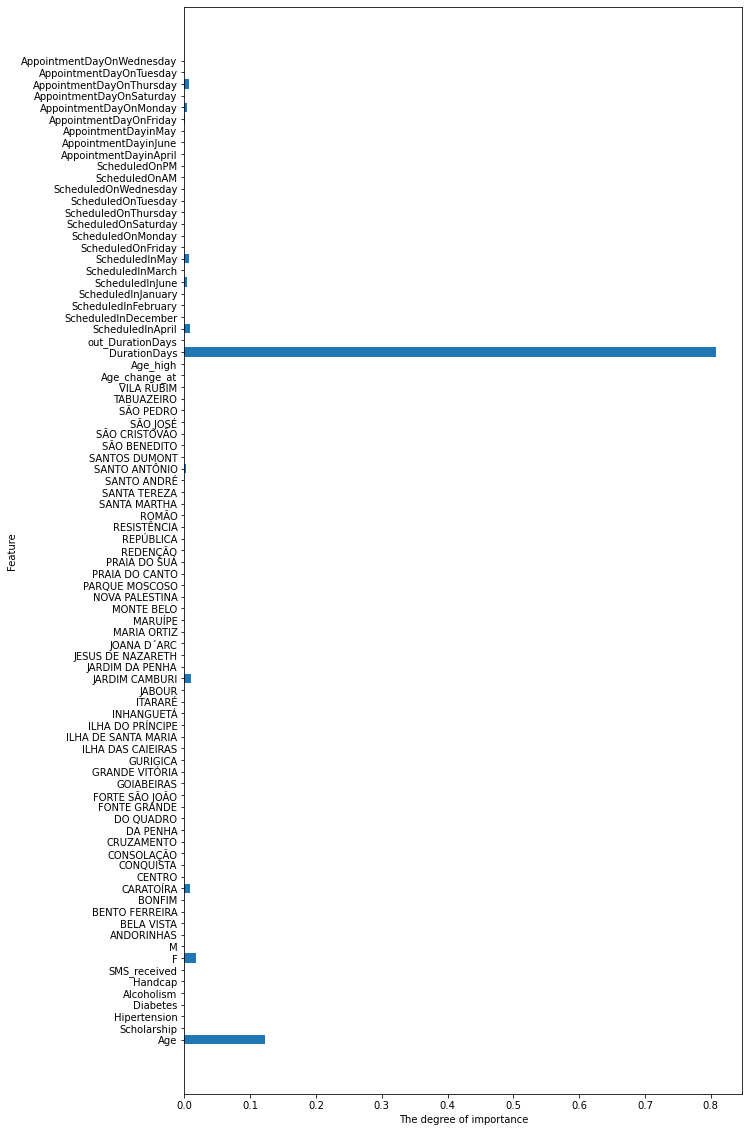

In [135]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), decision_tree_full_fit.feature_importances_, align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

According to Decision Tree Classifier, most explanatory variables did not prove important in predicting which customers are likely to not show up for their scheduled appointment. Some, however, are very important. To better understand the graph above, in the code below I will only view variables that had prediction power of at least 10%.

Text(0, 0.5, 'Feature')

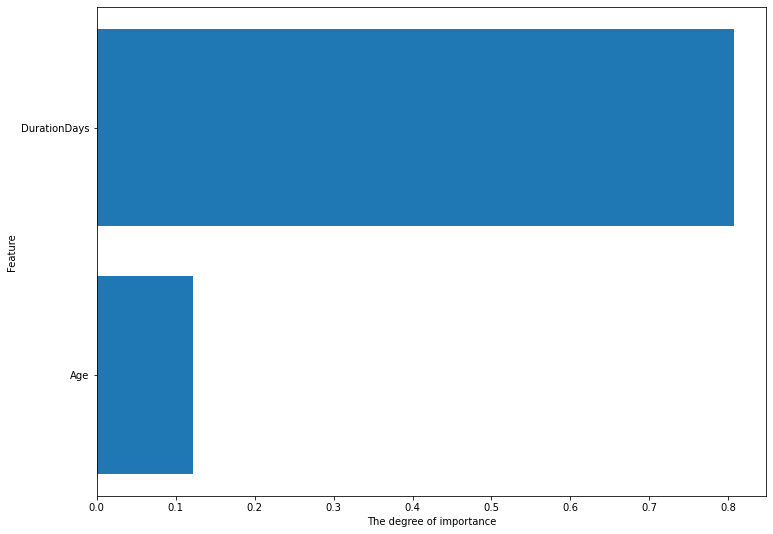

In [136]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = decision_tree_full_fit.feature_importances_>= 0.1

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), decision_tree_full_fit.feature_importances_[features_mask], align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")

Clearly, the DurationDays column proved to be the most important predictor. Specifically, the amount of time that passes between the day an appointment was scheduled and the day of the appointment. During feature engineering process, I created a separate column for outliers of this column that focuses on people who waited a long time to between scheduled day and the day of the appointment. Because of this, the data informs me that <b>customers who book an appointment close to the day of the appointment are likely to miss their visit</b>. 

In the next code block, I will view the exact prediction power of the above variables. 

In [137]:
# Displaying the dictionary
print('Age prediction power:', 
      dict(zip(X_train, decision_tree_full_fit.feature_importances_))['Age'].round(2))
      
print('DurationDays prediction power:', 
      dict(zip(X_train, decision_tree_full_fit.feature_importances_))['DurationDays'].round(2))

Age prediction power: 0.12
DurationDays prediction power: 0.81


According to the data, 81% of the reason why customers don't show up to their scheduled appointment is due to the little time that they allow between the day customers book and the day of the appointment. 

Next, I will save the results of this model.

In [138]:
# Training accuracy
decision_tree_full_train_acc = decision_tree_full_fit.score(X_train, y_train).round(4)

# Testing accuracy
decision_tree_full_test_acc = decision_tree_full_fit.score(X_test, y_test).round(4)

# F1 score
decision_tree_full_f1_score = f1_score(y_test, decision_tree_full_pred).round(4)

# AUC score
decision_tree_full_auc_score = roc_auc_score(y_true = y_test,
                                        y_score =\
                                             decision_tree_full_pred).round(4)

# Saving the results
model_performance.append(['Decision Tree with all explanatory variables',
                          decision_tree_full_train_acc,
                          decision_tree_full_test_acc,
                          decision_tree_full_f1_score,
                          decision_tree_full_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]


##### With GridSearchCV

Now, I will use GridSearchCV to see if it improves the results. 

In [139]:
"""
# Declaring a hyper-parameter space
criterion_space          =   ['gini', 'entropy']
splitter_space           =   ['best', 'random']
max_depth_space          =   pd.np.arange(1, 15)
min_samples_leaf_space   =   pd.np.arange(1, 100)
max_leaf_nodes_space     =   pd.np.arange(2, 22, 5)

# Creating a hyperparameter grid
param_grid = {"criterion"           : criterion_space,
              "splitter"            : splitter_space,
              "max_depth"           : max_depth_space,
              "min_samples_leaf"    : min_samples_leaf_space,
              "max_leaf_nodes"      : max_leaf_nodes_space}

# Instantiating the Decision Tree Classifier
tuned_tree_full = DecisionTreeClassifier(random_state = 331)

# GridSearchCV object
tuned_tree_full_cv = GridSearchCV(estimator   = tuned_tree_full,
                                  param_grid  = param_grid,
                                  cv          = 5, 
                                  scoring     = make_scorer(roc_auc_score,
                                                       needs_threshold = False))

# Fitting to the full dataset
tuned_tree_full_cv.fit(my_df_data, my_df_target)

# Printing the results
print("Tuned parameters:", tuned_tree_full_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_full_cv.best_score_.round(4))
"""

'\n# Declaring a hyper-parameter space\ncriterion_space          =   [\'gini\', \'entropy\']\nsplitter_space           =   [\'best\', \'random\']\nmax_depth_space          =   pd.np.arange(1, 15)\nmin_samples_leaf_space   =   pd.np.arange(1, 100)\nmax_leaf_nodes_space     =   pd.np.arange(2, 22, 5)\n\n# Creating a hyperparameter grid\nparam_grid = {"criterion"           : criterion_space,\n              "splitter"            : splitter_space,\n              "max_depth"           : max_depth_space,\n              "min_samples_leaf"    : min_samples_leaf_space,\n              "max_leaf_nodes"      : max_leaf_nodes_space}\n\n# Instantiating the Decision Tree Classifier\ntuned_tree_full = DecisionTreeClassifier(random_state = 331)\n\n# GridSearchCV object\ntuned_tree_full_cv = GridSearchCV(estimator   = tuned_tree_full,\n                                  param_grid  = param_grid,\n                                  cv          = 5, \n                                  scoring     = make_scor

Now that I have my best parameters, I will plug them into the model and analyze its fit to the data using training and testing accuracies.

In [140]:
# Instantiating Decision Tree Classifier
decision_tree_full_tuned = DecisionTreeClassifier(criterion        = 'entropy',
                                                  max_depth        = 6,
                                                  max_leaf_nodes   = 17,
                                                  min_samples_leaf = 52,
                                                  splitter         = 'best',
                                                  class_weight     = weight,
                                                  random_state     = 331)

# Fitting the training data
decision_tree_full_tuned_fit = decision_tree_full_tuned.fit(X_train, y_train)

# Predicting on the test data
decision_tree_full_tuned_pred = decision_tree_full_tuned_fit.predict(X_test)

# Scoring the model
print("Training accuracy:", 
      decision_tree_full_tuned_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", 
      decision_tree_full_tuned_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6277
Testing accuracy: 0.6216


Both training and testing accuracies are within 0.05 of one another, meaning that this model is neither under-fit nor over-fit. Next, I will analyze the F-1 score of this model. 

In [141]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, decision_tree_full_tuned_pred).round(4))

F1 score: 0.4459


The F-1 score is still low, but it slightly improved from the previous model in which I did not utilize hyperparameter tuning. Next, I will evaluate the confusion matrix of this model.

In [142]:
# Creating a confusion matrix data frame
decision_tree_full_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = decision_tree_full_tuned_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
decision_tree_full_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1073,758
Actual No-show,107,348


Interestingly, my True Positive prediction went down while True Negative prediction went up. Overall, this model makes less mistakes, but it is not as effective in predicting my True Positives, which I care about the most. 

Next, I will evaluate the AUC value of this model.

In [143]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = decision_tree_full_tuned_pred)

0.6754268669615474

The AUC value of this model is slightly better than of the prior model where I did not use GridSearchCV. Altogether, both models are close in their performance, with slight edge to this model given its higher F1 and AUC values.

Next, I am interested in seeing if feature importance changed after hyperparameter tuning. Therefore, in the next code block I will analyze what features proved to be the best predictors. 

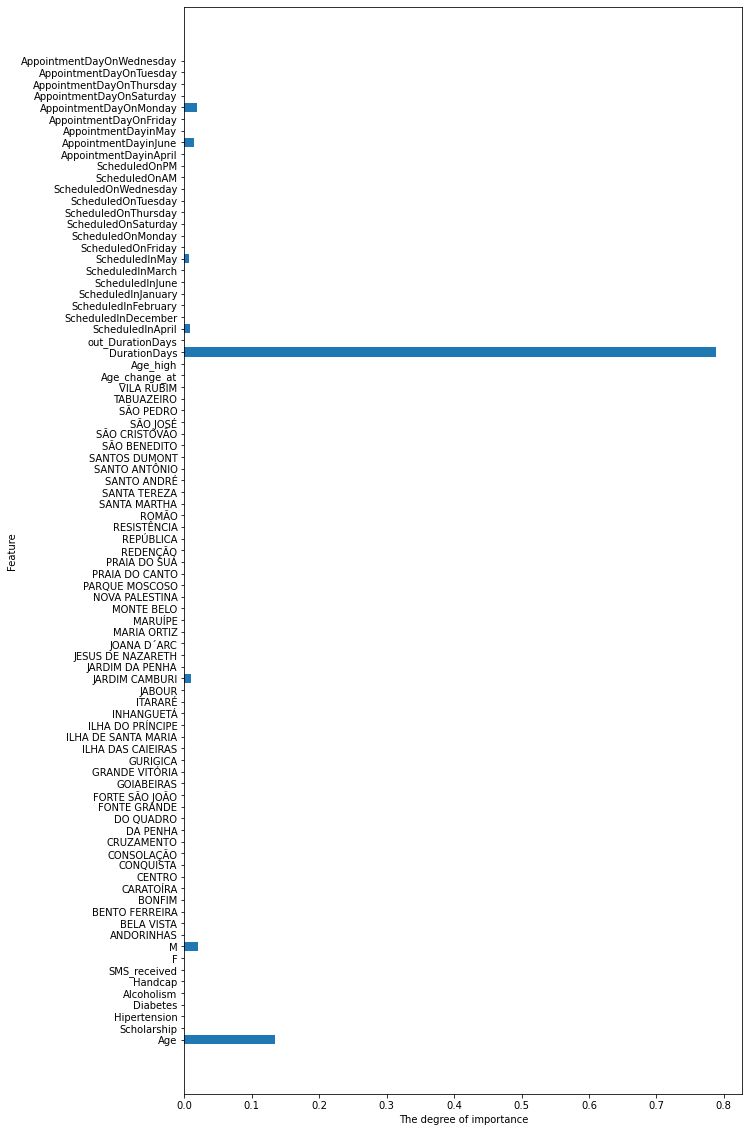

In [144]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), decision_tree_full_tuned_fit.feature_importances_, align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

To simplify the visual analysis, I will next only show features that had at least 10% of prediction power in determining which customers are likely to miss their scheduled appointment.

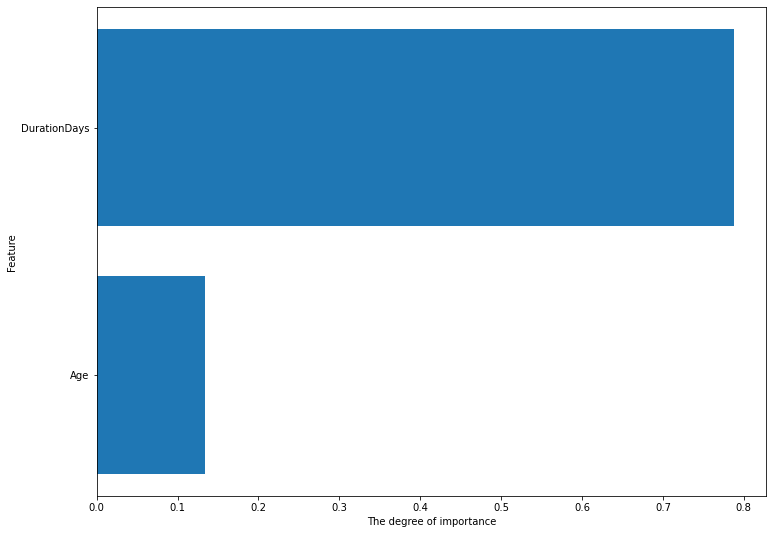

In [145]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = decision_tree_full_tuned_fit.feature_importances_>= 0.1

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), decision_tree_full_tuned_fit.feature_importances_[features_mask], align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

As expected, the same features proved to be the most important, and by very similar percentage. Lastly, I will save the results of this model

In [146]:
# Training accuracy
decision_tree_full_tuned_train_acc = decision_tree_full_tuned_fit.score(X_train, y_train).round(4)

# Testing accuracy
decision_tree_full_tuned_test_acc = decision_tree_full_tuned_fit.score(X_test, y_test).round(4)

# F1 score
decision_tree_full_tuned_f1_score = f1_score(y_test, decision_tree_full_tuned_pred).round(4)

# AUC score
decision_tree_full_tuned_auc_score = roc_auc_score(y_true = y_test,
                                        y_score =\
                                    decision_tree_full_tuned_pred).round(4)

# Saving the results
model_performance.append(['Tuned Decision Tree with all explanatory variables',
                          decision_tree_full_tuned_train_acc,
                          decision_tree_full_tuned_test_acc,
                          decision_tree_full_tuned_f1_score,
                          decision_tree_full_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]


___

#### Decision Tree Classifier with significant variables

##### Without GridSearchCV

Next, I will explore the performance of Decision Tree Classifier using only significant variables.

In the next code block I will segment my data appropriately to only work with significant variables.

In [147]:
# Segmenting the data
my_df_data_sig    = my_df.loc[ :, variables['sig']]
my_df_target      = my_df.loc[ :, 'Outcome']

Next, I will re-instantiate train-test split to work with relevant data.

In [148]:
# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_sig,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

In the next code I will use the <i>class_weight</i> argument defined before during the Logistic Regression analysis to specify weights. This will improve performance of my Decision Tree Classifier. I will also tune certain hyper-parameters to prevent the tree from growing too much

In [149]:
# Instantiating Decision Tree Classifier
decision_tree_sig = DecisionTreeClassifier(max_depth = 5,
                                           min_samples_leaf = 25,
                                           class_weight = weight,
                                           random_state = 331)

# Fitting the training data
decision_tree_sig_fit = decision_tree_sig.fit(X_train, y_train)

# Predicting on the test data
decision_tree_sig_pred = decision_tree_sig_fit.predict(X_test)

# Scoring the model
print("Training accuracy:", decision_tree_sig_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", decision_tree_sig_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6734
Testing accuracy: 0.6623


The decision tree is neither over-fit nor under-fit. Even though training and testing accuracies are low, since this is an imbalanced classification problem testing accuracy doesn't indicate actual prediction accuracy for my class of interest.

In the next code block, I will analyze the F1 score of this model.

In [150]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, decision_tree_sig_pred).round(4))

F1 score: 0.4222


The F1 score of this tree is low. Next, I will evaluate its confusion matrix.

In [151]:
# Creating a confusion matrix data frame
decision_tree_sig_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = decision_tree_sig_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
decision_tree_sig_cm

,Predicted to show up,Predicted No-show
Actually showed up,1232,599
Actual No-show,173,282


The confusion matrix looks okay for this un-tuned model. In my y_test, there are 455 cases in which customers did not show up for their appointment. The current model correctly predicted 282 such cases. This may improve when I will use GridSearchCV to fine tune my Decision Tree model. So far, this model is weaker than the model that uses all variables.

In the next code block, I will evaluate the AUC score to determine the baseline against which I will compare tuned Decision Tree Classifier later. 

In [152]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = decision_tree_sig_pred)

0.6463182912117921

My AUC score is 0.6463, which is one of the best AUC scores I have so far. This will be my baseline for later when I fine-tune Decision Tree Classifier using GridSearchCV.

One of the very useful tools available to analyze Decision Trees is feature importance graph. This feature allows me to understand the most important explanatory variables that play the biggest role in predicting my response variable. 

In the next code block, I will display the feature importances plot to understand which features contribute the most to predicting which customers are likely to not show up for appointment.

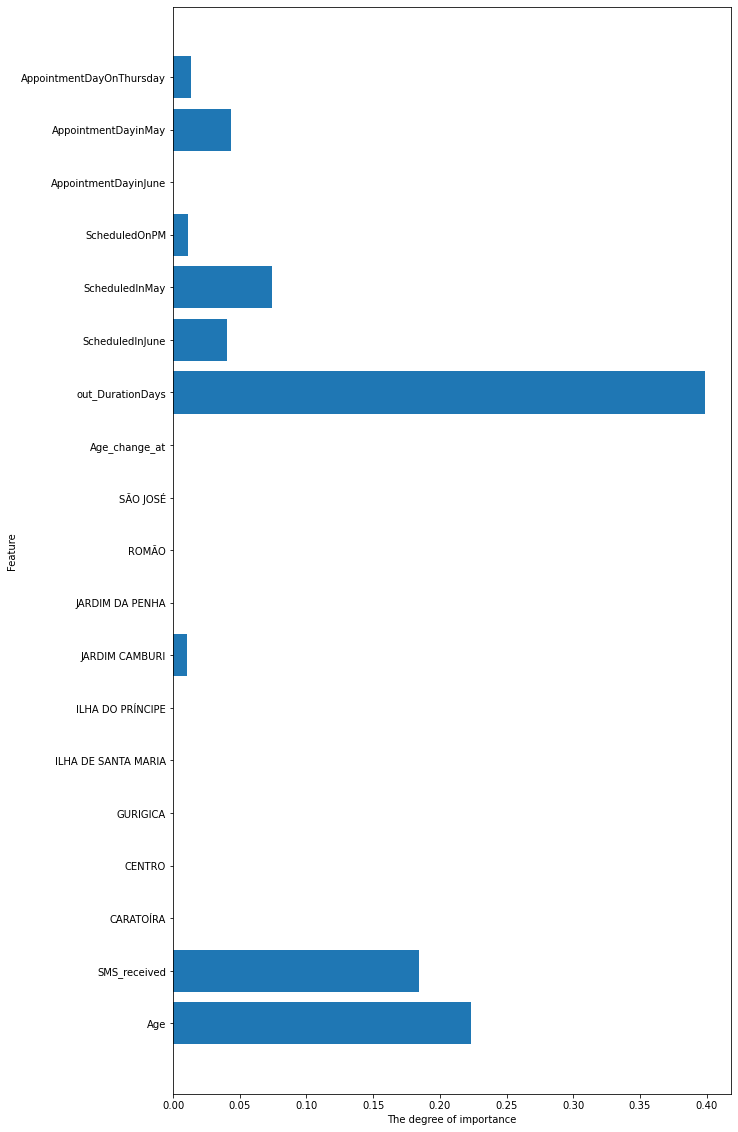

In [153]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), decision_tree_sig_fit.feature_importances_, align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

From the graph above, I see that out_DurationDays, Age, and SMS_received are the strongest predictors in determining which customers are likely to not show up for their scheduled appointment, according to DecisionTreeClassifier. On the x-axis, the graph above shows the importance of each feature as a % value of their predictive power.

In the next code block, I will polish the above visual to only display features whose predicting power is at or above 10%.

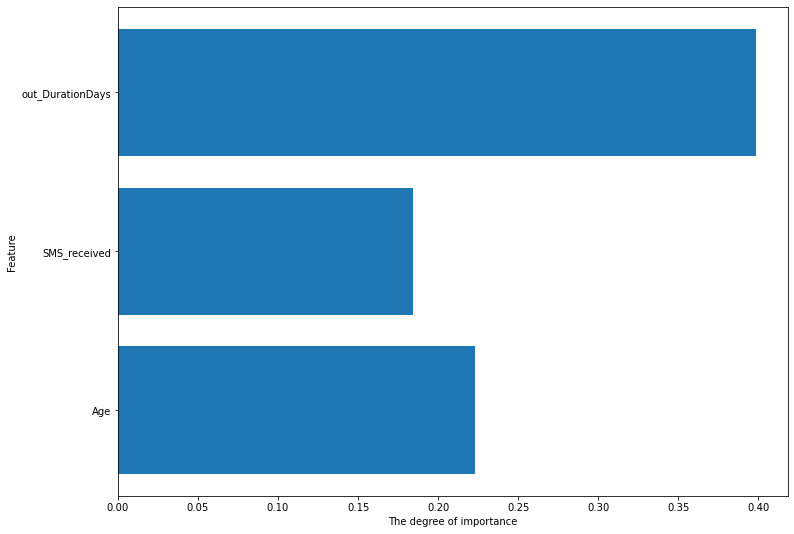

In [154]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = decision_tree_sig_fit.feature_importances_>= 0.1

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), decision_tree_sig_fit.feature_importances_[features_mask], align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

From the updated visual, I notice that 'Age' and 'DurationDays' column are the only significant predictors for Decision Tree Classifier.

In the next code block, I will explore the exact value for each of these 3 features, displayed as a % of its predictive power in determining which customers are likely to not show up for their scheduled appointment, according to Decision Tree Classifier.

In [155]:
# Displaying the dictionary
print('out_DurationDays prediction power:', 
      dict(zip(X_train.columns, decision_tree_sig_fit.feature_importances_))\
      ['out_DurationDays'].round(2))

print('SMS_received prediction power:', 
      dict(zip(X_train.columns, decision_tree_sig_fit.feature_importances_))\
      ['SMS_received'].round(2))

print('Age prediction power:', 
      dict(zip(X_train.columns, decision_tree_sig_fit.feature_importances_))\
      ['Age'].round(2))

out_DurationDays prediction power: 0.4
SMS_received prediction power: 0.18
Age prediction power: 0.22


From the output above, I now know that for Decision Tree Classifier:
- 'out_DurationDays' feature explains about 40% of possible reason why customers don't show up to their scheduled appointment
- 'Age' feature explains about 22% of possible reason why customers don't show up to their scheduled appointment. 
- 'SMS_received' explain about 18% of possible reason why customers don't show up to their scheduled appointment

Interestingly, since DurationDays column is not one of the variables in the significant variables set, out_DurationDays shows as the most important variable. To me, this says that even in the absence of DurationDays column, this information is still the most important in determining which customers are likely to not show up for their scheduled appointment.

Before proceeding to the next step, I will save the results of this model.

In [156]:
# Training accuracy
decision_tree_sig_train_acc = decision_tree_sig_fit.score(X_train, y_train).round(4)

# Testing accuracy
decision_tree_sig_test_acc = decision_tree_sig_fit.score(X_test, y_test).round(4)

# F1 score
decision_tree_sig_f1_score = f1_score(y_test, decision_tree_sig_pred).round(4)

# AUC score
decision_tree_sig_auc_score = roc_auc_score(y_true = y_test,
                                        y_score =\
                                            decision_tree_sig_pred.round(4))

# Saving the results
model_performance.append(['Decision Tree with significant variables',
                          decision_tree_sig_train_acc,
                          decision_tree_sig_test_acc,
                          decision_tree_sig_f1_score,
                          decision_tree_sig_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]


##### With GridSearchCV

Next, I will fine tune my Decision Tree Classifier using the GridSearchCV.

In [157]:
"""
# Declaring a hyper-parameter space
criterion_space          =   ['gini', 'entropy']
splitter_space           =   ['best', 'random']
max_depth_space          =   pd.np.arange(1, 25)
min_samples_leaf_space   =   pd.np.arange(1, 100)
max_leaf_nodes_space     =   pd.np.arange(2, 22, 5)

# Creating a hyperparameter grid
param_grid = {"criterion"           : criterion_space,
              "splitter"            : splitter_space,
              "max_depth"           : max_depth_space,
              "min_samples_leaf"    : min_samples_leaf_space,
              "max_leaf_nodes"      : max_leaf_nodes_space}

# Instantiating the Decision Tree Classifier
decision_tree_sig_tuned = DecisionTreeClassifier(random_state = 331)

# GridSearchCV object
decision_tree_sig_tuned_cv = GridSearchCV(estimator   = decision_tree_sig_tuned,
                             param_grid  = param_grid,
                             cv          = 5, 
                             scoring     = make_scorer(roc_auc_score,
                                                       needs_threshold = False))

# Fitting to the full dataset
decision_tree_sig_tuned_cv.fit(my_df_data, my_df_target)

# Printing the results
print("Tuned parameters:", decision_tree_sig_tuned_cv.best_params_)
print("Tuned Training AUC:", decision_tree_sig_tuned_cv.best_score_.round(4))
"""

'\n# Declaring a hyper-parameter space\ncriterion_space          =   [\'gini\', \'entropy\']\nsplitter_space           =   [\'best\', \'random\']\nmax_depth_space          =   pd.np.arange(1, 25)\nmin_samples_leaf_space   =   pd.np.arange(1, 100)\nmax_leaf_nodes_space     =   pd.np.arange(2, 22, 5)\n\n# Creating a hyperparameter grid\nparam_grid = {"criterion"           : criterion_space,\n              "splitter"            : splitter_space,\n              "max_depth"           : max_depth_space,\n              "min_samples_leaf"    : min_samples_leaf_space,\n              "max_leaf_nodes"      : max_leaf_nodes_space}\n\n# Instantiating the Decision Tree Classifier\ndecision_tree_sig_tuned = DecisionTreeClassifier(random_state = 331)\n\n# GridSearchCV object\ndecision_tree_sig_tuned_cv = GridSearchCV(estimator   = decision_tree_sig_tuned,\n                             param_grid  = param_grid,\n                             cv          = 5, \n                             scoring     = 

Now that I have my tuned hyper-parameters, I will next test Decision Tree Classifier with this updated information.

In [158]:
# Instantiating Decision Tree Classifier
decision_tree_sig_tuned = DecisionTreeClassifier(criterion = 'entropy',
                                                 max_depth = 6,
                                                 max_leaf_nodes = 17,
                                                 min_samples_leaf = 52,
                                                 splitter = 'best',
                                                 class_weight = weight,
                                                 random_state = 331)

# Fitting the training data
decision_tree_sig_tuned_fit = decision_tree_sig_tuned.fit(X_train, y_train)

# Predicting on the test data
decision_tree_sig_tuned_pred = decision_tree_sig_tuned_fit.predict(X_test)

# Scoring the model
print("Training accuracy:", 
      decision_tree_sig_tuned_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", 
      decision_tree_sig_tuned_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6608
Testing accuracy: 0.6496


The model is still neither under-fit nor over-fit, and since this is a classification problem, testing score doesn't show the actual prediction power. Next, I will evaluate the F1 score. 

In [159]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, decision_tree_sig_tuned_pred).round(4))

F1 score: 0.4242


The F1 score is almost the same, just slightly better compared to un-tuned decision tree. Next, I will explore the confusion matrix.

In [160]:
# Creating a confusion matrix data frame
decision_tree_sig_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = decision_tree_sig_tuned_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
decision_tree_sig_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1190,641
Actual No-show,160,295


For the purpose of my business question - which customers are likely to not show up for their scheduled appointment - this confusion matrix looks better. In predicting which customers are likely to not show up for their scheduled appointment, Tuned Decision Tree correctly predicts 295 times out of 455 times. So far, this is the best performing model.

Next, I will analyze the AUC score.

In [161]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = decision_tree_sig_tuned_pred)

0.6491348629524489

The AUC value only improved slightly. Conclusively, my model did improve by just a little bit, with the exception of confusion matrix, where the performance improved significantly.

Next, I will analyze which features proved to be most valuable in predicting which customers are likely to not show up for their scheduled appointment.

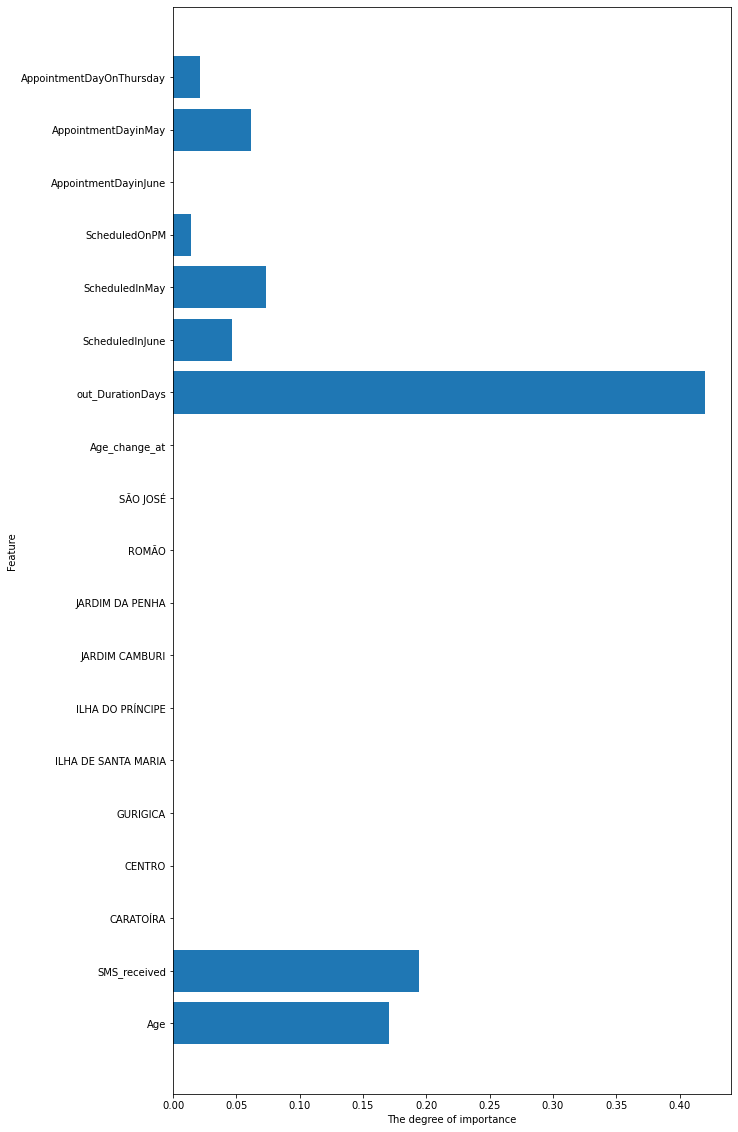

In [162]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), decision_tree_sig_tuned_fit.feature_importances_, align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

The graph slightly changes from the first decision tree model. Specifically, it appears I  have 3 features that are  most important in predicting which customers are likely to not show up for their scheduled appointment, and the out_DurationDays appears to be a very important predictor.

The visual above includes a lot of noise. In the next code block, I will polish the above visual to only display features that have predicting power of 10% or more.

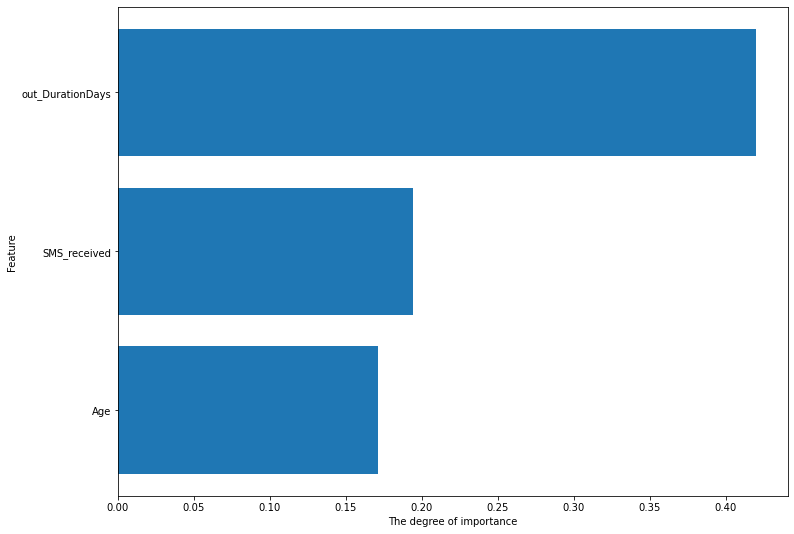

In [163]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = decision_tree_sig_tuned_fit.feature_importances_>= 0.1

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), decision_tree_sig_tuned_fit.feature_importances_[features_mask], align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

'out_DurationDays', 'SMS_received', and 'Age' columns are the 3 predictors with most significant predictive power. Next, I will analyze their exact prediction power.

In [164]:
# Displaying the dictionary
print('out_DurationDays prediction power:', dict(zip(X_train.columns, 
               decision_tree_sig_tuned_fit.feature_importances_))\
      ['out_DurationDays'].round(2))

print('SMS_received prediction power:', dict(zip(X_train.columns, 
               decision_tree_sig_tuned_fit.feature_importances_))\
      ['SMS_received'].round(2))

print('Age prediction power:', dict(zip(X_train.columns, 
               decision_tree_sig_tuned_fit.feature_importances_))\
      ['Age'].round(2))

out_DurationDays prediction power: 0.42
SMS_received prediction power: 0.19
Age prediction power: 0.17


As I assumed, only 3 features have significant predictive power in case of Tuned Decision Tree:
- 'Age' explains about 17% of the reason why customers don't show up for their scheduled appointment
- 'out_DurationDays' explains about 42% of why customers are likely to not show up for their scheduled appointment
- 'SMS_received' explains about 19% of why customers are likely to not arrive for their scheduled appointment.

In the next code block, I will save the results of this model to compare against other models later. 

In [165]:
# Training accuracy
decision_tree_sig_tuned_train_acc =\
decision_tree_sig_tuned_fit.score(X_train, y_train).round(4)

# Testing accuracy
decision_tree_sig_tuned_test_acc =\
decision_tree_sig_tuned_fit.score(X_test, y_test).round(4)

# F1 score
decision_tree_sig_tuned_f1_score =\
f1_score(y_test, decision_tree_sig_tuned_pred).round(4)

# AUC score
decision_tree_sig_tuned_auc_score = roc_auc_score(y_true = y_test,
                                     y_score =\
                                      decision_tree_sig_tuned_pred).round(4)

# Saving the results
model_performance.append(['Tuned Decision Tree with signifiant variables',
                          decision_tree_sig_tuned_train_acc,
                          decision_tree_sig_tuned_test_acc,
                          decision_tree_sig_tuned_f1_score,
                          decision_tree_sig_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

___

#### Random Forest Classifier with all explanatory variables

##### Without GridSearchCV

Before analyzing this model, my first step is to segment my data so that I am working with all explanatory variables

In [166]:
# Segmenting the data
my_df_data_full    = my_df.loc[ :, variables['full']]
my_df_target       = my_df.loc[ :, 'Outcome']

Next, I will re-instantiate my train-test-split function to make sure I am working with the right data.

In [167]:
# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_full,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

Next, I will analyze the training and testing accuracy of this model using hand-picked hyperparameter values. Training and testing accuracies will help me understand whether the model is under-fit or over-fit.

To account for the imbalanced classificaiton, Random Forest Classifier has an argument <i>class_weight</i>. It works slightly differently than in case of Decision Tree Classifier. Here, instead of explicitly specifying the class imbalance, I will supply <i></i> argument with value 'balanced'. This will automatically use the inverse weighting and prioritize the minority class.

In [168]:
# Instantiating Random Forest Classifier
random_forest_full = RandomForestClassifier(n_estimators = 35,
                                            criterion = 'gini',
                                            max_depth = 8,
                                            min_samples_leaf = 1,
                                            bootstrap = True,
                                            warm_start = False,
                                            class_weight = 'balanced',
                                            random_state = 331)

# Fitting the model on the training data
random_forest_full_fit = random_forest_full.fit(X_train, y_train)

# Predicitng on the test set
random_forest_full_pred = random_forest_full_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", random_forest_full_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", random_forest_full_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6643
Testing accuracy: 0.6159


The model is neither under-fit nor over-fit, given that training and testing accuracies are within 0.05 of one another. Next, I will evaluate the F1 score of this model.

In [169]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, random_forest_full_pred).round(4))

F1 score: 0.4485


The F-1 score is low, and in the next code block I will analyze the confusion matrix of this model.

In [170]:
# Creating a confusion matrix data frame
random_forest_full_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = random_forest_full_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
random_forest_full_cm

,Predicted to show up,Predicted No-show
Actually showed up,1051,780
Actual No-show,98,357


The confusion matrix for this model is decent. It does relatively well in predicting information I am most interested in, and more often than not it correctly predicts which customers will show up. Next, I will analyze the AUC value for this model.

In [171]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = random_forest_full_pred)

0.6793093307566272

This AUC value is not great, but so far it is the best one I have. To learn more about this model, I will next plot feature importances to understand which specific features does this model rely on the most to predict which customers are likely to not show up for their scheduled appointment.

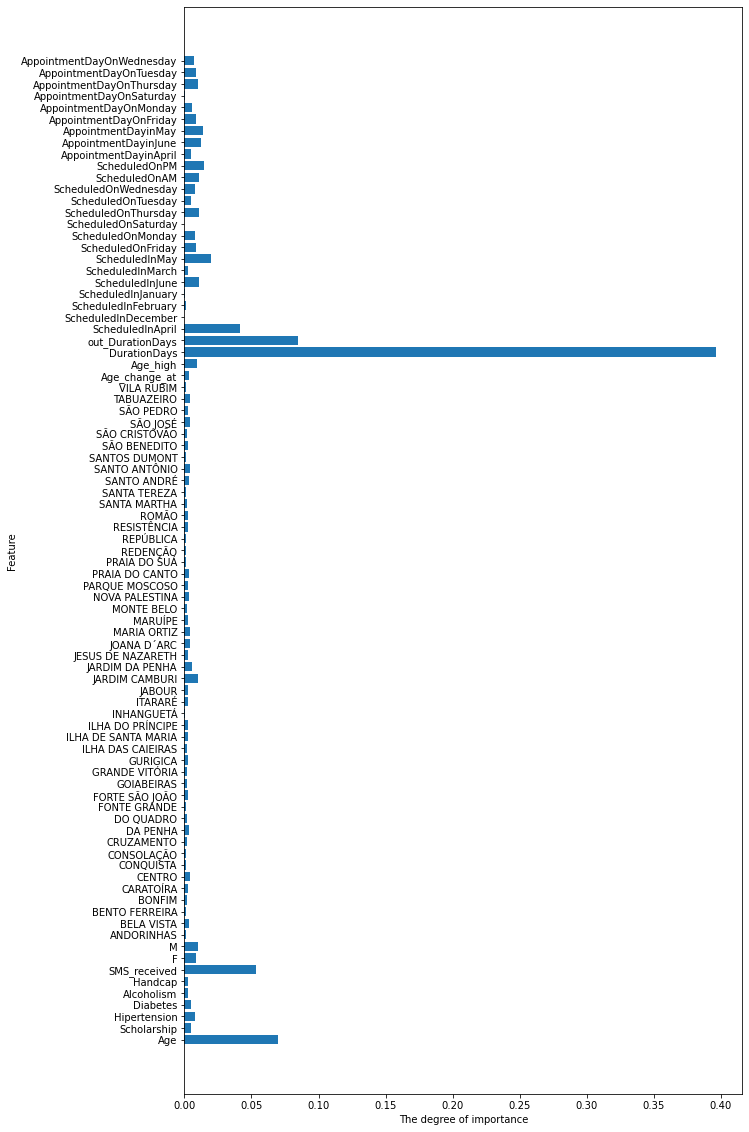

In [172]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         random_forest_full_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

In this model, DurationDays is the most important predictor, followed by several others who are similar to one another in prediction power. To make this visual more readable, in the next code block I will only show variables that have at least 5% of prediction power.

Text(0, 0.5, 'Feature')

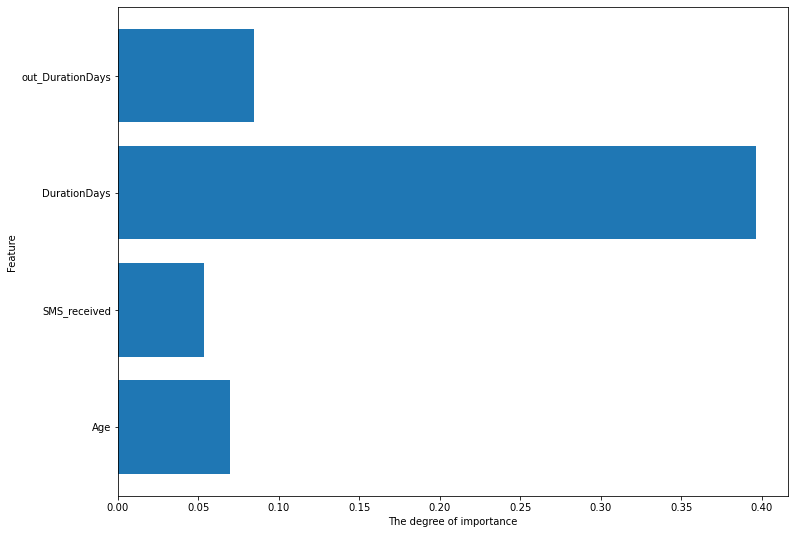

In [173]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = random_forest_full_fit.feature_importances_>= 0.05

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), 
         random_forest_full_fit.feature_importances_[features_mask], 
         align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")

The above 4 variables are the strongest predictors, according to the Random Forest Classifier model. In the next code block, I will evaluate their exact prediction power.

In [174]:
# Displaying the dictionary
print('DurationDays prediction power:', 
      dict(zip(X_train, random_forest_full_fit.feature_importances_))\
      ['DurationDays'].round(2))

print('out_Duration_Days prediction power:', 
      dict(zip(X_train, random_forest_full_fit.feature_importances_))\
      ['out_DurationDays'].round(2))

print('Age prediction power:', 
      dict(zip(X_train, random_forest_full_fit.feature_importances_))\
      ['Age'].round(2))

print('SMS_received prediction power:', 
      dict(zip(X_train, random_forest_full_fit.feature_importances_))\
      ['SMS_received'].round(2))

DurationDays prediction power: 0.4
out_Duration_Days prediction power: 0.08
Age prediction power: 0.07
SMS_received prediction power: 0.05


According to Random Forest Classifier:

- The time that passes between the day an appointment is scheduled and the day of appointment explains 40% of the reason why customers do not show up for their scheduled appointment.
- When significantly more time than average passes between the day an appointment was scheduled on and the day of appointment, the unusually longer time between 2 dates explains 8% of the reason customers miss their appointment. 
- The age of customers explains 7% of the reason why customers may miss their appointment.
- Whether customers receive an SMS confirmation explains 5% of the reason why customers may miss their scheduled appointment. 

Before proceeding with analyzing this model with GridSearchCV, in the next code block I will save the results.

In [175]:
# Training accuracy
random_forest_full_train_acc = random_forest_full_fit.score(X_train, y_train).round(4)

# Testing accuracy
random_forest_full_test_acc = random_forest_full_fit.score(X_test, y_test).round(4)

# F1 score
random_forest_full_f1_score = f1_score(y_test, random_forest_full_pred).round(4)

# AUC score
random_forest_full_auc_score = roc_auc_score(y_true = y_test,
                                        y_score =\
                                    random_forest_full_pred).round(4)

# Saving the results
model_performance.append(['Random Forest with all explanatory variables',
                          random_forest_full_train_acc,
                          random_forest_full_test_acc,
                          random_forest_full_f1_score,
                          random_forest_full_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

##### With GridSearchCV

Next, I will run GridSearchCV to analyze the best hyperparameters for this model.

In [176]:
"""
# Declaring a hyper-parameter space
n_estimators_space       = pd.np.arange(100, 1100, 200)
min_samples_leaf_space   = pd.np.arange(1, 51, 10)
criterion_space          = ['gini', 'entropy']
bootstrap_space          = [True, False]
warm_start_space         = [True, False]

# Creating a hyper-parameter grid
param_grid = {'n_estimators'     : n_estimators_space,
              'min_samples_leaf' : min_samples_leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}

# Instantiating the Random Forest Classifier model
random_forest_full_tuned = RandomForestClassifier(random_state = 331)

# GridSearchCV object
random_forest_full_tuned_cv = GridSearchCV(estimator = random_forest_full_tuned,
                                           param_grid = param_grid,
                                           cv = 5,
                                           scoring = make_scorer(roc_auc_score,
                                                                 needs_threshold = False))

# Fitting to the full data set
random_forest_full_tuned_cv.fit(my_df_data, my_df_target)

# Printing the results
print("Tuned parameters:", random_forest_full_tuned_cv.best_params_)
print("Tuned training AUC:", random_forest_full_tuned_cv.best_score_.round(4))
"""

'\n# Declaring a hyper-parameter space\nn_estimators_space       = pd.np.arange(100, 1100, 200)\nmin_samples_leaf_space   = pd.np.arange(1, 51, 10)\ncriterion_space          = [\'gini\', \'entropy\']\nbootstrap_space          = [True, False]\nwarm_start_space         = [True, False]\n\n# Creating a hyper-parameter grid\nparam_grid = {\'n_estimators\'     : n_estimators_space,\n              \'min_samples_leaf\' : min_samples_leaf_space,\n              \'criterion\'        : criterion_space,\n              \'bootstrap\'        : bootstrap_space,\n              \'warm_start\'       : warm_start_space}\n\n# Instantiating the Random Forest Classifier model\nrandom_forest_full_tuned = RandomForestClassifier(random_state = 331)\n\n# GridSearchCV object\nrandom_forest_full_tuned_cv = GridSearchCV(estimator = random_forest_full_tuned,\n                                           param_grid = param_grid,\n                                           cv = 5,\n                                       

Now that I have my hyperparameter values, I will plug them into the model below. First, I will evaluate the accuracy just to make sure the model is neither under-fit nor over-fit.

In [177]:
# Instantiating Random Forest Classifier
random_forest_full_tuned = RandomForestClassifier(n_estimators = 900,
                                                  criterion = 'entropy',
                                                  max_depth = 8,
                                                  min_samples_leaf = 1,
                                                  bootstrap = False,
                                                  warm_start = False,
                                                  class_weight = 'balanced',
                                                  random_state = 331)

# Fitting the model on the training data
random_forest_full_tuned_fit = random_forest_full_tuned.fit(X_train, y_train)

# Predicitng on the test set
random_forest_full_tuned_pred = random_forest_full_tuned_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", 
      random_forest_full_tuned_fit.score(X_train, y_train).round(4))
print("Testing accuracy:",  
      random_forest_full_tuned_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6603
Testing accuracy: 0.6107


According to the values above, the model is neither under-fit nor overfit. Next, I will analyze its F1 score. 

In [178]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, random_forest_full_tuned_pred).round(4))

F1 score: 0.4465


The F1 score is still low, and even slightly lower than before. Next, I will analyze the confusion matrix of this model.

In [179]:
# Creating a confusion matrix data frame
random_forest_full_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = random_forest_full_tuned_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
random_forest_full_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1037,794
Actual No-show,96,359


The confusion matrix is almost the same as before. Next, I will look at the AUC value.

In [180]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = random_forest_full_tuned_pred)

0.6776840854394104

The AUC value is slightly lower than before. So far, I assume that feature importances will look the same. Nevertheless, in the next code block I will analyze which features are strongest predictors. 

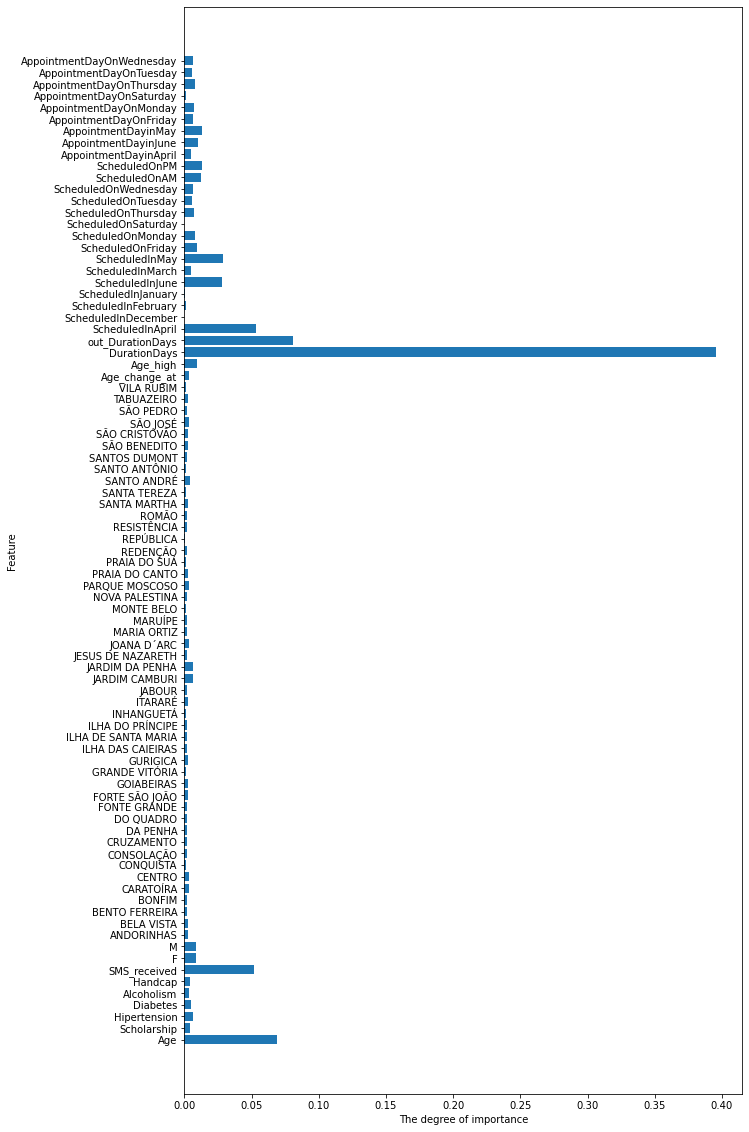

In [181]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         random_forest_full_tuned_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

For a better visual, I will limit the graph above to only view features that had at least 5% of prediction power.

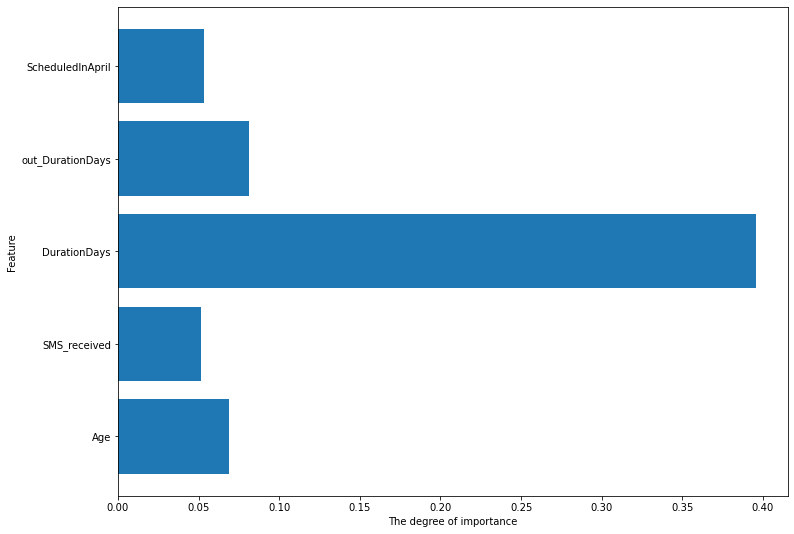

In [182]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = random_forest_full_tuned_fit.feature_importances_>= 0.05

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), 
         random_forest_full_tuned_fit.feature_importances_[features_mask], 
         align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

Feature importances are very similar to un-tuned model. Lastly, I will save the results of this model.

In [183]:
# Training accuracy
random_forest_full_tuned_train_acc =\
random_forest_full_tuned_fit.score(X_train, y_train).round(4)

# Testing accuracy
random_forest_full_tuned_test_acc =\
random_forest_full_tuned_fit.score(X_test, y_test).round(4)

# F1 score
random_forest_full_tuned_f1_score =\
f1_score(y_test, random_forest_full_tuned_pred).round(4)

# AUC score
random_forest_full_tuned_auc_score =\
roc_auc_score(y_true = y_test, 
              y_score = random_forest_full_tuned_pred).round(4)

# Saving the results
model_performance.append([
    'Tuned Random Forest Classifier will all explanatory variables',
     random_forest_full_tuned_train_acc,
     random_forest_full_tuned_test_acc,
     random_forest_full_tuned_f1_score,
    random_forest_full_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

___

#### Random Forest Classifier with significant variables

##### Without GridSearchCV

Now, I will explore Random Forest Classifier using only significant variables.

Before using GridSearchCV to fine-tune Random Forest Classifier, I will first analyze its performance using hand-selected parameters and values. As the first step, I will segment my data appropriately to only use significant variables.

In [184]:
# Segmenting the data
my_df_data_sig     = my_df.loc[ :, variables['sig']]
my_df_target       = my_df.loc[ :, 'Outcome']

Next, I will re-declare my train test split function to ensure it includes training set with only significant variables. 

In [185]:
# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_sig,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

Next, I will analyze this model's performance using hand-picked values for hyper-parameters.

In [186]:
# Instantiating Random Forest Classifier
random_forest_sig = RandomForestClassifier(n_estimators = 35,
                                           criterion = 'gini',
                                           max_depth = 8,
                                           min_samples_leaf = 1,
                                           bootstrap = True,
                                           warm_start = False,
                                           class_weight = 'balanced',
                                           random_state = 331)

# Fitting the model on the training data
random_forest_sig_fit = random_forest_sig.fit(X_train, y_train)

# Predicitng on the test set
random_forest_sig_pred = random_forest_sig_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", 
      random_forest_sig_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", 
      random_forest_sig_fit.score(X_test, y_test).round(4))

Training accuracy: 0.7199
Testing accuracy: 0.6794


Both scores are at above 65%, which is a promising start, and the model is neither over-fit nor under-fit. Testing accuracy doesn't matter here due to the class imbalance.

In the next code block, I will explore the F1 score of the Random Forest Classifier.

In [187]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, random_forest_sig_pred).round(4))

F1 score: 0.4122


The F1 score is still low. Next, I will evaluate the confusion matrix.

In [188]:
# Creating a confusion matrix data frame
random_forest_sig_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = random_forest_sig_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
random_forest_sig_cm

,Predicted to show up,Predicted No-show
Actually showed up,1296,535
Actual No-show,198,257


This model, in general, makes less mistakes than any other model, but it is not as good in predicting True Positives, which is what I am interested in the most. Next, I will analyze the AUC value.

In [189]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = random_forest_sig_pred)

0.636322552379352

The AUC value is okay, but not as good as I want it to be.

Now, I want to understand which features proved the most important for Random Forest Classifier. In the next code block, I will visualize feature importances. 

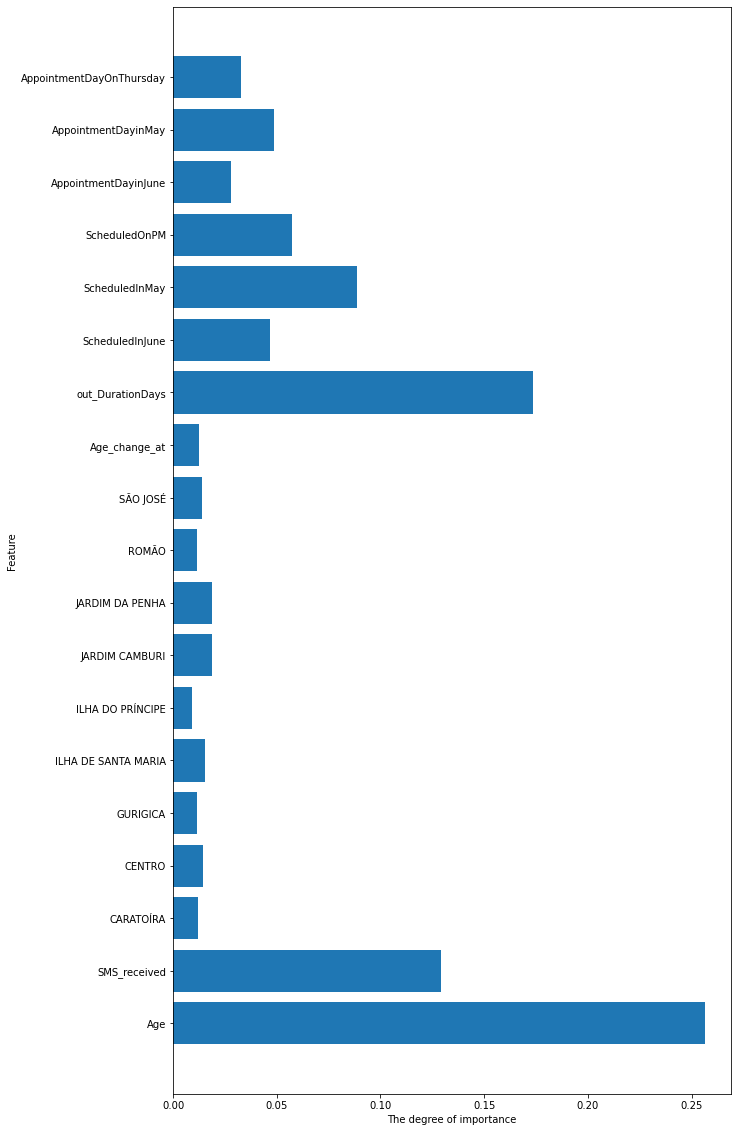

In [190]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         random_forest_sig_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

This plot looks similar to previous plots. However, Random Forest Classifier identifies more, and some new features as important predictors. This visual shows valuable information, but it also contains a lot of irrelevant information. 

In the next code block, I will visualize the feature importances for features that have a predicting power of 10% or more.

Text(0, 0.5, 'Feature')

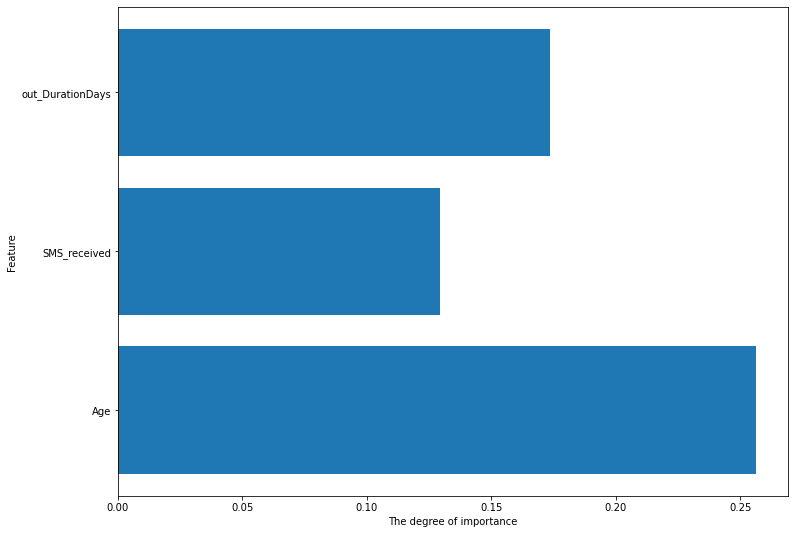

In [191]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = random_forest_sig_fit.feature_importances_>= 0.1

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), 
         random_forest_sig_fit.feature_importances_[features_mask], 
         align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")

The same 3 predictors remained the most important, with slight changes in values. Interestingly, because there is no "DurationDays" column in the significant variables set, Age became the greatest predictor. 

In the next code, I will view the exact prediciton power of each of the above features. 

In [192]:
# Displaying the dictionary
print("Prediction power of Age:", 
      dict(zip(X_train, random_forest_sig_fit.feature_importances_))\
      ['Age'].round(2))

print("Prediction power of out_DurationDays:", 
      dict(zip(X_train, random_forest_sig_fit.feature_importances_))\
      ['out_DurationDays'].round(2))

print("Prediction power of SMS_received:", 
      dict(zip(X_train, random_forest_sig_fit.feature_importances_))\
      ['SMS_received'].round(2))

Prediction power of Age: 0.26
Prediction power of out_DurationDays: 0.17
Prediction power of SMS_received: 0.13


According to Random Forest Classifier, the predicting power distributes among most important features as follows:
- 26% of reason why customers don't show up for their scheduled appointment is explained by customers' Age.
- 17% of the reason is explained by the time that passes between the time an appointment was scheduled and the day of the appointment
- 13% of the reason ins explained by whether customers received an SMS message, assuming SMS confirmation for their scheduled appointment

Next, I will save the results for later comparison.

In [193]:
# Training accuracy
random_forest_sig_train_acc =\
random_forest_sig_fit.score(X_train, y_train).round(4)

# Testing accuracy
random_forest_sig_test_acc =\
random_forest_sig_fit.score(X_test, y_test).round(4)

# F1 score
random_forest_sig_f1_score = f1_score(y_test, 
                                      random_forest_sig_pred).round(4)

# AUC score
random_forest_sig_auc_score = roc_auc_score(
    y_true = y_test,
    y_score = random_forest_sig_pred).round(4)

# Saving the results
model_performance.append([
    'Random Forest Classifier with significant variables',
    random_forest_sig_train_acc,
    random_forest_sig_test_acc,
    random_forest_sig_f1_score,
    random_forest_sig_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

##### With GridSearchCV

Now that results are stored, I will next work on the GridSearchCV

In [194]:
"""
# Declaring a hyper-parameter space
n_estimators_space       = pd.np.arange(100, 1100, 250)
min_samples_leaf_space   = pd.np.arange(1, 31, 10)
criterion_space          = ['gini', 'entropy']
bootstrap_space          = [True, False]
warm_start_space         = [True, False]

# Creating a hyper-parameter grid
param_grid = {'n_estimators'     : n_estimators_space,
              'min_samples_leaf' : min_samples_leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}

# Instantiating the Random Forest Classifier model
random_forest_sig_tuned = RandomForestClassifier(random_state = 331)

# GridSearchCV object
random_forest_sig_tuned_cv =\
GridSearchCV(estimator = random_forest_sig_tuned,
             param_grid = param_grid,
             cv = 5,
             scoring = make_scorer(roc_auc_score,
                                   needs_threshold = False))

# Fitting to the full data set
random_forest_sig_tuned_cv.fit(my_df_data, my_df_target)

# Printing the results
print("Tuned parameters:", random_forest_sig_tuned_cv.best_params_)
print("Tuned training AUC:", random_forest_sig_tuned_cv.best_score_.round(4))
"""

'\n# Declaring a hyper-parameter space\nn_estimators_space       = pd.np.arange(100, 1100, 250)\nmin_samples_leaf_space   = pd.np.arange(1, 31, 10)\ncriterion_space          = [\'gini\', \'entropy\']\nbootstrap_space          = [True, False]\nwarm_start_space         = [True, False]\n\n# Creating a hyper-parameter grid\nparam_grid = {\'n_estimators\'     : n_estimators_space,\n              \'min_samples_leaf\' : min_samples_leaf_space,\n              \'criterion\'        : criterion_space,\n              \'bootstrap\'        : bootstrap_space,\n              \'warm_start\'       : warm_start_space}\n\n# Instantiating the Random Forest Classifier model\nrandom_forest_sig_tuned = RandomForestClassifier(random_state = 331)\n\n# GridSearchCV object\nrandom_forest_sig_tuned_cv =GridSearchCV(estimator = random_forest_sig_tuned,\n             param_grid = param_grid,\n             cv = 5,\n             scoring = make_scorer(roc_auc_score,\n                                   needs_threshold =

Now that I have the best of certain hyper-parameters, I will plug them into my Random Forest Classifier to observe the changes of the model prediction performance.

In [195]:
# Instantiating Random Forest Classifier
random_forest_sig_tuned = RandomForestClassifier(n_estimators = 600,
                                                 criterion = 'gini',
                                                 min_samples_leaf = 1,
                                                 max_depth = 8,
                                                 bootstrap = False,
                                                 warm_start = False,
                                                 class_weight = 'balanced',
                                                 random_state = 331)

# Fitting the model on the training data
random_forest_sig_tuned_fit = random_forest_sig_tuned.fit(X_train, y_train)

# Predicitng on the test set
random_forest_sig_tuned_pred = random_forest_sig_tuned_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", 
      random_forest_sig_tuned_fit.score(X_train, y_train).round(4))
print("Testing accuracy:", 
      random_forest_sig_tuned_fit.score(X_test, y_test).round(4))

Training accuracy: 0.7176
Testing accuracy: 0.6829


According to accuracies, the model is neither over-fit nor under-fit. Next, I will analyze the F1 score.

In [196]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, random_forest_sig_tuned_pred).round(4))

F1 score: 0.4241


The F1 score is still low, which means I will continue searching for the better model. Next, I will analyze the confusion matrix for this model.

In [197]:
# Creating a confusion matrix data frame
random_forest_sig_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = random_forest_sig_tuned_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
random_forest_sig_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1294,537
Actual No-show,188,267


The confusion matrix is almost the same as the last time. Next, I will analyze the AUC value for this model.

In [198]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = random_forest_sig_tuned_pred)

0.6467654137233603

The AUC is better than a random chance, but it is not as good as I want it to be. Next, I will plot feature importances and analyze which features proved most important.

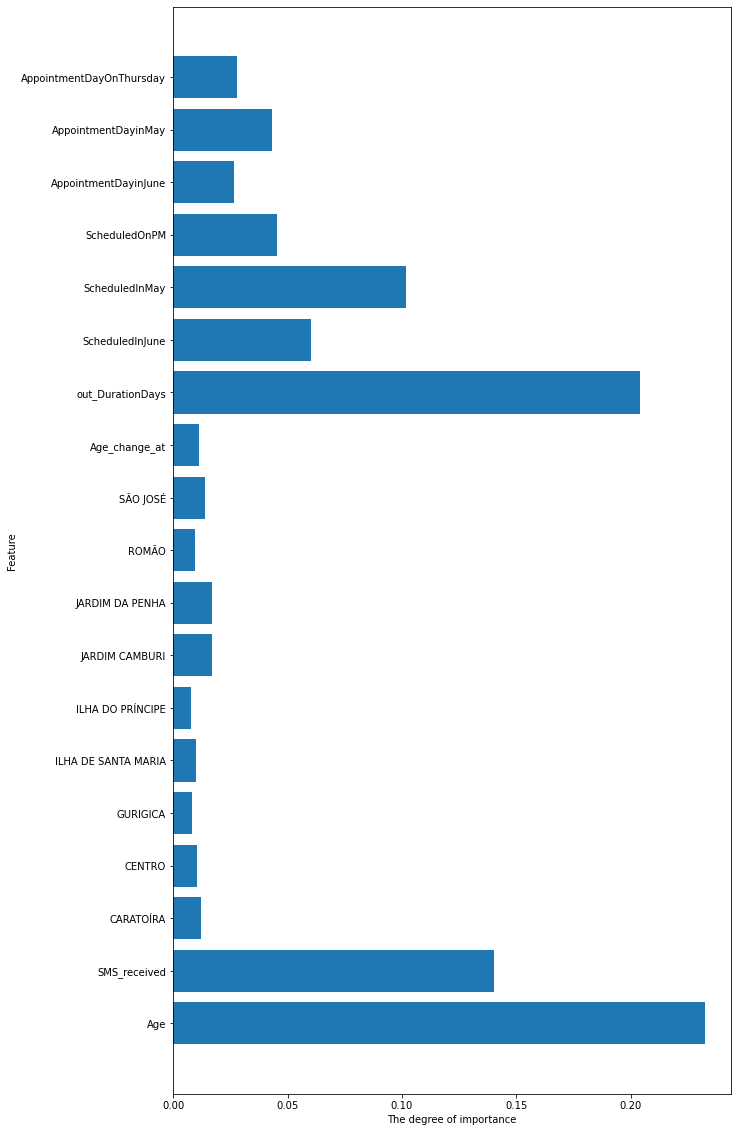

In [199]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         random_forest_sig_tuned_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

To improve this visual, I will now only output variables that have prediction power of 10% and more.

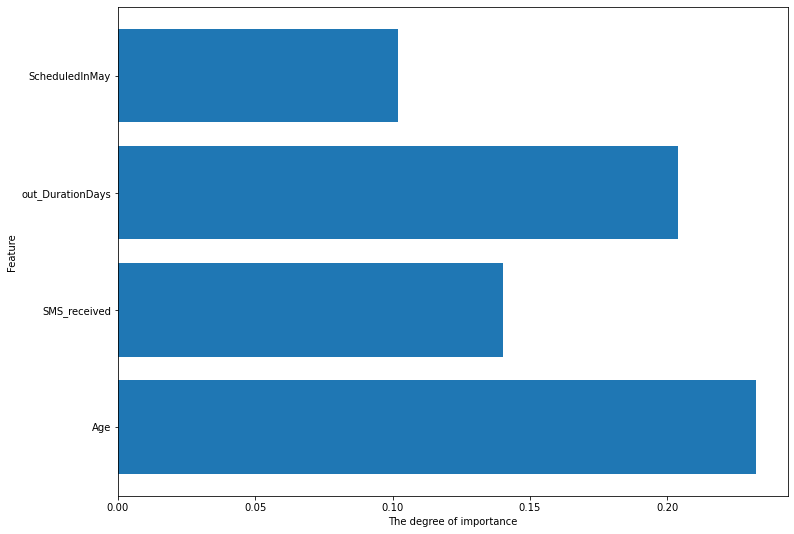

In [200]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = random_forest_sig_tuned_fit.feature_importances_>= 0.1

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), 
         random_forest_sig_tuned_fit.feature_importances_[features_mask], 
         align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

The result is very similar to the un-tuned model. Before testing another model, I will save the results of this model.

In [201]:
# Training accuracy
random_forest_sig_tuned_train_acc =\
random_forest_sig_tuned_fit.score(X_train, y_train).round(4)

# Testing accuracy
random_forest_sig_tuned_test_acc =\
random_forest_sig_tuned_fit.score(X_test, y_test).round(4)

# F1 score
random_forest_sig_tuned_f1_score = f1_score(y_test, 
                                      random_forest_sig_tuned_pred).round(4)

# AUC score
random_forest_sig_tuned_auc_score = roc_auc_score(
    y_true = y_test,
    y_score = random_forest_sig_tuned_pred).round(4)

# Saving the results
model_performance.append([
    'Tuned Random Forest Classifier with significant variables',
    random_forest_sig_tuned_train_acc,
    random_forest_sig_tuned_test_acc,
    random_forest_sig_tuned_f1_score,
    random_forest_sig_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

___

#### XGBoost with all explanatory variables

##### Without GridSearchCV

Before working with this model, I will segment my data appropriately.

In [202]:
# Segmenting the data
my_df_data_full     = my_df.loc[ :, variables['full']]
my_df_target        = my_df.loc[ :, 'Outcome']

Next, I will re-instantiate my train-test-split function to ensure I am working with the right data.

In [203]:
# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_full,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

XGBoost model has a hyperparameter <i>scale_pos_weight</i> which allows me to inform this model of the class imbalance in my data. Therefore, I should get better results than I would without specifying this parameter.

In the next code block, I will calculate the class weight for my XGBoost model.

In [204]:
# Calculating the class weight
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

Now, I will analyze the performance of this model using hand-picked values for hyperparameters.

In [205]:
# Instantiating XGBClassifier
xgb_full = XGBClassifier(max_depth = 4,
                         learning_rate = 0.01,
                         n_estimators = 178,
                         scale_pos_weight = class_weight,
                         random_state = 331)

# Fitting the model
xgb_full_fit = xgb_full.fit(X_train, y_train)

# Predicting on the test set
xgb_full_pred = xgb_full_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", xgb_full_fit.score(X_train, y_train).round(4))
print("Test accuracy:", xgb_full_fit.score(X_test, y_test).round(4))

Training accuracy: 0.5757
Test accuracy: 0.5682


The model is neither over-fit, nor under-fit, which is a good start. Next, I will evaluate the F1 score of this model.

In [206]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, xgb_full_pred).round(4))

F1 score: 0.4471


The F1 score is low, but among the highest compared to other models I evaluated. Next, I will take a look at the confusion matrix.

In [207]:
# Creating a confusion matrix data frame
xgb_full_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = xgb_full_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
xgb_full_cm

,Predicted to show up,Predicted No-show
Actually showed up,900,931
Actual No-show,56,399


So far, this is the best confusion matrix I have. This model makes many errors predicting which customers will show up, but this is not what I am interested in the most. What I am interested in the most is predicting which customers will not show up. Out of 455 examples, this model correctly predicts 399 examples, which is good so far. 

Next, I will evaluate the AUC value for this model.

In [208]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = xgb_full_pred)

0.6842288787127673

Similarly to confusion matrix, this AUC value is the best I have so far. Next, I will evaluate feature importnaces of XGBoost.

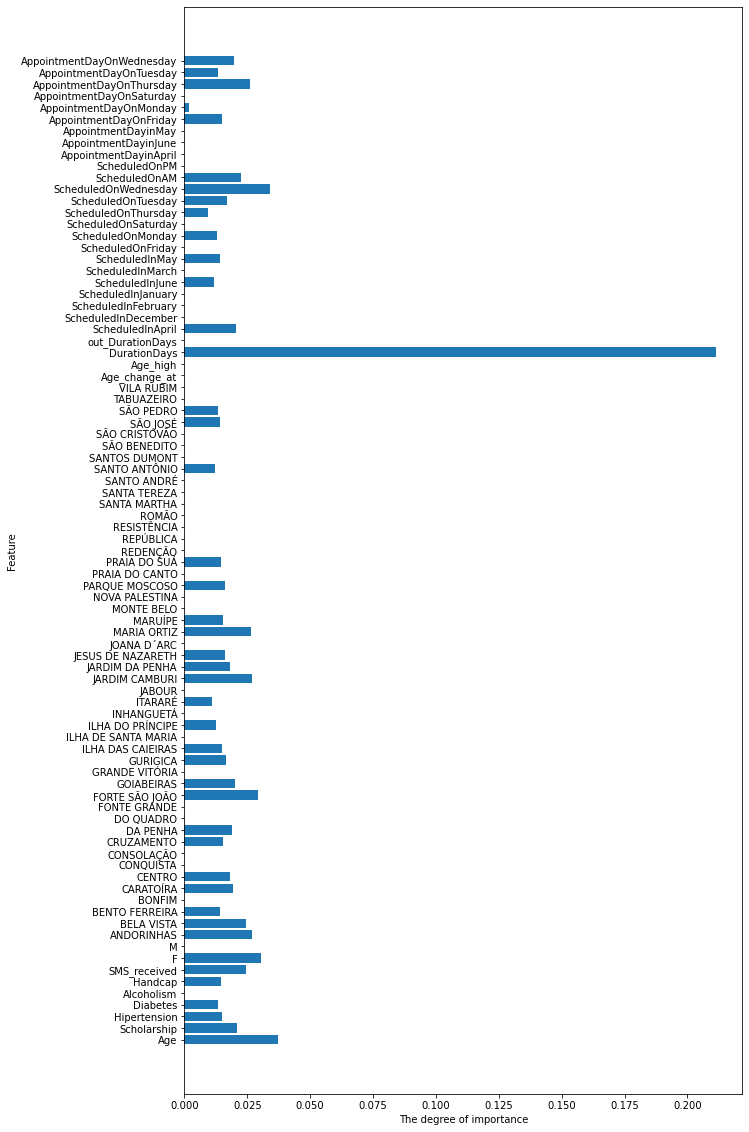

In [209]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         xgb_full_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

By far, the most powerful predictor is DurationDays. I will not evaluate this specific graph in details, because I will be more interested later in seeing feature importnaces of XGBoost when it only has significant variables to analyze.

In the next code block, I will save the results of this model.

In [210]:
# Training accuracy
xgb_full_train_acc = xgb_full_fit.score(X_train, y_train).round(4)

# Testing accuracy
xgb_full_test_acc = xgb_full_fit.score(X_test, y_test).round(4)

# F1 score
xgb_full_f1_score = f1_score(y_test, xgb_full_pred).round(4)

# AUC score
xgb_full_auc_score = roc_auc_score(y_true = y_test,
                                   y_score = xgb_full_pred).round(4)

# Saving the results
model_performance.append(['XGBoost with all explanatory variables',
                          xgb_full_train_acc,
                          xgb_full_test_acc,
                          xgb_full_f1_score,
                          xgb_full_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

##### With GridSearchCV

In the code below I will run Grid Search to find the best hyperparameters for this model.

In [211]:
"""
# Declaring a hyper-parameter space
max_depth_space          =   pd.np.arange(1, 5, 1)
learning_rate_space      =   pd.np.arange(0.01, 0.07, 0.01)
n_estimators_space       =   pd.np.arange(150, 250, 25)

# Creating a hyperparameter grid
param_grid = {"max_depth"           : max_depth_space,
              "learning_rate"       : learning_rate_space,
              "n_estimators"        : n_estimators_space}

# Instantiating the Decision Tree Classifier
xgb_full_tuned = XGBClassifier(random_state = 331,
                               scale_pos_weight = class_weight)

# GridSearchCV object
xgb_full_tuned_cv = GridSearchCV(estimator   = xgb_full_tuned,
                                 param_grid  = param_grid,
                                 cv          = 5, 
                                 scoring     = make_scorer(roc_auc_score,
                                                           needs_threshold = False))

# Fitting to the full dataset
xgb_full_tuned_cv.fit(my_df_data_full, my_df_target)

# Printing the results
print("Tuned parameters:", xgb_full_tuned_cv.best_params_)
print("Tuned Training AUC:", xgb_full_tuned_cv.best_score_.round(4))
"""

'\n# Declaring a hyper-parameter space\nmax_depth_space          =   pd.np.arange(1, 5, 1)\nlearning_rate_space      =   pd.np.arange(0.01, 0.07, 0.01)\nn_estimators_space       =   pd.np.arange(150, 250, 25)\n\n# Creating a hyperparameter grid\nparam_grid = {"max_depth"           : max_depth_space,\n              "learning_rate"       : learning_rate_space,\n              "n_estimators"        : n_estimators_space}\n\n# Instantiating the Decision Tree Classifier\nxgb_full_tuned = XGBClassifier(random_state = 331,\n                               scale_pos_weight = class_weight)\n\n# GridSearchCV object\nxgb_full_tuned_cv = GridSearchCV(estimator   = xgb_full_tuned,\n                                 param_grid  = param_grid,\n                                 cv          = 5, \n                                 scoring     = make_scorer(roc_auc_score,\n                                                           needs_threshold = False))\n\n# Fitting to the full dataset\nxgb_full_tuned_cv.f

Now that I have my hyperparameter values, I will plug them into the model. 

In [212]:
# Instantiating XGBClassifier
xgb_full_tuned = XGBClassifier(max_depth = 1,
                               learning_rate = 0.01,
                               n_estimators = 150,
                               scale_pos_weight = class_weight,
                               random_state = 331)

# Fitting the model
xgb_full_tuned_fit = xgb_full_tuned.fit(X_train, y_train)

# Predicting on the test set
xgb_full_tuned_pred = xgb_full_tuned_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", 
      xgb_full_tuned_fit.score(X_train, y_train).round(4))
print("Test accuracy:", 
      xgb_full_tuned_fit.score(X_test, y_test).round(4))

Training accuracy: 0.5277
Test accuracy: 0.5227


The tuned model is neither over-fit nor under-fit. Next, I will analyze the F1 score of this model. 

In [213]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, xgb_full_tuned_pred).round(4))

F1 score: 0.4327


The F1 score is still very low, because this model makes many mistakes. To understand its mistakes, I will next analyze the confusion matrix.

In [214]:
# Creating a confusion matrix data frame
xgb_full_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = xgb_full_tuned_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
xgb_full_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,779,1052
Actual No-show,39,416


So far, this is the best confusion matrix in the sense that it best predicts which customers will actually not show up. However, this model still makes many mistakes. Next, I will analyze the AUC value of this model.

In [215]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = xgb_full_tuned_pred)

0.6698681438714207

This AUC value is slighly worse than the one before. Next, I will see if there are any changes in which predictors are the strongest.

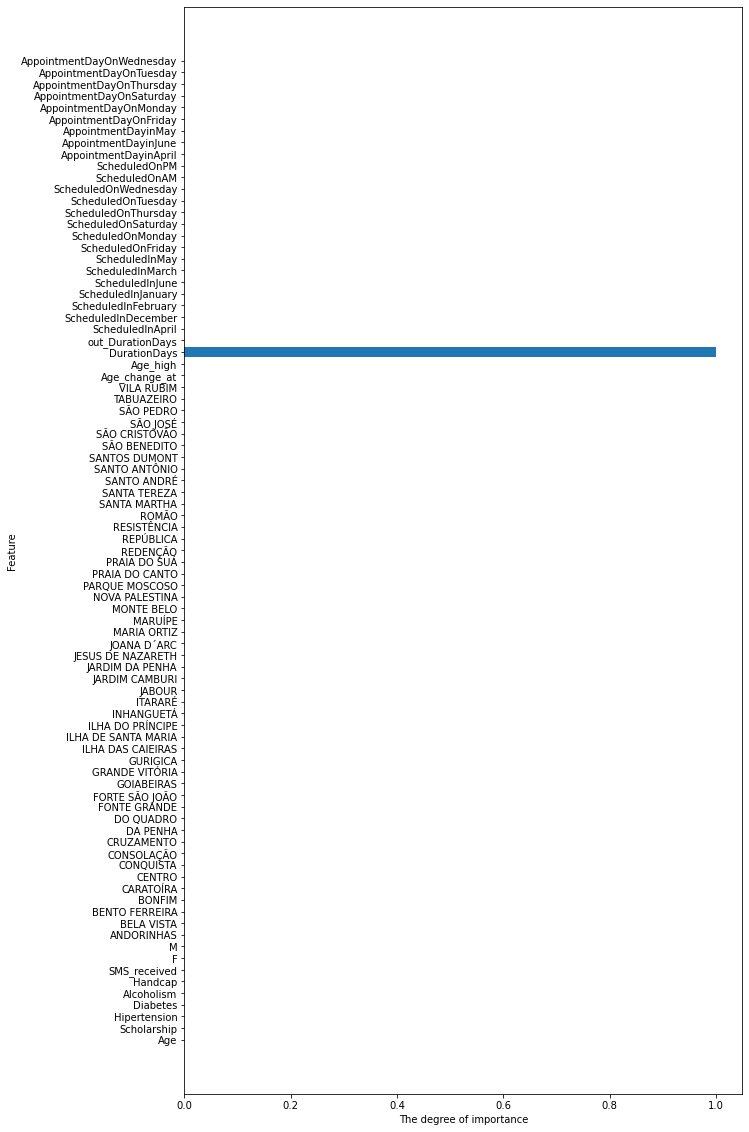

In [216]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         xgb_full_tuned_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

Surprisingly, only DurationDays is used by the tuned model to identify which customers are likely to not show up for their scheduled appointment. Next, I will save the results of this model.

In [217]:
# Training accuracy
xgb_full_tuned_train_acc = xgb_full_tuned_fit.score(X_train, y_train).round(4)

# Testing accuracy
xgb_full_tuned_test_acc = xgb_full_tuned_fit.score(X_test, y_test).round(4)

# F1 score
xgb_full_tuned_f1_score = f1_score(y_test, xgb_full_tuned_pred).round(4)

# AUC score
xgb_full_tuned_auc_score = roc_auc_score(y_true = y_test,
                                   y_score = xgb_full_tuned_pred).round(4)

# Saving the results
model_performance.append(['Tuned XGBoost with all explanatory variables',
                          xgb_full_tuned_train_acc,
                          xgb_full_tuned_test_acc,
                          xgb_full_tuned_f1_score,
                          xgb_full_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

#### XGBoost with significant variables

##### Without GridSearchCV

Before evaluating XGBoost with significant variables, I will first segment my data appropriately for this model's analysis.

In [218]:
# Segmenting the data
my_df_data_sig      = my_df.loc[ :, variables['sig']]
my_df_target        = my_df.loc[ :, 'Outcome']

Next, I will re-instantiate my train-test split to account for the segmented data.

In [219]:
# Declaring train_test_split with stratification
X_train, X_test, y_train, y_test = train_test_split(my_df_data_sig,
                                                    my_df_target,
                                                    test_size = 0.25,
                                                    random_state = 331,
                                                    stratify = my_df_target)

Next, I will evaluate the performnace of XGBoost with significant variables.

In [220]:
# Instantiating XGBClassifier
xgb_sig = XGBClassifier(max_depth = 4,
                        learning_rate = 0.01,
                        n_estimators = 200,
                        scale_pos_weight = class_weight,
                        random_state = 331)

# Fitting the model
xgb_sig_fit = xgb_sig.fit(X_train, y_train)

# Predicting on the test set
xgb_sig_pred = xgb_sig_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", xgb_sig_fit.score(X_train, y_train).round(4))
print("Test accuracy:", xgb_sig_fit.score(X_test, y_test).round(4))

Training accuracy: 0.691
Test accuracy: 0.6767


According to accuracies above, this model is neither under-fit nor over-fit. Next, I will analyze the F1 score of this model.

In [221]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, xgb_sig_pred).round(4))

F1 score: 0.4204


The F1 score is low, and I will next evaluate the confusion matrix.

In [222]:
# Creating a confusion matrix data frame
xgb_sig_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = xgb_sig_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
xgb_sig_cm

,Predicted to show up,Predicted No-show
Actually showed up,1279,552
Actual No-show,187,268


According to the confusion matrix, this model is not as good in predicting which customers are likely to not show up for their scheduled appointment, but it also makes many less errors than other models. Next, I will evaluate the AUC value.

In [223]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = xgb_sig_pred)

0.6437681924847408

The AUC value is better than a random chance, which is good, but it is not as good as I would like it to be. In the next code block, I will evaluate the feature importances of this model.

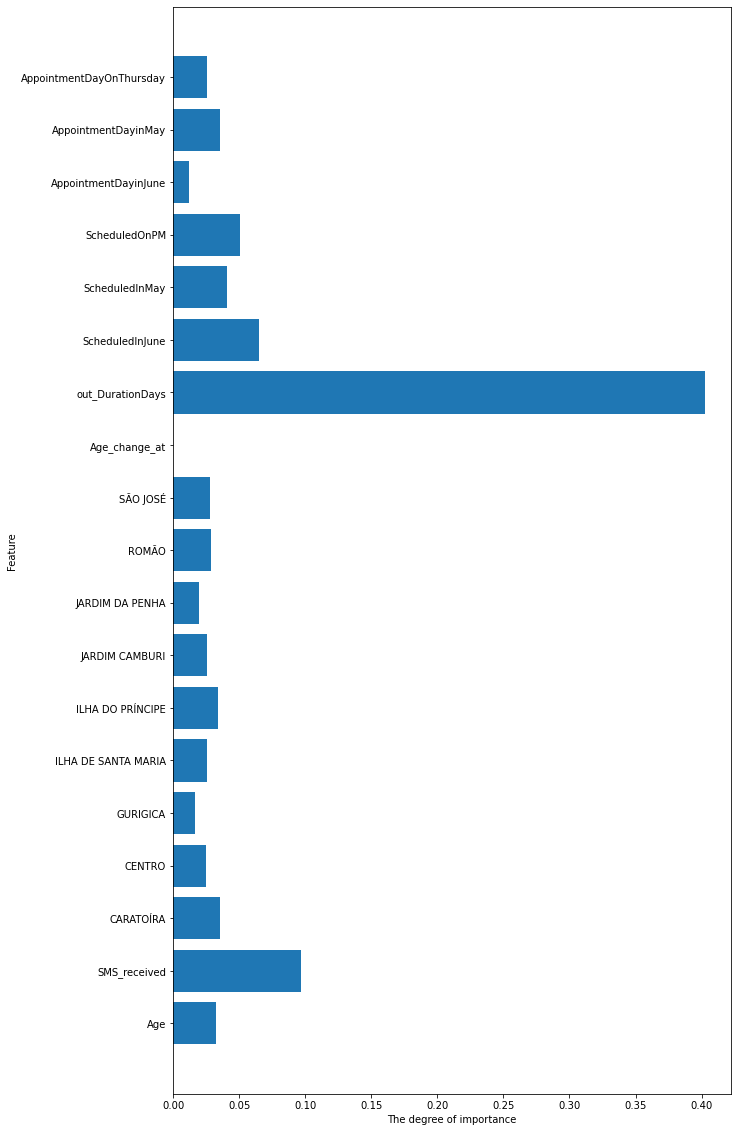

In [224]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         xgb_sig_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

As I expected, in the absence of "DurationDays" column, "out_Duration_days" column became the most significant variable. Before evaluating this model using GridSearchCV, I will save the results of this model.

In [225]:
# Training accuracy
xgb_sig_train_acc = xgb_sig_fit.score(X_train, y_train).round(4)

# Testing accuracy
xgb_sig_test_acc = xgb_sig_fit.score(X_test, y_test).round(4)

# F1 score
xgb_sig_f1_score = f1_score(y_test, xgb_sig_pred).round(4)

# AUC score
xgb_sig_auc_score = roc_auc_score(
    y_true = y_test,
    y_score = xgb_sig_pred).round(4)

# Saving the results
model_performance.append([
    'XGBoost with significant variables',
    xgb_sig_train_acc,
    xgb_sig_test_acc,
    xgb_sig_f1_score,
    xgb_sig_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

##### With GridSearchCV

In the next code block, I will run GridSearchCV to identify best values to plug into hyperparameters.

In [226]:
"""
# Declaring a hyper-parameter space
max_depth_space          =   pd.np.arange(1, 7, 1)
learning_rate_space      =   pd.np.arange(0.01, 0.1, 0.01)
n_estimators_space       =   pd.np.arange(100, 250, 25)

# Creating a hyperparameter grid
param_grid = {"max_depth"           : max_depth_space,
              "learning_rate"       : learning_rate_space,
              "n_estimators"        : n_estimators_space}

# Instantiating the Decision Tree Classifier
xgb_sig_tuned = XGBClassifier(random_state = 331,
                              scale_pos_weight = class_weight)

# GridSearchCV object
xgb_sig_tuned_cv = GridSearchCV(estimator    = xgb_sig_tuned,
                                 param_grid  = param_grid,
                                 cv          = 5, 
                                 scoring     = make_scorer(roc_auc_score,
                                                           needs_threshold = False))

# Fitting to the full dataset
xgb_sig_tuned_cv.fit(my_df_data_sig, my_df_target)

# Printing the results
print("Tuned parameters:", xgb_sig_tuned_cv.best_params_)
print("Tuned Training AUC:", xgb_sig_tuned_cv.best_score_.round(4))
"""

'\n# Declaring a hyper-parameter space\nmax_depth_space          =   pd.np.arange(1, 7, 1)\nlearning_rate_space      =   pd.np.arange(0.01, 0.1, 0.01)\nn_estimators_space       =   pd.np.arange(100, 250, 25)\n\n# Creating a hyperparameter grid\nparam_grid = {"max_depth"           : max_depth_space,\n              "learning_rate"       : learning_rate_space,\n              "n_estimators"        : n_estimators_space}\n\n# Instantiating the Decision Tree Classifier\nxgb_sig_tuned = XGBClassifier(random_state = 331,\n                              scale_pos_weight = class_weight)\n\n# GridSearchCV object\nxgb_sig_tuned_cv = GridSearchCV(estimator    = xgb_sig_tuned,\n                                 param_grid  = param_grid,\n                                 cv          = 5, \n                                 scoring     = make_scorer(roc_auc_score,\n                                                           needs_threshold = False))\n\n# Fitting to the full dataset\nxgb_sig_tuned_cv.fit(my

Now that I have my hyperparameter values, I will plug them into the model.

In [227]:
# Instantiating XGBClassifier
xgb_sig_tuned = XGBClassifier(max_depth = 2,
                              learning_rate = 0.01,
                              n_estimators = 100,
                              scale_pos_weight = class_weight,
                              random_state = 331)

# Fitting the model
xgb_sig_tuned_fit = xgb_sig_tuned.fit(X_train, y_train)

# Predicting on the test set
xgb_sig_tuned_pred = xgb_sig_tuned_fit.predict(X_test)

# Scoring the results
print("Training accuracy:", 
      xgb_sig_tuned_fit.score(X_train, y_train).round(4))
print("Test accuracy:", 
      xgb_sig_tuned_fit.score(X_test, y_test).round(4))

Training accuracy: 0.6376
Test accuracy: 0.6343


The model is still neither under-fit nor over-fit. Next, I will analyze its F1 score.

In [228]:
# Calculating and printing the F1 score
print('F1 score:', f1_score(y_test, xgb_sig_tuned_pred).round(4))

F1 score: 0.4113


The F1 score is still low, and next I will evaluate the confusion matrix.

In [229]:
# Creating a confusion matrix data frame
xgb_sig_tuned_cm = pd.DataFrame(
    confusion_matrix(y_true = y_test,
                     y_pred = xgb_sig_tuned_pred),
    columns=['Predicted to show up', "Predicted No-show"],
    index=['Actually showed up', 'Actual No-show'])

# Printing the results
xgb_sig_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1158,673
Actual No-show,163,292


The model still makes many mistakes, and is not particularly great in identifying either outcomes correctly. Next, I will evaluate its AUC value.

In [230]:
# Printing the AUC value
roc_auc_score(y_true = y_test,
              y_score = xgb_sig_tuned_pred)

0.6370997653357019

The AUC value is not among the best I have, unfortunately. To see which features contributed the most to this model, I will next plot feature importances.

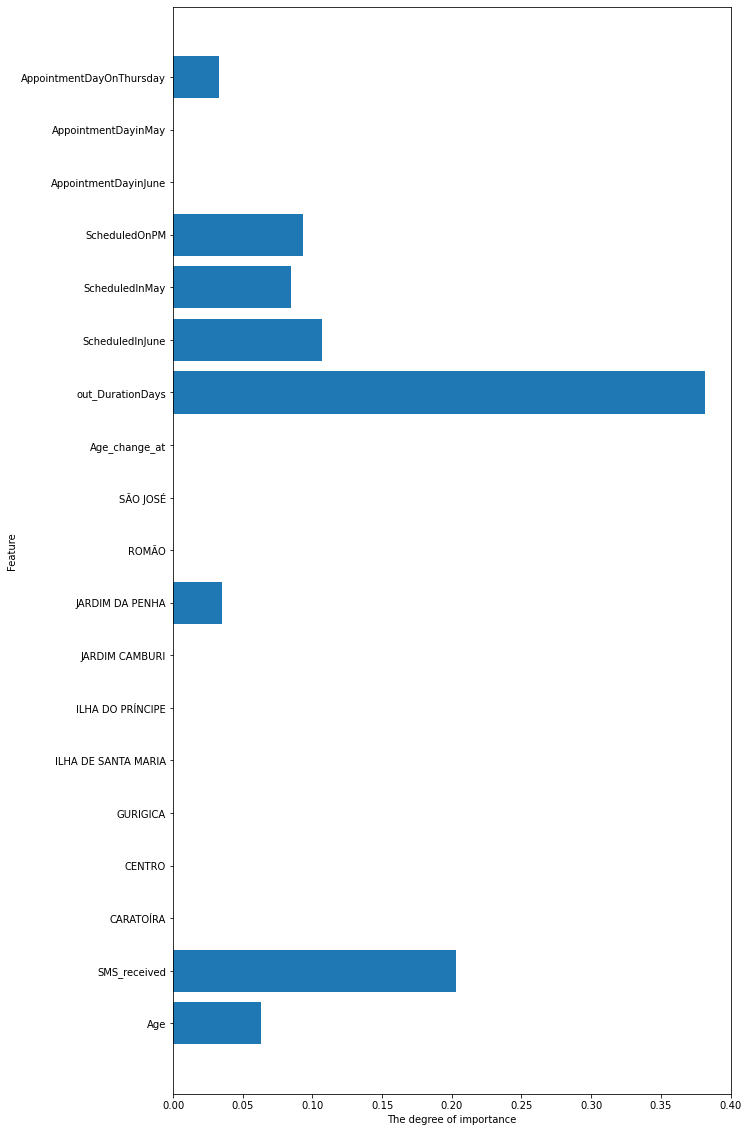

In [231]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), 
         xgb_sig_tuned_fit.feature_importances_, 
         align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

Interestingly, this time "SMS_received" has proven to be much more important than before. To conclude with this model, I will save its results.

In [232]:
# Training accuracy
xgb_sig_tuned_train_acc = xgb_sig_tuned_fit.score(X_train, y_train).round(4)

# Testing accuracy
xgb_sig_tuned_test_acc = xgb_sig_tuned_fit.score(X_test, y_test).round(4)

# F1 score
xgb_sig_tuned_f1_score = f1_score(y_test, xgb_sig_tuned_pred).round(4)

# AUC score
xgb_sig_tuned_auc_score = roc_auc_score(
    y_true = y_test,
    y_score = xgb_sig_tuned_pred).round(4)

# Saving the results
model_performance.append([
    'Tuned XGBoost with significant variables',
    xgb_sig_tuned_train_acc,
    xgb_sig_tuned_test_acc,
    xgb_sig_tuned_f1_score,
    xgb_sig_tuned_auc_score])

# Checking the results
for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'F1 Score', 'AUC Value']
['Logistic Regression with all explanatory variables', 0.6595, 0.6404, 0.4069, 0.6327]
['Tuned Logistic Regression with all explanatory variables', 0.6617, 0.6422, 0.409, 0.6346]
['Logistic Regression with significant variables', 0.6476, 0.6352, 0.4085, 0.6343]
['Tuned Logistic Regression with significant variables', 0.6492, 0.6391, 0.4094, 0.6351]
['KNN with all explanatory variables', 0.802, 0.8005, 0.0215, 0.5039]
['Tuned KNN with all explanatory variables', 0.816, 0.7878, 0.1506, 0.5273]
['KNN with significant variables', 0.8034, 0.7927, 0.0558, 0.5064]
['Tuned KNN with significant variables', 0.823, 0.7752, 0.1841, 0.5318]
['Decision Tree with all explanatory variables', 0.556, 0.5538, 0.4383, 0.6744]
['Tuned Decision Tree with all explanatory variables', 0.6277, 0.6216, 0.4459, 0.6754]
['Decision Tree with significant variables', 0.6734, 0.6623, 0.4222, 0.6463182912117921]
['Tuned Decision Tree with signi

___

## Analyzing the best performing model

To determine which model performs the best, I will first save <i>model_performance</i> as an Excel file in my directory, and then upload it again to Jupyter Notebook.

In [236]:
# Converting model_performance to a Data Frame
model_performance_df = pd.DataFrame(model_performance[1:], 
                                    columns = model_performance[0])

# Printing the data frame
model_performance_df

,Model,Training Accuracy,Testing Accuracy,F1 Score,AUC Value
0,Logistic Regression with all explanatory varia...,0.6595,0.6404,0.4069,0.632700
1,Tuned Logistic Regression with all explanatory...,0.6617,0.6422,0.4090,0.634600
2,Logistic Regression with significant variables,0.6476,0.6352,0.4085,0.634300
3,Tuned Logistic Regression with significant var...,0.6492,0.6391,0.4094,0.635100
4,KNN with all explanatory variables,0.8020,0.8005,0.0215,0.503900
5,Tuned KNN with all explanatory variables,0.8160,0.7878,0.1506,0.527300
6,KNN with significant variables,0.8034,0.7927,0.0558,0.506400
7,Tuned KNN with significant variables,0.8230,0.7752,0.1841,0.531800
8,Decision Tree with all explanatory variables,0.5560,0.5538,0.4383,0.674400
9,Tuned Decision Tree with all explanatory varia...,0.6277,0.6216,0.4459,0.675400


Next, I will sort my data frame by the highest AUC value in descending order.

In [239]:
# Sorting the results by AUC value in descending order
model_performance_df.sort_values(by = 'AUC Value', ascending = False)

,Model,Training Accuracy,Testing Accuracy,F1 Score,AUC Value
16,XGBoost with all explanatory variables,0.5757,0.5682,0.4471,0.684200
12,Random Forest with all explanatory variables,0.6643,0.6159,0.4485,0.679300
13,Tuned Random Forest Classifier will all explan...,0.6603,0.6107,0.4465,0.677700
9,Tuned Decision Tree with all explanatory varia...,0.6277,0.6216,0.4459,0.675400
8,Decision Tree with all explanatory variables,0.5560,0.5538,0.4383,0.674400
17,Tuned XGBoost with all explanatory variables,0.5277,0.5227,0.4327,0.669900
11,Tuned Decision Tree with signifiant variables,0.6608,0.6496,0.4242,0.649100
15,Tuned Random Forest Classifier with significan...,0.7176,0.6829,0.4241,0.646800
10,Decision Tree with significant variables,0.6734,0.6623,0.4222,0.646318
18,XGBoost with significant variables,0.6910,0.6767,0.4204,0.643800


According to the table above, XGBoost with all explanatory variables has the best AUC value. This means it is the model that is best able to distinguish between customers who make it to their scheduled appointment and customers who don't. However, this model also uses all explanatory variables, which is not ideal, especially since there are 85 of them, and only few variables serve as significant predictors.

The best model out of those I tested that only use significant variables is Tuned Decision Tree. This model has an F1 score that is 2% lower than the F1 score of the XGBoost with all explanatory variables, and it has the AUC value that is 3.5% lower than the AUC of the best performing model. However, even though Tuned Decision Tree model has a lower AUC value by 3.5%, it uses 5 times fewer explanatory variables. 

Because of its ability to do almost as well with a fraction of explanatory variables, I consider Tuned Decision Tree with significant variables to be my best model. 

Now that I identified the model that works best to predict which customers are likely to not show up to their scheduled appointment, I will learm as much as I can about this model. Next, I will once more analyze its confusion matrix.

In [242]:
# Printing the confusion matrix of Tuned Decision Tree 
# with significant variables.
decision_tree_sig_tuned_cm

,Predicted to show up,Predicted No-show
Actually showed up,1190,641
Actual No-show,160,295


Considering heavy imbalance of my dataset, this confusion matrix is decent. 65% of the time it predicts both outcomes correctly. This is above the random chance, but still low. However, this is understandable given small amount of observations in my variable (10,000). Out of these 10,000 observations, only 2,000 describe customers who missed their scheduled appointment. Given the limited data, the model does okay predicting both classes, even though it also makes significant amount of mistakes.

In business settings, this model attempts to predict which customers will and which won't show up for their medical appointment. Hence, when a model predicts wrong, this doesn't come with significant financial or other business-related implications. If a customer is scheduled to come, this means that business is open, and as long as customer is scheduled that business cannot close, even if customer won't come. Given the business context and considering the fact that wrong predictions don't carry significant financial implications, this model is acceptable.

As more data becomes available over time with more customers scheduling an appointment, the model will have more data to learn from, and then will be able to make better predictions. 

In the next code block, I will once more plot feature importances to understand which variables play the biggest role in predicting if customers will show up.  

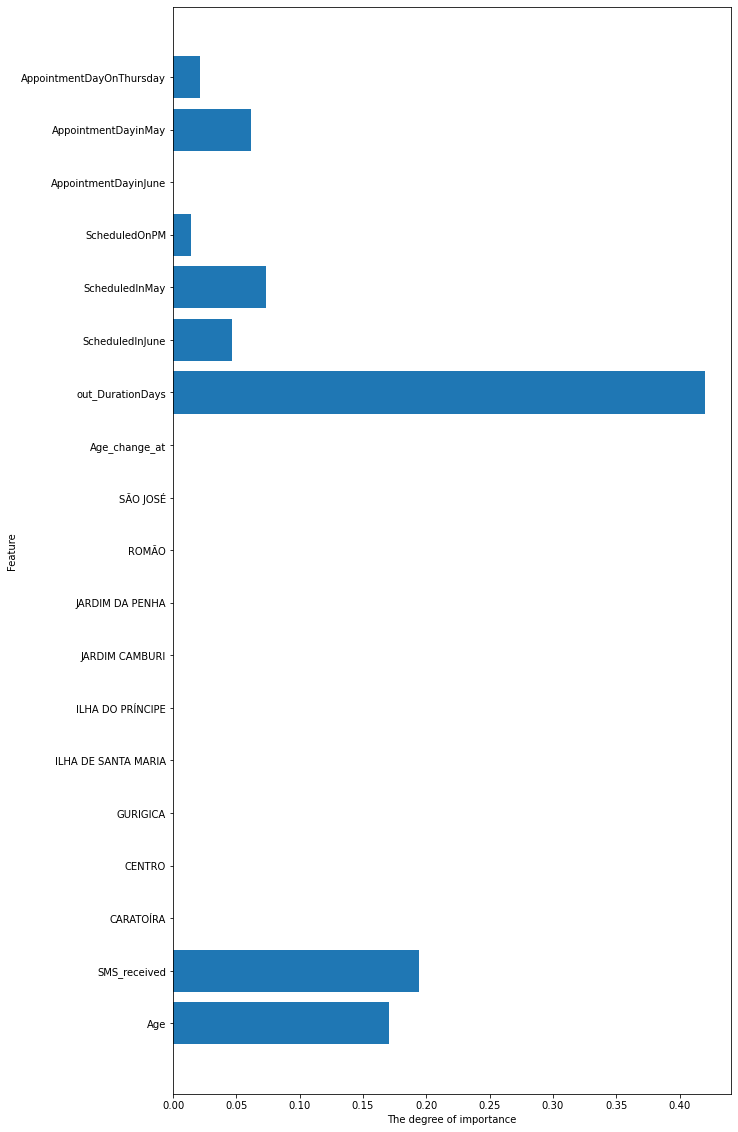

In [245]:
# Declaring the number of features in the X_train data
n_features = X_train.shape[1]

# Setting the plot window
figsize = plt.subplots(figsize = (10, 20))

# Specifying the contents of the plot
plt.barh(range(n_features), decision_tree_sig_tuned_fit.feature_importances_, align = 'center')
plt.yticks(pd.np.arange(n_features), X_train.columns)
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

To facilitate my evaluation, I will filter the graph above to only show me explanatory variables with at least 10% of prediction power. 

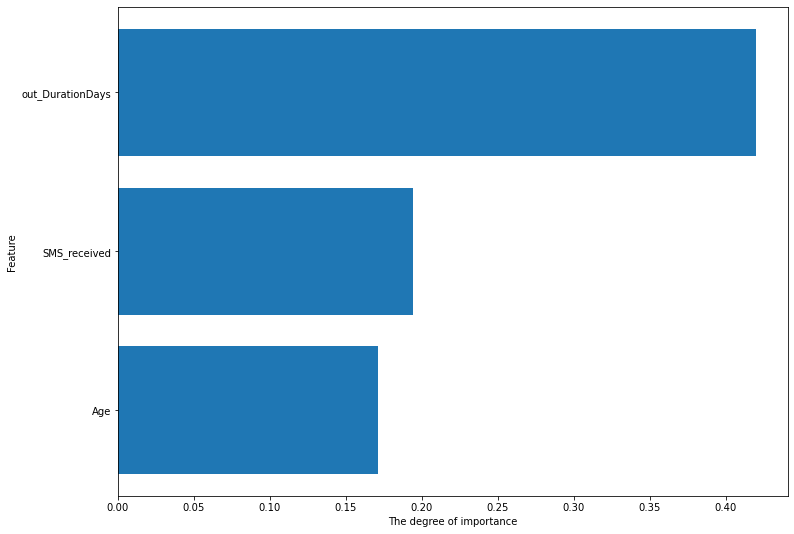

In [246]:
# Setting the plot window
figsize = plt.subplots(figsize = (12, 9))

# Limiting output to only show features with predictive power of 5% or more
features_mask = decision_tree_sig_tuned_fit.feature_importances_>= 0.1

# Specifying the contents of the plot
plt.barh(range(sum(features_mask)), 
         decision_tree_sig_tuned_fit.feature_importances_[features_mask], 
         align = 'center')
plt.yticks(pd.np.arange(sum(features_mask)), 
           X_train.columns[features_mask])
plt.xlabel("The degree of importance")
plt.ylabel("Feature")
plt.show()

Before I analyze the graph above, in the code block below I will print the exact prediction power of these 3 explanatory variables

In [250]:
# Displaying the dictionary
print("Prediction power of out_DurationDays:", 
      dict(zip(X_train, 
               decision_tree_sig_tuned_fit.feature_importances_))\
      ['out_DurationDays'].round(2))

print("Prediction power of SMS_received:", 
      dict(zip(X_train, 
               decision_tree_sig_tuned_fit.feature_importances_))\
      ['SMS_received'].round(2))

print("Prediction power of Age:", 
      dict(zip(X_train, 
               decision_tree_sig_tuned_fit.feature_importances_))\
      ['Age'].round(2))

Prediction power of out_DurationDays: 0.42
Prediction power of SMS_received: 0.19
Prediction power of Age: 0.17


<b>out_DurationDays</b>

In cases where less than 14 days passed between the day customers book an appointment and the day of the appointment, 16% of customers failed to show up for their scheduled visit. 

In cases where 14 days or more passed between the day an appointment was scheduled and the day of appointment, 33% of customers failed to arrive for their visit. 

out_DurationDays column is the strongest variable that explains why customers don't show up for their scheduled appointment, and it carries prediction power of 42%. According to the the data, if customers are allowed to book more in advance, they are considerably more likely to miss their appointment.

Conclusively, based on data, I recommend this business to, whenever possible, only allow customers to book an appointment for up to 14 days in advance. In cases where customers have to schedule more than 14 days in advance, this business may consider placing a card on file at the time of scheduling and charging 50% of appointment fee in case customers don't show up.

<b>SMS_received</b>

Of all customers that did not show up to their scheduled appointment, 795 received an SMS confirmation / reminder for appointment, and 1026 did not. These numbers are rougly similar, and what they indicate is that not every customer has the same booking experience. If the booking experience is the same for all customers, it may lead to more customers showing up for their scheduled appointment. 

Based on the graph above, 20% of the reason why customers don't show up is explained by the "SMS_received" column. To help reduce number of customers who don't come for their scheduled visit, either all customers need to receive SMS confirmation / reminder, or none at all. My recommendation is to ensure every customer:

- receives an SMS confirmation right after their appointment is confirmed 
- received an SMS reminder 48h prior to their scheduled visit. 

In turn, this may minimize the number of customers who do not arrive for their visit. 

<b>Age</b>

According to the data, 33% of people who miss their scheduled appointment are of age 21 or younger. These are the people who are at home as toddlers, at school, or in their Bachelor's degree. These customers, generally, have more flexible schedules than employed working professionals and may be able to attend a virtual session at times when they cannot come in. Therefore, I recommend this business to develop a virtual session alternative for customers who cannot physically show up. 

This may reduce the number of no-shows - a goal for any business.

___

## Conclusion - should you use the best performing machine learning model?

The best performing machine learning model - Tuned Decision Tree With Significant Variables - predicts better than a random chance; it correctly predicts whether a customer will arrive to their scheduled appointment or not 65% of the time. 

Generally, 65% prediction capability is low. However, this depends on the nature of a business. Specifically, if wrong machine learning model's predictions do not carry substantial financial or other business-related implications, then I recommend you implement this model. At first, it will be wrong 35% of the time, and as you serve more customers and your data set grows, this model will be better able to learn and will consequently perform better as more data becomes available. Therefore, I suggest you use this model to help you predict which customers are likely to arrive, and which are likely to miss their scheduled appointment. 

If incorrect predictions by this machine learning model will carry substantial financial or other business-related risk, then I recommend you consider this model and continue to train it as more data becomes available. As you serve more customers, your data set will grow, and this model will have more information to learn from and get better. Once the model reaches the level of prediction at which you will be comfortable to rely on its predictions (for example, when AUC value reaches 85%), that will be a good time to roll it out for business use.

___

## Conclusion - actionable recommendations based on my data analysis

Based on my analysis, below are the the recommendations I suggest you implement:

<b>Business Insight (1)</b>

16% of customers miss their appointment if appointment is booked for less than 14 days in advance.
33% of customers miss their appointment if appointment is booked for 14 or more days in advance.

<b>Actionable recommendation (1)</b>

Whenever possible, book customers' appointment for no more than 14 days in advance. 

To help with that, consider extending your work week from Monday-Friday to Monday-Saturday. 33% of missed appointment is a loss of 33% of expected revenue. Speak with your Finance department, and if the the cost of extending work week by 1 day will not exceed average revenue generated by 33% of your appointments per day, extend your work week for a period of time to ana
___
___
___

<b>Business Insight (2)</b>

Of all customers who did not arrive for their appointment, 44% of customers received an SMS message from your business, and 56% did not.

<b>Actionable Recommendation (2)</b>

Create the same experience for all customers, this will help better understand how SMS communication affects customers' show-up rate. Specifically:

- Send an SMS confirmation to every customer to confirm their appointment has been booked, and include details (e.g. type of appointment, time of appointment, date of appointment)
- Send an SMS reminder to every customer to remind them of their upcoming appointment 48 hours in advance, and include a phone number to call if appointment needs to be cancelled or rescheduled

___
___
___
<b>Business Insight (3)</b>

33% of customers who miss their appointment are 21 years old or younger (scholars at different stages of education)

<b>Actionable Recommendation (3)</b>

In light of growing trend of remote work and COVID-19, significant amount of work is being done virtually. Given the data and current environment, I recommend introducing virtual visits, with priority for customers who won't be able to be physically present for their scheduled appointment. Virtual meetings will, primarily, serve customers who will otherwise miss their appointment. Customers under age of 21 are likely to still be pursuing their education, which generally makes them more flexible with their time. This makes them likely to subscribe for virtual sessions. In turn, this will decrease lost revenue associated with missed appointments and decrease the number of no-shows.